# Daily NetCDFs: Xarray

> Example of flattening any number of daily NetCDFs into CSVs using a UDF, then reading with Databricks using built-in CSV reader; also, shows writing those CSVs out to Delta Lake. 

__Notes:__

1. Ran this on a DBR 15.4 LTS "classic" cluster (vs serverless).
1. Uses Xarray for working with the NetCDF files with version matching DBR dependencies.
1. In this example we are using 10 daily Coral Bleaching NetCDFs.
1. Since there are only 10 files our cluster can be small, e.g. 2 worker nodes with 4 cores each.

---
__Author:__ Michael Johns | _Last Modified:_ 18 FEB 2025

## Setup

In [0]:
%pip install xarray[io]==2024.03.0 --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from typing import List

import numpy as np
import os
import xarray as xr
import warnings

warnings.filterwarnings('ignore') # <- option to mute warnings

_Catalog and schema where we will write to Delta Lake (update with your preferred locations)._

In [0]:
catalog = "geospatial_docs"
schema = "coral_bleaching"

sql(f"use catalog {catalog}")
sql(f"use schema {schema}")

DataFrame[]

_Turn off AQE to all more control over UDF parallelism._

In [0]:
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False)

## Download NetCDF Data

_Volume paths where we will download the NetCDFs and where will generate CSVs (update with your preferred locations)._ __Note:__ Volume must already exist.

In [0]:
vol_data = f"/Volumes/{catalog}/{schema}/data/netcdf-coral"
vol_data_out = f"/Volumes/{catalog}/{schema}/data/netcdf-coral-out"

# - 'data' volume must already exist,
#   but the directories underneath can be created here
os.makedirs(vol_data, exist_ok=True) 
os.makedirs(vol_data_out, exist_ok=True)

os.environ['VOL_DATA'] = vol_data
os.environ['VOL_DATA_OUT'] = vol_data_out

In [0]:
%sh 
# download all the nc files used
# - '-nc' means no clobber here
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220101.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220102.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220103.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220104.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220105.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220106.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220107.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220108.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220109.nc
wget -P $VOL_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220110.nc

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220101.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220102.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220103.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220104.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220105.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220106.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220107.nc’ already there; not retrieving.

File ‘/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-m

## Single-Node Example

> Here is an example of going through individual steps to manually process a singe NetCDF. Later we will set up a UDF to parallelize and consolidate these steps.

In [0]:
# Open into an xarray.DataArray
netcdf_ds = (
  xr
    .open_dataset(f"{vol_data}/ct5km_baa-max-7d_v3.1_20220101.nc")
    .fillna(-1)
)
netcdf_ds

<xarray.Dataset> Size: 311MB
Dimensions:               (time: 1, lat: 3600, lon: 7200)
Coordinates:
  * time                  (time) datetime64[ns] 8B 2022-01-01T12:00:00
  * lat                   (lat) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * lon                   (lon) float32 29kB -180.0 -179.9 ... 179.9 180.0
Data variables:
    bleaching_alert_area  (time, lat, lon) int64 207MB -9223372036854775808 ....
    mask                  (time, lat, lon) float32 104MB 4.0 4.0 4.0 ... 1.0 1.0
    crs                   int64 8B -32767
Attributes: (12/58)
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    time_coverage_duration:     P7D
    time_coverage_end:          20220102T000000Z
    time_coverage_resolution:   P7D
    time_coverage_start:        20211226T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       b3633ab2-b780-4698-ac08-41c67827acfd

In [0]:
# Flatten dimensions (if necessary)
netcdf_da = netcdf_ds['bleaching_alert_area']
netcdf_da = netcdf_da.where(netcdf_da.isin([1,2,3,4]), drop=True)
netcdf_flat_da = netcdf_da.stack(xy_time=('time', 'lon', 'lat'))
netcdf_flat_da

<xarray.DataArray 'bleaching_alert_area' (xy_time: 13857057)> Size: 111MB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * xy_time  (xy_time) object 111MB MultiIndex
  * time     (xy_time) datetime64[ns] 111MB 2022-01-01T12:00:00 ... 2022-01-0...
  * lon      (xy_time) float32 55MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (xy_time) float32 55MB 83.18 83.12 83.07 ... -76.22 -76.28 -78.57
Attributes:
    comment:                Bleaching Alert Area (BAA) values are coral bleac...
    coverage_content_type:  thematicClassification
    grid_mapping:           crs
    long_name:              bleaching alert area 7-day maximum composite
    standard_name:          N/A
    units:                  stress_level
    valid_max:              4
    valid_min:              0

In [0]:
netcdf_flat_da.to_dataframe().dropna().to_csv(f"{vol_data_out}/test_out.csv", index=False)

In [0]:
df_bleach = (
  spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
  .load(f"{vol_data_out}/test_out.csv")
)
print(f"count? {df_bleach.count():,}")
df_bleach.limit(5).display()

count? 2,833,209


time,lon,lat,bleaching_alert_area
2022-01-01T12:00:00Z,-179.975,-6.875,1.0
2022-01-01T12:00:00Z,-179.975,-6.925,1.0
2022-01-01T12:00:00Z,-179.975,-6.975,1.0
2022-01-01T12:00:00Z,-179.975,-7.025,1.0
2022-01-01T12:00:00Z,-179.975,-7.075,1.0


_Here is the pie chart that renders in databricks._


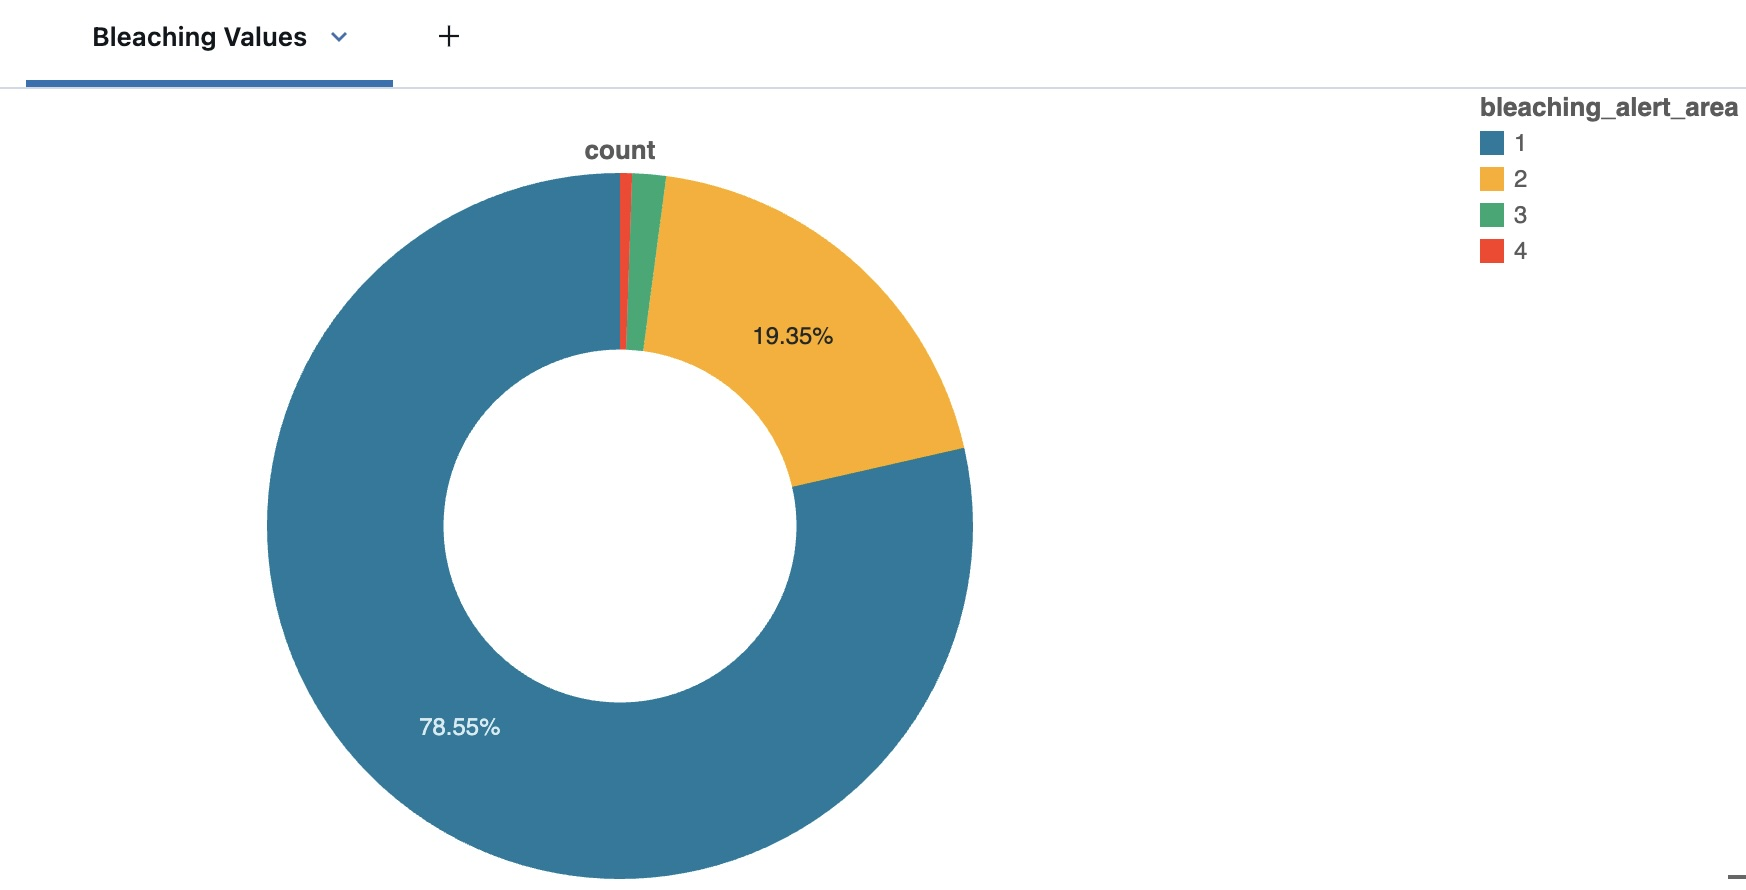

In [0]:
displayHTML("""<img src="data:image/jpg;base64,/9j/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABtKgAwAEAAAAAQAAA3qkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g/wSUNDX1BST0ZJTEUAAQEAAA/gYXBwbAIQAABtbnRyUkdCIFhZWiAH6QACAAsABgAqACJhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAABLxjcHJ0AAAGcAAAACN3dHB0AAAGlAAAABRyWFlaAAAGqAAAABRnWFlaAAAGvAAAABRiWFlaAAAG0AAAABRyVFJDAAAG5AAACAxhYXJnAAAO8AAAACB2Y2d0AAAPEAAAADBuZGluAAAPQAAAAD5tbW9kAAAPgAAAACh2Y2dwAAAPqAAAADhiVFJDAAAG5AAACAxnVFJDAAAG5AAACAxhYWJnAAAO8AAAACBhYWdnAAAO8AAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAnAAAADGhySFIAAAAUAAAB5GtvS1IAAAAMAAAB+G5iTk8AAAASAAACBGlkAAAAAAASAAACFmh1SFUAAAAUAAACKGNzQ1oAAAAWAAACPHNsU0kAAAAUAAACUmRhREsAAAAcAAACZm5sTkwAAAAWAAACgmZpRkkAAAAQAAACmGl0SVQAAAAYAAACqGVzRVMAAAAWAAACwHJvUk8AAAASAAAC1mZyQ0EAAAAWAAAC6GFyAAAAAAAUAAAC/nVrVUEAAAAcAAADEmhlSUwAAAAWAAADLnpoVFcAAAAKAAADRHZpVk4AAAAOAAADTnNrU0sAAAAWAAADXHpoQ04AAAAKAAADRHJ1UlUAAAAkAAADcmVuR0IAAAAUAAADlmZyRlIAAAAWAAADqm1zAAAAAAASAAADwGhpSU4AAAASAAAD0nRoVEgAAAAMAAAD5GNhRVMAAAAYAAAD8GVuQVUAAAAUAAADlmVzWEwAAAASAAAC1mRlREUAAAAQAAAECGVuVVMAAAASAAAEGHB0QlIAAAAYAAAEKnBsUEwAAAASAAAEQmVsR1IAAAAiAAAEVHN2U0UAAAAQAAAEdnRyVFIAAAAUAAAEhnB0UFQAAAAWAAAEmmphSlAAAAAMAAAEsABMAEMARAAgAHUAIABiAG8AagBpzuy37AAgAEwAQwBEAEYAYQByAGcAZQAtAEwAQwBEAEwAQwBEACAAVwBhAHIAbgBhAFMAegDtAG4AZQBzACAATABDAEQAQgBhAHIAZQB2AG4A/QAgAEwAQwBEAEIAYQByAHYAbgBpACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAYwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNQAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAg98AAD2/////u1hZWiAAAAAAAABKvwAAsTcAAAq5WFlaIAAAAAAAACg4AAARCwAAyLljdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuFAAAUewAAEPXAACwpAAAJmYAAA9cAABQDQAAVDkAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoFD9Ym1iAAAAAAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/bAIQAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLCwECAgIDAwMFAwMFCwgGCAsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsL/90ABABu/8AAEQgDegbSAwEiAAIRAQMRAf/EAaIAAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKCxAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6AQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgsRAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/Q/v4ooooAKKKKACiiigAooooAKKKKACiivz+/4KlftfeL/wBgv9gv4gftZ+AtKs9b1fwjDYvbWV+XFtI13e29od/llXwomLYBGSAKEgP0Bor+NP4Lf8Fv/wDgu78Rv2bNK/ao0/8AZM0fxf4LvIZ7oanoMlxEbm3t5ZI3aGzNzdXShfLIzscNjcBtIr9gP2D/APgr74W/4KMf8E+/iD+1L8MNEk8JeK/AlhqcWo6RdSLeR219bWZuYZI5AqebBIMYLRxnKuu35cmnBolSR+1lFfhX/wAG+H7fP7Q3/BRn9iXXfjn+0vdWN3r+n+Mb7RYXsLVbSL7JBaWUyAouRu3zvz6YHav2rl8c+CYPEa+DptYsU1dxlbE3EYuSMdos7untSatoNM6miiubsvGPhHUtbn8NadqtncajajM1pHOjTxj/AGowdy/iKQzpKKK5nQvGng7xRc3Fl4Z1ay1GazO2eO1nSVoj6OEJ2/jigDpqK/nP/wCCn3/BSr9qH9lX/gqj+zB+yX8JLvT4fB3xU1LTLXXormzWad47rU0tH8qUkGP90TjHQ81/QrZeJPDmparc6Dp1/bT31jj7Rbxyq0sO7pvQHK57ZAp2sJM26K/Ir9sXTP8Agqddft8/BS9/ZP8AFXh7SfgnFJD/AMJzpuoC2+2XK/aD9owJUadt1ttS2FuybZsmT5cY/WX+1dL+3/2T9pi+1Yz5O8eZjGfu9entRYZoUVgaJ4q8L+JWuI/DepWuoG0fypxbTJL5Tj+FtpO0+xqfXPEGgeGLA6r4kvrfT7VSFM1zIsUYJ6DcxApAbFFZP9vaEDbqb2DN2AYB5i/vA3TZz82e2K1qACiv57/+CXX/AAWN+Lf7YH7c3xg/YJ/aY8H6T4P8W/DX7UbT+zHnK3i6bd/ZLonziePnhki2/eQk8gZrpP8Agt3/AMFhfGn/AAS8i+GXg74MeE7Hxt40+I19dRQ6devKoS2tvKQFRCQ2+WaZEjHQ4b0quV3sLmVrn72UVwum+Jrnw94B07X/AIu3On6Pfi0gOpMJhHZxXRQeaqPIfuB8hcnOMV11hqFhqtlHqOlzx3NvMu6OWJg6MvqCOCPpUjLlFfzo/wDBFf8A4KVftPftwftVftPfCX4+XmnXGi/CrXIbDQVs7NbZ44HvNQhPmMp+c7LaPk+h9a/of0/VNM1WIz6XcRXManaWicOAfTim1YSd0X6Kz7PVdL1CWSDT7mKd4DiRY3DFD6EDp0rF13xz4J8L31vpnibWLHTrm74giubiOF5f9xWILfhSGdVRRXOyeL/CUXiBfCcuqWi6q671szMguCvqI87sfhQB0VFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVkeIC66DetGxRhbyYZTtI+U9COR7YoA16K/HD/AIIGfHj4wftM/wDBLH4d/G349eILrxR4q1mfWhe6jeEGWUW2p3UEQO0BQFijRQAB09a/Y+m1bQS2CiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//R/v4ooooAKKKKACiiigAooooAKKKKACvxG/4ON/8AlC98bP8Ar30X/wBPFjX7c1+Wv/Ban9nH4y/tbf8ABMf4o/s8/s+aP/b/AIw8RQ6WunWH2iC08422pWlxIPNuZIoVxFE7fM65xgc4FOO6E9j+ZX/gn18Y/wDg4x0j/gll4I8M/sS/CnwPqHgSPSLyLQdae5jOvGA3E+6VYp9Sjg81ZN2wNAQQB8hPFe3/APBvv4h/Zb0P/glj+0V8DPhrDrVh8VNA0vVbnx5aa7AtvIJ5LGeGEWyqSBbxGGSPY5EyyBi6qHSj9kSX/g6P/Y+/Zb8KfsifCf8AZy8Dx6T4XtpbGz1fVNWsJ7pEmlkl8xxFrixlkMnGIiMAfKa+vv8AglX/AMEbf2mP2QvgP+0N8V/2l9WsvEfxn+Omk6hA9nYOhjgkmS6chrg+VEZbu4nDPtVYowq4brjV2M10PyD/AOCXP7Xfj39h/wD4Nlfjl8efhNdfYPFkPxBudM0e52B/s9zqUGj2xmAYFd0MbvIm4Fd6jII4r8gPDWl/8EkPEH7CGp/EL4g+KfiZd/tO3dpea2mtC1d9NXWY2eSKBpNzbonZVWS5Z/MDEyfLjy6/qw/4Jpf8EVPjhqP/AARO+Kf/AATo/bf0h/h94g8a+LLrV9PkjurTUmtvLg05rO5zZzyxlRcWpV4/MV2QEfLuBrxL4G2//B0T+yL+zlb/ALAPws+E3hfWbfw9A2j+HvHx1Cxc2dhkhJFSa8jSTyFOIfOtd4VQHikxgu66Ctoj239m39qzxp+23/wbwP4o/ao+O9x8E9S067l8N+IfHsts8l9PbWUyvHHGqSwSyT3Vs0MLtEWkm+cbWZzX8q/7Yln/AMEaPgl8CPC+v/8ABNP4iePtX+NfhnVLJ38RPbTabZ3GxXMlwgkWGS0ZZFVrfyizr91t3Mi/2Bf8FH/+CVH/AAUO/bX/AOCQfhb9n34n/EOz+IXx08Na7D4pv5mSDTNP1CQRXMJsIDFDBEPJjuAIppUTzHQlvLD4T8yf2p/2TP8Ag4b/AG5P2ANL/ZB8S/BHwj8PvDfgf+zVXSNG1DT7e98QTWeIUK/6c9pBDCuZpAXj3yBfL3D5VUWgkj0//gtl+3v+0l42/wCCZ37Inwa8Da7LoniL9p/RNLufEd7bHyjNG9np5lg8wYKRTXF6rSBMFkTYfkZlb134lf8ABqvo/wAG9C8EfEv/AIJq/FXWPBHxg8J3cEs+ua1dH7JdAI3myIlrAXhcvtAj+eJot0bq2d1e9ft0f8EYvjf+2P8A8Eif2e/g94eli8M/G34GeF9EWztLieMwteQafbQXtkbqFnRG8yBTHMjNHviAztbevzD4i0T/AIOov25tI8Jfs6fEPR9L/Z+0vS7uBtc8daJqcVtf3IhVkLMLLUZ3cMp3GK3jjjklAy0acKk9NCmtdUfPX/Bw14E+LPxL/wCCpn7GXwzj14eGvG+v2+kaY2taQW26fqV1qkcTXVtu2NiGRjJFna3yjoa+av8Agrx/wTf+G/8AwQo+MHwB/bB/Yh8UeJIdUuNclg1AapepNNPLaeVIWEkcUXy3Mbyx3EbAoykAAAsD+4H/AAUt/wCCbf7XXxp/4Ki/sgfHT4KeHrnxT4G+Edzoi+I9cvdUtFuYYrDUoppJZVuZ47i4kMKGRjGjszf7XFdD/wAHJ/8AwT8/a7/b8+Fvwl8Ofsk+Ev8AhLLzwzr93e6lH9vsrDyIJYUVWzeTwK2SCMISR6U09kJx3Pjj/gtN/wArCv7Ev/X1o3/p4evkf9uz9mG8/bJ/4Ok5/wBmw+JtS8JaT4n8O20GtX+jyCG9bS49DMlzbxOQQv2lF8hiQQEc5Vh8p/YL/gp5/wAE/P2uv2h/+Cx/7Ln7Vfwe8Jf2v4B+HM+mP4h1T7fZW/2NbfUmuJP3E08c8mIiG/dRvnoOeKW4/wCCfv7XMn/Bylb/ALfyeEv+LSR+HzZHXft9l/r/AOx2tdn2Xz/tf+uOzPk475280Jq3yHY/G7Xf2O/Dn/BFT/g4K/Z6+Hf7IXiDWY/CPxRjsbfULHULkSs0WoXE1jPBIURFliG1Jo96kpIMg/KpHY/tA/BvV/8AguP/AMHC3jn9jT4/+K9V0j4WfBjS7ma00rT2WCQx2QtIJhF5iugluLu63vMY3YwIEXACsv6wf8FNP+Cfv7XP7Qf/AAWZ/Ze/av8AhB4S/tfwB8O5NNPiHVPt9lb/AGMW+oyTv+4mnjnkxEQ37qN89BzxXxf/AMFDP2OfF8X/AAWP/wCGjf8AglX8fvB/g39oXU4I4fEPgnxBfLBczsLOMZigaCZJo7i0WOSSCROGXzkbdjYJit9x+aP7XH/BP3S/+Cb3/Bb39kT4D/DfxfrHiP4e3fi3w1q3h6w1y5W5uNH8/Woo7m2RlVB5DSRiVMIoyzAgsGdv9Fmv85L9ov4R/tZ+Hv8Agur+ypP+2Z8UdK+Kvxf1TxT4cvNYs/DqKLDw/p9nqqGCzjVUixtRJp5MxRn5ixDEmR/9G2pn0Kh1P4mf+CmGl/8ADtP/AIONPgh+3jp4+w+EfjEYNN12TO2Lz9q6VfFh93bHby2lz7yAnGeSeKdL/wCHn3/B1NbaNIPt/gj9muyiebvF9o0MiXGPuhxq90qMOrJD7YH7Hf8ABwl/wTn+In/BRj9hRfB3wJ0hNZ+InhHWrTWNCtDPBam5V8291B51w8cSKYZTL8zqC0KjrgV4R/wbn/8ABM79pH9h7wD8UvjJ+2zpLab8VviXrqvcie+t9SnNhbKZRK89tLNH5lxc3E7SAOSdiFvQNNctxW1t0Pzn/wCCxngv/glFrv8AwUQ1Hxr/AMFPP2ltd8Q2+m2ccOm/C7w3p87DQlaGIASXUDTxxNLtM0iMsM0hkQ/6tVB8C/4NsPjZ4G8Ff8FaPit+zD+yL4i17VPgPrmhXuraRY6/+6nS4tJbMJO8I+VZVV5YCwVTJGELDKgD6j8d/sA/8Fcv2Cf+CuHxR/bl/Yp+Fnhz436J8Upr24t5tZvrWGbTP7RmS5Mf+kXNrLC8MieWrRl4mt8AkNgJ6z/wTB/4J0/8FSvhf/wWq8c/t0/tzaBpstj4u8OXKXOvaPfWjWBvrtLFktILXz2vFjtlja3VpIsEQ53EFWZ3XLYVtdj50/4IAf8AJy3/AAUR/wCwhN/6Va1X0x/wZ1f8o+PiL/2UO5/9Nun17X/wRM/4JyftV/stftRftbeMf2o/B/8AYPhj4raykuhTfb7O7+32jXepO52Ws8rxfuriM4lVD82MZBA/NP8AYf8A2Kv+Dhb/AIJGeMfHf7Mv7IvgHwp458EeMdUE9l4n1i8hWztmQeSt8IRewzxEw7DNC8Mp3IoTeF+cdnoC0sV/+CIvxnX9nL4t/wDBSr9oExCc+CJL3XViIyJG0+41ydUwMfeKAdR+Ffif+zT45/4JmftcaB8Qvjz/AMFb/FvxK174w+L9TuBb3ug2fnWljD5aGOVNu5WIZiqwMqxRxoqKgGDX9O3/AAQ+/wCCRX7W37Pmp/tYfDv/AIKA6AY9A+MlpFo6arHfWU7a1bzHUo7ydUtppngMiXKuBMiEb8YypA8S/Zo/Z+/4OC/+CONh4r/ZH/ZC+Gfhz42/Da81K41Dw1rd9eW9s1tJcALl4nvrSRMhVaWFwUD58uXBOXddBW0Ry/8AwQw/bC/bS/aG/wCCQ/7R37PXwl1XU9f8d/DDSZIfAF9Ovl34tdUt7lbaCGQscywyW0n2cGRvKZkQNsVQPwm/Zj8I/wDBHjxf8GL74Sf8FBda+Inwd/aTGrT3F/4zvra4vbW3uHuPMj3WiHzwfLx53nRLJ5hLiXGAv90f7J3wE/4LFN+wv45079qj402lt8dvFaNP4bubbTtOlsfDLRjMUMnl2flXHmv8twTHKqJgREsNx/DX9oz4P/8ABxH+1l+zXqn7En7VP7Ovgf4h6zeO0Fv8TLy70mKa3g83cLiFIp4hFKq/LG0cET+X96FmzlJja0R/WH+wvpw0j9kP4f6XF8Sh8YYINIiS38Z8btYtxnyZnIlm3P5e1HYyMzMpZsEkD6wr89/+CV37F+s/8E+f2C/AH7JvibVo9b1Xw1b3Ul/d25b7Obq/upbuVYd4U+UjzFEJVSwG4gEkV+hFZM0WwV+an/BQT4CftHeLv+Ee/aG/ZV8R3lp4v8AebNDofmf6HqML/wCtTy+FMpUbcNw6/LwcGv0roroweKlh6qqwSdujWjWzX3GVehGrB05fh07H8+vib/gqx8U/2mPAmh/AH9k3wveWHxf8SeZZ6sJkKw6J5XyTSo7D6kM4HlDqC+BX66fsj/ATWP2a/gTpHwp8Q+I7zxTqFpvmub68kL/vpjudIt3zLErZ2Aknv3wPS/DPwb+Fngzx3rnxO8K6DZ2HiDxJ5f8Aad9DGFmufKGF3H+eMbjycmvS67sfj6M6aoYSlyQ3fVt+vZbJfNnNhcLUjL2lefNLZdEl6d31+5BRRRXkHeFFFFABRRRQAUUUUAFFFFAHAfFf/hZv/CrfEv8AwpP+zv8AhM/7KvP7B/tfzP7O/tPyW+y/avK/eeR52zzdnzbM7ecV+Fesf8ROX9kXX2v/AIZ18ryX37f7fzt284/DpX9CdZHiBXbQb1Y1LsbeQBVG4n5TwAOT7AU07CsfxY/8EQf+H6n/AA7R+H//AAxb/wAKY/4Vx5usf2X/AMJd/a/9r7v7SufP877L+5x5/meXt/5Z7c85r+qX9in/AIbs/wCFVX//AA8I/wCEL/4TT+1Zfsf/AAgv2v8As7+zPJh8vzPtv7zz/O87dj5NmzHOa+MP+CBnwH+MH7M3/BLH4d/BL49eH7rwv4q0WfWvtum3igSxC51O6niztJUhopEYYJ646jFfsfVSeoorRBRRRUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KD9v7/AIIs/sE/8FI/Etr4/wD2hPDt1beKrO3FmmuaJdGyvXgX7qS/K8UoT+AyRsVHAIHFfq/RQnbYVj8hv2EP+CHH/BPL/gnh42HxU+B3hi51HxfHCYINc165+33dujgq5gG1IYWdSVZ441YqSudpIP680UUXBK2wUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T+9H/hNvBn/QXsv+/8f+NH/CbeDP8AoL2X/f8Aj/xo/wCEJ8Gf9Aiy/wDAeP8A+Jo/4QnwZ/0CLL/wHj/+Jq/cJ1D/AITbwZ/0F7L/AL/x/wCNfxw/8FVfgv8AGL4h/t6+PPGHw/8ACes65pF5/ZfkXun2E9zbS+Xp1qjbJI0ZG2spU4PBBHav7Hv+EJ8Gf9Aiy/8AAeP/AOJo/wCEJ8Gf9Aiy/wDAeP8A+Jr2sizr+zK7r04c148tn6p/oeVm+VLH0VRnKyTvp6Nfqf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TX1n/ERa3/PhfefOf6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR/xEWt/wA+F94f6j0v+fr+5H+ev/wzF+0n/wBE98S/+Cm6/wDjdH/DMX7Sf/RPfEv/AIKbr/43X+hR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR/xEWt/z4X3h/qPS/5+v7kf56//AAzF+0n/ANE98S/+Cm6/+N0f8MxftJ/9E98S/wDgpuv/AI3X+hR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0f8RFrf8+F94f6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR/xEWt/wA+F94f6j0v+fr+5H+ev/wzF+0n/wBE98S/+Cm6/wDjdH/DMX7Sf/RPfEv/AIKbr/43X+hR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR/xEWt/z4X3h/qPS/5+v7kf56//AAzF+0n/ANE98S/+Cm6/+N0f8MxftJ/9E98S/wDgpuv/AI3X+hR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0f8RFrf8+F94f6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR/xEWt/wA+F94f6j0v+fr+5H+ev/wzF+0n/wBE98S/+Cm6/wDjdH/DMX7Sf/RPfEv/AIKbr/43X+hR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR/xEWt/z4X3h/qPS/5+v7kf56//AAzF+0n/ANE98S/+Cm6/+N0f8MxftJ/9E98S/wDgpuv/AI3X+hR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0f8RFrf8+F94f6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR/xEWt/wA+F94f6j0v+fr+5H+ev/wzF+0n/wBE98S/+Cm6/wDjdH/DMX7Sf/RPfEv/AIKbr/43X+hR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR/xEWt/z4X3h/qPS/5+v7kf56//AAzF+0n/ANE98S/+Cm6/+N0f8MxftJ/9E98S/wDgpuv/AI3X+hR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0f8RFrf8+F94f6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8AjdH/AAzF+0n/ANE98S/+Cm6/+N1/oUf8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR/xEWt/wA+F94f6j0v+fr+5H+ev/wzF+0n/wBE98S/+Cm6/wDjdH/DMX7Sf/RPfEv/AIKbr/43X+hR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR/xEWt/z4X3h/qPS/5+v7kf56//AAzF+0n/ANE98S/+Cm6/+N0f8MxftJ/9E98S/wDgpuv/AI3X+hR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0f8RFrf8+F94f6j0v8An6/uR/nr/wDDMX7Sf/RPfEv/AIKbr/43R/wzF+0n/wBE98S/+Cm6/wDjdf6FH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNH/ABEWt/z4X3h/qPS/5+v7kf56/wDwzF+0n/0T3xL/AOCm6/8Ajdf3R/sj65ovhr9lH4Y+HfEV3BYahYeE9Ftrm1uZFimgmis4leN0YhkZGBDKQCCMV9C/8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE14GfcTyzSnCnUp8vK76Hs5PkEcvnKcJ3urB/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNfMe4e/qH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqf/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lp+HX7dWofBL/grV8WP+GjfiTqtj8OtEOqxwafe3t1c2MUglhWFILNS4LjJ2rHHkDJ4ANf1LV/Hx8Lvg38Hfjr/wAF1/HPgP42WcOqaX/a2s3UGnXAzDd3NuhdI3X+JVUNJt6HZg5GRQB/RR+zH/wUW/ZG/a78QXHg/wCC3igXOt20ZmOnXcEtncPEvV4xKqiQDGSELFRjcBxX5RfAr44fGnV/+C6XjL4Sat4v1u68KWo1DydFl1Cd9Pj2WkbLtti/lLtPIwvBr44/aY+GXw5/Zf8A+C23wu0L9ma1j0KG91Tw7JeWFj+6ht5dQuDb3EKKOESW2IZlHygSHjHFej/DvVNW0P8A4LrfFXW9Aj86+s9O1ue2jH8UsenqyD8SAKAP2i+PX/BV39h39nPx7P8ADHx94sNxrdlJ5V5b6bbS3gtGzgrK8amMMuMNGGLr0Kivqz4LftH/AAP/AGhvht/wt34PeI7TWPDymRZbpSYfIaEZdZklCPCVX5iJFX5SG+6Qa/iq/wCCdPgj48/Ei88ceMfh78FPD/xxuZzBFqE3ia4gZ7J7jzXLotxPEd85yTLgsCnysOc/aX7DfwY+Kn7HPw/+Pdz+1zpkvhz4Y634Sli1OLR9Vsby8Nz5y28NvEIZ5nR3S5liDOoXJG5hxQB+yXiH/gth/wAE7PDvil/C7+Mp7wQyNFJeWmnXM1qpQ4JDiPLr6NGrKRyCRiv0E0P48/BnxH8II/j7o/iXT5fBklq17/bBmVLVYE4YszY2FSCrK2GVhtIBGK/i3j8NeNfGv7EnjDxL8Av2fNE0f4bo0l1c+M/EE8Ooa5EsEiAraXcn2ZuGTysQQFeWX7xJre8SeNPFmlf8ELvD3h7TriVLDU/iVNZXQVsI0EdvLcrCR/dMyCXH95M0Af0UaZ/wWw/4J06p4rTwvH40nhSRxGl9Npt3HaFm4GWaIMo/2mVVHcgV8L/8F9v2g/i78K9N+D2qfAnxtq/h221tNbllm0LUZrRLuNBYGFma3dRIoDsUJyAGOOtdXoX7Af8AwTm1/wD4Jm/DXxD8aJLDwRHf6XpOqXfi2BoLfUHv72ESSxNcypIXQu7IImBVQo2gbePz9/4LLeGfhn4M/Zo/Zp8I/BvxJL4t8LaZZ+IrbTNVmljmee3iaxVRviREIjx5YwowFAoA/dxP+Cx//BPVviWfhj/wnSiUXH2T+0Tazf2b5u7Z/wAfOzZsz/y1/wBTj5t+3mvlz/gsj4lbR/FXwwNt8brz4TJOuoHyrNdSYaiN9tyf7PBX930HmY+/x3r5D/4Lf/sffs6fs7fsqfDvUvg94U0/Qr7T9Yj0d7u0t0iuLuBrSVibmRQGmfdCp3SFiCWx1NfPH/BW27udQ+An7Il/euZJp/BsUjuxyWZrfTSST70Af0xfHb9vj9lD9mf4n6V8Hvjh4qXQNc1m2hvLZJradofInleFHedI2hjXfG4Jd12gZOBzXiPwp/4K9fsGfGT4m2nwn8IeLpI9T1K4W0sHvLKe1t7qZztREkkQBS54USbMnAHJAr8cP+CxXgTQvil/wVl+Cnwy8UoZNM8Raf4c0u7VSVJgu9YuopACuCPlY8gjFcJ/wXb+AHwZ/Z6+Inwm1/4GeGtO8JS6hBfJOmk26WkbmwktzC5SMKpkHmtlyNxGMk4FAH9L/wC01+2N+zp+x/4fs/EHx88RR6ONRZo7K2SN7i6uWQZby4YlZ9q8BnICKSASCRn5Ns/+C0P/AATrudAsNek8cSQ/b5ZIFtm067a4ieIIT5kaRNtU7xtb7rYYKSVYD8c/2/dH8P8Axs/4LeeD/hH8dpP+KRVtE0+KGV9kUtvKnneVkYwJrhzEcEHng9Meaf8ABdH9nX9nb4BfGT4dSfA/RrDw5e61ZXDanpunIsEIjt5Ilt5vJXAUyZlUsAN3l+oNAH9k1FFFAH5+/tH/APBUD9i/9ljxnL8OPil4pJ8Q2yo8+n6fbS3ksAkGVEpjXy4224bYzh9pB24Iz6h8Af2zP2dv2uPBGseIv2ffEkerNpURF3AY5La6tWdSULxSqjgHB2uAUJBAPBx/NVca34N+Lf7d3xHuv2IvgbH8YvET3d8+o3/je5ivNKEks/7yaO0kW3ihQSApAZJy5i4VV5Auf8EQrHxF4a/bj+MHhHxDDb2N3aeHNWivLOx2/ZI7i3v7dCsQQldiEsseCRt6cUAfZn/BAT46fF/4teHPitf/ABp8Y6x4mXSpdIMEmt6hNeC2R1uzJsM7tsB2ruxgHaM9K+3PEn/BaT/gnb4X8aSeDLrxs915DtFLf2dhc3NkrIcfLJHGfMX0aIOhHQ4r+b/9iLxP4l8If8Ey/wBq3VvCckkN1JD4ZtGaI4b7PeXMtvOOOxhkcH2p37Mv7O/7R3xL/Yq1Kw+HH7PnhnxfpPiL7ayeNL29tIdUtZISY90Ty3UbwLAyZ2bVVwMsGVqAP6/Pij+17+zv8H/gjZ/tG+M/EcX/AAhd+YFttTso5L2OX7T/AKvaIFdiDg9uMYOK+UtY/wCCyX/BPLRNVstMufHDSpd2cd809vp91NFbxyoHQS7IiyuQQCgUshOGC84/A3xt8Kvj18Ef+CNHij4afG+0itFtPHdlPpaRX1tfBYJ41LqGtZZUUeYC20kHLE4wa/WT/glf/wAE7f2Rm/ZN8D/Gjxl4MsPEnifxFYyXl3daqn2uMidnURiCTMAVUwB+7zkZznoAeJf8EfP+CpXxA/aA+I2v/CP9rXxouo+ItYezTwpaLpqQeYY47qS8G+0t0jXCJEf3zD0XuK/o9r+Un/g3F8DeCfEGvfFLxfr2j2N9q2hNoZ029uLeOS4szcLfrL5EjKWi8xQFfYRuAAPFf1bUAUNV1XS9C0u51vW7iKzsrOJ55553EcUUUY3M7s2AqqoyScAAV+Verf8ABbX/AIJ1aR4nbw23jG5uEjcxve2+mXUlqpU4OGEW5l9GRWBHTPFfUn7fXiv4VeC/2OvH+t/G6W/i8LtpjWt8ulOI7yZbp1gWCJiCFMzusRJG0KxzgV/Ijrvhrx94r/YN8QeLvg5+z9oXhz4YpMLmXxprM0N9r/7u6RAtteSfZ5GXzB5B8m32bdy/eJNAH9gfxO/bY/Zl+EPwP0n9o/xj4ni/4QvXJYYLHUrOGW8jmkmV2UBYEdhxGwOVG0rtODxXA/Cr/go/+yJ8b/i9pnwQ+FHiU63rmqaaNUTybaVYI4TCLjbJI6qqyCMjcnVG+VtrAgfzPfEG6ubj/ggL4GhncssHj2VIweirm+bA9skn8a+1vDv7I3wd/Z1/4I9X/wC1B8M9EJ+I+ueDEuLjWzNIbhItZKJcLGN2yNUt5WX5VBwuSc80AfpP4x/4LOf8E8fBPjeTwRfeNmvGt5GinvbCxuLuyjZfSWKNhIPRoQ6+hr7uX4+/BZvg4P2gx4m0/wD4Qr7J9t/tjzgLXyOmd3ru+TZjdv8Akxu4r+MH9kb4A/tF/En9kHxDZfDH9n/wz4703xDJexDxfqF3axanYSIgT9w0tzG0HkEeYBtUNn5tymvp7wB4WvP2Vf8Agl34++Gf7del37eH9R8VWLaFpeh6xZvLfXskXmmBri3a7SCFTbCZt6dVyoLHBAP2a0r/AILb/wDBOnVfEyeHV8Y3NvHIwRL2fTLuO1JPAyTFvUe7IAO+BX6raXqem63ptvrOjXEV3Z3cSTQTwsJIpYpAGVkZeGVgQQRwR0r+EX9pzwh8XJf2LPCXjFPgV4d+G/w7F5avpniH91J4h1NriGUxCa4Z1nlilTMpzAiNtQrhVAr+vH/gm/dXN5+wb8JpbpzIw8M2KAn+7HGFUfQKAB7CgD7XooooA//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvwK+Mn/BDq4+Kn7SPiz9pXSfi7feG9V12/l1PTRp+m+XLp107qVbz1u1aQKoYfIImyQdwxtP760UAfib+xn/wR4tvgD+0Cf2ofj14+uviT4uty8llJcwugSd0MZnmklmmknkEZwmdoQ8/MQpX2v4e/8E1l8Cf8FCNd/bvbxn9rGti5H9hf2ds8v7RCsP8Ax8/aG3bduf8AUjPTiv1HooA/nv8Aib/wQ98UaD8VNY+If7GHxa1H4ZWPiBm+16ZbiaJYo5WLPFHLbTQloBn5IXQ7QMbz2+gvgN/wRk+BPwg/Zo8cfArxDq91r2rfEK1S21TXPKWBoxbv5tuLeHc4RYpQshDOxkZfmOAqr+x1FAH84fhD/ghP8XIvh5f/AAS8cfH3VW8Dfv5bPRdPtZI7Q3TjdFNNC9yYyqTBZGiA+bB2yIx3V9gfCf8A4JJeDvC/7E+vfsTfFnxUfFWk6nqjavYalbaeNPutPuSqBWQNNcqxBQ8/LlHZDweP18ooA/mc0b/ggJ8UL+PTfht8R/jnfah8PNIuftMGk29tKoBYkyeTDJcyW9vI4LfvAsnJyVPSvuf9uD/gkp4Q/ay+H3wz+F/gHxQvgHRfhlaXdlZQLp39o+bDcrbKuSbiAgr9nyWO4uWycHr+vlFAH5+f8FFv2FP+G/PhLo3wt/4Sn/hE/wCyNXTVftP2H7d5myGWHy9nnQY/1md249MY9Pmv9rD/AIJHD9p/4efB/wABf8LA/sP/AIVRoqaP5/8AZX2n7fsito/M2/aovJ/4987cyfexnjn9l6KAPy4/ah/4Jr/8NJftqfDr9sD/AITT+xf+EB/sn/iUf2d9o+1/2XfSXv8Ar/tEfl+Z5mz/AFT7cZ56VD/wUf8A+CaP/DwTVPBmpf8ACa/8Ij/wiK3q7f7N+3/aPthgP/PxBs2+T/tZz2xz+ptFAH80X/Baiz/Yd8Z/HTwx4J+O9/4j8DeNhYW/2fxLYabFf6a2nTTOo+0R+fFM4gkDn90N6gnh8qB+KH7QHwV+EF/8Y/Afwt/Z1+JN/wDGfxVr9ykGoas1vJBDumeKK0t4UlaRyY1DmRjIygFQNu0iv7qfjL+z18D/ANobRIfD3xu8K6b4mtbYloBfQLI8DNjcYn+/GTgA7CMgYNcL8F/2L/2VP2eNV/4SD4MeA9I0HUgjRC9hgD3QR/vKJpN0gU9wGwaAPN/GH/BQH4O+CfFmp+DdU8PeNJ7nSbqWzlktPDGo3EDvAxQmOVISjoSPldSVYYI4rn4v+CknwQlkWJfDPjsFiBz4T1PHP/bCv0FooA/nz1b/AIIl/Enwn8efEfxH/Zn+NmpfDzRPFUk73VvYwSLdwxTv5hgWSK4hEkYb7hO1kGPvEZPuf7E//BIqL9iT4+678XPB/wAQpNa0nW9MvNIOmXulhbhLe4kjlQm6S5CtIjRLlvIUMM/KuRj9maKAPyL/AGJP+CTfg79lP4X/ABH+EPxB8Sr4+0X4kQW1teQtp/8AZ/lRQJMpAxcTksfOyrAqUKgjnGPh/UP+CCvxa0GPVPht8Jvjzqmj/DzWpmlutJlgmIcEADzoYbmK3uGwAC5SPOB8or+lSigD8jPGn/BI34Y3n7C8f7Enwv8AEM3h+B9Vh1m81q5tRez3d4nDu8SyQKNyhUUBgERFHJyT99fswfBH/hm79n/wp8C/7T/tn/hGLFLL7b5P2fz9pJ3eVvk2dem817zRQB+CvwL/AOCXGr/8E9vjXf8A7S/gj4oaxN4D09przUPC1hp08s99brHKkMMiwTsLkwGXdGTATkcKCc19xf8ADyj4H/8AQs+PP/CS1P8A+MV+hFFAH5mfEPx98Cf+CkHwz8R/sk3Gm+LdETxBY+aL7UNAvNPjgktJI5YnElxEkZZZFQ+XuG9QVr89vDH/AAQo+Ltx8M7j4JfEX4+6tL4MtvPk0zRbG1kWxjuZDvSaWCS5MZCyZcxKBkkkSKSTX9HlFAH4hX3/AAR21XVP2EbP9iHUPiajQab4l/t+11ddE2lYzG6m3aD7adx3yMwk8wYGF28Zr9Mfhl+zh4W8H/ss6N+yr42dPEuj2Hh+Lw9ePJF5C3kCQiFz5YdzHuHYOSvY8Zr6MooA/my1X/ggx8VPDMur+BPgf8d9V0HwBr7sb3SZopjvjIC7Z44LiGC6OBjLJHxxivr/AMTf8EZfgVe/sRJ+yB4V1i7sLuLVE8Qf2/LGs0suqrEYTJJCCg8kxMY1iVhtGDksCzfsdRQB/ONc/wDBCf4s/EL4W2nw7+NPx/1fU4NCjig0CxFrJcabp0cR28QS3Q3fuv3aBPK8sYGWUBa/bX9lP4I6t+zd+z34X+Bes62niKTwxafYk1BLX7EJYkZjHmHzZtpVCqk7zuIzgZwPoSigAooooA//1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivhP9nP8A4KFfBH9p347+Mf2efh/Yaxba34INyt9LfwQx20n2S4+zP5TRzSMfn5G5F+X06UAfdlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfyGf8AD/n9sX/oWvBv/gHe/wDydX9edf5o9fW8LYGhiPbe2gnblt+J8LxrmWJwnsPq03G/Ne3ly2P3F/4f8/ti/wDQteDf/AO9/wDk6j/h/wA/ti/9C14N/wDAO9/+Tq/Dqivrv7DwH/PlHwn+seZ/8/2f6XFISAMngClr5D/a3/ZFsv2ufD+n+FtY8c+KvB+n2YuEuYPDV8tnHfpcBBsulaNxKqBPkU8Dc3Xt+SH7qetfBD4/fCH9o/wlceO/gprKa7pFrezac9zHFLEn2i3xvVfNRCwGRhlBUjoTXsVfiV/wQIQRfsJzxDovifUh+SQV+2tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5Yv2sPjF+1J+3r/wUnu/2Evgl42vPAvhTw+81rcTWMrxBjaRb7qecQtG83z/uo4i4QYU/KSxr+p2v5Vf2ovhR+1H+wB/wUy1D9t/4P+BL3x14S8RST3csdjHJIv8ApkW26gnaFJGgYS/vI5GQofl+8QygA+o/2KPgT/wUr/Y3/a6ufh/8RtXv/HfwUkimSfXL69jeKJVt/OiuIbea5e4gZZQIZEXKEFj82Eavgn4LWf7XP/Ba347+OvEjfE3UPh94J8NGI2tla+ZJFbx3LyfZIRbRTW6SSbInMs7NuyAAMFQv6AfsP/Eb/gpL+2D+1dffGf4vWWpfD/4OQxyH/hG763EcV1vt/JihhM0Mc0q7j50k2AmQVGMhR8E/BaD9sr/gi58ePHPh7TvhfqPxH8D+JDELa8s1lWKeO2eT7JL9ohhuFilCSOssDpnJGPlCsQD6J/4JxftC/tNfs3f8FA9b/wCCbv7Rnia58YWUhuY9OuryVp3gnhtvtkUkckpaRYZ7VeYSxCOV24+bdqf8ET/jJ8X/AIkftS/GPQ/iJ4q1jXrLT482tvqN9NdRQf6W6/u0kdlT5ePlA44ql/wTi/Zu/ah/aE/b+1v/AIKPftMeGbnwbbp9pfTrO8ha2lmnmt/scSJFKFk8mC1OPNZQHYLtz8235h+E9l+2t/wS5/bU+Iuo+Gfg/rHxA0nxTLdW1k9jb3Bt7iKSfz7aWOeCGddyqcSREbhkg7cUAfWX7Dvxk+L3ib/gtD8Xvhz4k8VaxqHh6wbxCLXS7m+mlsoPJvIVj8uBnMa7FOF2qMDgV8A/sR+Df23v2/8A4nfED4N2Hxu8ReGvDemuLzULma7ub99yyyR28MaGeJgrbnLKJVQ7FJViqY+sv+CVvwX/AGt9F/4KaeNfjP8AtHeAtY8Ny+INP1i6u7uaxmj037XfXMMxjhuCGiYcnYFkb5V9q9h/4IZ/A341/CP4t/GTUvit4P1vwxbambH7HLq2nz2SXGya5J8ozIgfAZSducAj2oA8B/4JjeM/2odW+Pnxt/4Jz+NfiLqjLaaLrdhZax581xPpmpWFylkLm0ZpEkRMSM+xXXlVIKnJr55/4Jbfs6/ErxT/AMFHvGGgaV8StW0m4+H+qS32r3cHmh/EUWn6miSwXWLhTsuSN0m8zDnkNX3r+wB8Cvjb4M/4LDfGj4m+L/B2t6V4b1R/ExstWvNPngsbkT6nDJF5U7oI33oCybWO5RkcV4v+ynpH7Tf7Gn/BVbxxc658Kdd1rQ/iL4gudJTVoLedbK2s9S1NJUvhOsMkTxpH8zoWTA6spUigD+rGiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv80ev9Livw6/4cC/sdf9DL4y/wDAyx/+Qa+m4czShgva+262tZdrnx3FuSYnMPY/Vkvd5r6235bfkfyGUV/Xn/w4F/Y6/wChl8Zf+Blj/wDINH/DgX9jr/oZfGX/AIGWP/yDX0/+tOA7v7j43/UrM+0fvP3Fooor8yP2M/IT/giX8NPiP8Kf2NLjwv8AFHw/qXhrUz4j1CcWmqWktnP5TpCFfy5VVtpwcHGDiv17oooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqKeeC1ge5uXWOONSzMxwqqOpJ6AAUAS0V494o/aG+APgYkeNfHHh/R8dftup21vjp/fkX1H5ivnrxB/wUt/YP8ADO3+0fido8m/GPsjPd9c9fIR8dO/t6iuinhK8/gpt+iZy1Mdhqf8SrFerSPuaivzB1j/AILG/wDBPXSpRBB42lvTllb7Ppd8Qu33aBQQe23I4+leZax/wXM/Ya0ybyrJ9f1FcsN9vp4VcL0P72SM4Pbj6gV0xyjGy2oy+6xxzz3Lo74iHya/Q/YuivxYm/4LxfsVRQtImn+KJCoJCLYwZOOwzcgfmQKh0n/gu/8Asiax5n2bw54vXy8Z3WdkOv0vfaubH4StgcPLFYuPJTja7eyu0l+LSPSyOtDOMbTy3K37WvO/LCO75YuTt6RTfoj9raK/Hyz/AOC237ItzEXm0vxPbkHG2Sztyfr8l0wxXpVj/wAFbf2SbmTyrt9Ys8PsPm2QOB/e/du/H68dK8fC5rg8Tf2FVO3Y9TifKsXw57L+3KToe0vyc+nNy2vb0uvvP05or8/LD/gqH+xTebvtHiqW024x5unXZ3fTZC3T3xXpGi/t6/se69uFj4+02Pb/AM/Be26Y6eaievb+ldiqwezR83DO8unpHEw/8Cj/AJn13RXl/h/43fBfxYwTwt4u0XUiegtL+Cb1/uOfQ/lXpkM0NxCk9uweNwGVlOQQehGO1aHoU61Oor05J+hJRRRQaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5v8A8Lk+EP8A0NWj/wDgdD/8XXpFfzf1+Z+IvHdfhv6r7CjGftOfdtW5eTt/iPsOE+GqWbe29pNx5OXa3W/+R+/H/C5PhD/0NWj/APgdD/8AF0f8Lk+EP/Q1aP8A+B0P/wAXX4D0V+Zf8R2x/wD0Bw+9n2P/ABDTC/8AP+X3I/pAoor8nv24P2nP2jYP2k/Af7DP7I1xY6J4u8YWcusX2vajCLmLT9Oh80ZSJldGdvJk+8pGQqgDduX+mT8eP1hor8SfAHx4/bY/ZR/bX8E/svftZ+LdP+JXhv4m29wNJ1m30+LTbu0urZSSjRQKqlS21Tu3cOrBhtZD+21ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorwf4v8A7UH7PHwDiZ/jD4x0vQZUVW+z3E6/aSr52lYFzKwO04wnarp05TfLBXfkZ1asKceapJJeeiPeKK/Bv41/8F7/ANnrwjG1h8EfDmp+MLsYxPdEaZZYZeoLCSZip4KmFAezV+Q3xb/4LOftzfE/7TaaLrdn4QsbmPyjBoloqOF55E83nTKxyMsjr0G3bXuYXhrG1tXHlXn/AJbnzWM4wy2hpGXO/wC6v10X3H9omveIvD/hXTJNa8T31vptnCpaSe6lWGJFUFiSzEAAAE+wFfBPxO/4KrfsHfCyYWeo+PbXV7ggkR6LHJqKkLkf62BWhHIwAZB1B+7zX8SPjv4o/Er4o6m2s/EnxBqOvXTHPm6hcyXDDJJ43k4GWbgcDJrhK9/D8H0l/GqN+mn+Z8xiuPqz0w9FL11/Kx/VL8R/+Dgr4R6Zvg+E3gHVdYYblWTVLiLT0yMbSFiFySOvHynAHTPy/CfxA/4Ly/tdeJHmg8D6ToHhq3beImS3kurhAT8uXlkMZKjA/wBUAeTjoB+I1FexR4fwFPalf11/4H4HgYjinM6u9ay8rL8tT7u8df8ABTb9vD4hO51n4laraKxJC6YY9NC5GMA2qRHAHTn36818feKvH/jvx3c/bfHGtX+szcfvL65kuG+UYHMjHoOnpXJUV6dLDUqX8OCXokjxq2Lr1v4s3L1dwooorc5wooooAK9A8C/8vX/AP615/XoHgX/l6/4B/Wvz3xU/5JbGf9w//TkD92+jR/ycjKv+43/qPVPQ0R5XEUQLMxwAOpNe215JoQJ1uzVR/wAt4/8A0IV63X868FrSu/8AD+p+zfTfn7+Qw7LE/wDuD/IKKKK+4P4LCv1S+A15r/gv4Z6PBot9PZtJD55NvKU/1xL9UI7Nj26V+VtfrX4Y0ttD8Nafor4zaW0UJwQRlFC9RwelfkHjFi5U8vw1KDs3O+n92LX/ALcf0X9G/AqpnGMxEldRpcvl70k//bD6I0T9oz44+HyDYeJbx8Z/4+WFz1/67B/w9K9k8P8A7cvxb0z5Nat7HUkx1aMxP09UIX/x38q+MKK/FsFxhnmEt9XxtRLtzNr7ndfgf1jiMgy2v/Fw8PuSf3qx+oHh39vrwtclU8VaBc2fYtayrOO3OGEWPpzgete/eGv2pPgZ4nCrBrsVnITgpeK1vt64+ZgE7dm44zivxBor7bLvGfiDD2Vfkqr+9Gz/APJOVfgfPYrw+yur/C5oejuvxuf0Y6dqmmaxaLfaRcRXUDfdkhcOh+hXir9fzs6J4k8ReGbn7Z4bv7jT5v79tK0TdCOqkdiRX0f4Q/bG+NXhgpFqF3DrECnlLyMbsHrh02t9M5x6Y4r9Cyrxyy+paOYYaVN942kv/bWvkmfKY3w3xUNcLVjJdn7r/VfkfsvRXwn4M/bt8C6lHHB420250ybADSQ4nhz3P8LgdMDa3p25+sPB3xP+H3xAiEvg7V7a+OAxjR8SqPeM4dfxUV+oZPxfk2aWWBxUZS/lvaX/AIC7P8D43H5Fj8F/vFFpLra6+9aHeUUUV9IeSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfzf1/SBX4D/wDCm/i9/wBCrrH/AIAzf/EV+AeOeDr1/wCz/YU3K3tdk3b+H2P1Hw2r0qf1r2kkvg3aX8x5vRXpH/Cm/i9/0Kusf+AM3/xFH/Cm/i9/0Kusf+AM3/xFfz//AGPj/wDoHn/4C/8AI/UPr2G/5+x+9H78V+fP7a/7alp+zPrHh34a/DPwrL47+K3jTfDoGiW2FPlp96aeXGY4E5PbdtblVVnX9Bq/Ob9p7/gml8Kv2p/jXZfHzxN4z8Y+Gtf0/TE0m2bw7fwWSx26PI+FJtpJAWMrbvnwRxiv7/P5ePMf2Y/2HPjfrPx9tP22f27vElvr3j+ytnt9F0PS12aVocUwYFUP/LSQK7L3Ckkl5W2uv6z1+aXwe/4Jk+Dvg38TNH+J2n/Ff4l63No03nJYaxrqXNjP8pXbNELZCy89Nw7V+ltABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK8H+PH7TfwJ/Zn8Of8ACT/GzxJaaJCykwwyNvuZ8doYEzJJ/wABXA74Ffz7/tF/8F9vEeqQXvhz9mLwqulqSUh1rWWWabZj7yWiDy0b+6XkkGOqV6WBynFYr+DDTvsv69DyMxz3BYHSvP3uy1f3dPnZH9Knjbx34K+Gvhu48Y/EHVrTRNKtBma7vZlghT0yzkDJ7Dqegr8cfj1/wXT/AGXfh6k2mfBmyvvHd+IiY5o0axsRLkAKzzqJSBycpCQcAA85H8r3xa+Pvxr+PGqjWfjH4p1PxHMjs8Qvrh5IoS/URRZ8uIf7MaqPavIq+vwXCVGGuJlzPstF/n+R8FmHHWIqe7hIKC7vV/5L8T9Pvjx/wV8/bY+OVtcaLDr0PhDSblPLe08PxfZmZfe4cyXAJHB2Sqp/u1+ZV3eXd/cNd30rzStjLuSzHAwOT7VWor6fD4WjQjy0YKK8kfGYrGV8RLnrzcn5/p2Ciiiug5gooooAKKKKACiiigAooooAKKKKACvQPAv/AC9f8A/rXn9egeBf+Xr/AIB/Wvz3xU/5JbGf9w//AE5A/dvo0f8AJyMq/wC43/qPVPWfDjBPENgx6C4i/wDQhXq9eRaK4i1m0kbos0Z/IivXa/nngxfuqr81+R+qfTaq3zPJqXanVf3ygv0CiiivtD+HTY8O6emq6/Y6W4+W5uIoj9HYD2r9cK/MH4PafFqXxN0a2mdUC3AlBbpmEFwOPUqAPf2r9Pq/n7xoxF8Tg8P/ACxk/wDwJpf+2n9dfRpwfLgcwxX804R/8Ai3/wC3hRRRX4of00FFFFABRRRQAVJDLLbyrPAxR0IZWU4II6EY6YqOihCPpfwN+1p8Z/BckcdxqP8AbFqpy0N+PNJHT/WcSfT5iB6V9p/Dz9tz4c+IoYbTxvDJod4xCM2DNbHjqGUblGexXC5HJGSPyVor7zIvEnP8raVOvzwX2Z+8v/kl8mkfM5lwhleMV5UuWXePu/ht+B/RbpOtaPr1mNQ0K7hvbc9JIHWROgPVcjoR+Fadfz0+EvHHi7wHqP8Aavg/UZ9PnIwxhbAYDsy/dYexBFfc3wz/AG69QglXTvirYCaIni8sl2uo/wBqInDD3UrgDoTX7dw740ZXjGqWZQdCff4ofetV81Zdz86zXw+xuHvPCNVI9tpfds/k/kfphRXBeBPib4H+JOnLqPg+/juhtBaPOJU4UkMnUY3AHtniu9r9ewuKo4mkq2HmpQezTTX4HwdWjOlN06kbNdHoFFFFdBmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfzO/8AD5j9p/8A6APhb/wFu/8A5LrKrWjTtzHi5xn+Eyzk+tN+9e1lfa3+aP6YqK/md/4fMftP/wDQB8Lf+At3/wDJdH/D5j9p/wD6APhb/wABbv8A+S6x+u0jxf8AX7Ke8v8AwE/pioorwX4//tP/AAD/AGWvDNv4v+PniW28OWN3IYbfzQ8sszqMkRwxK8r7RjO1CBkZxkV1n2h71RXyx+zn+2z+y3+1m95bfADxfa69daegkuLTy5bW5jj4G/ybiOKQoCQu8KVBIGc19T0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiuT8beO/BXw18N3HjH4g6taaJpVoMzXd7MsEKemWcgZPYdT0Ffztftff8ABdn7BfX3gT9kHTYrhYiYv+Ej1FCUbtutrYgcf3Xm4/6Z4rvwOWYjFy5aMdO/RHl5lnGEwEObESt2S3fy/pH7s/Hj9pv4E/sz+HP+En+NniS00SFlJhhkbfcz47QwJmST/gK4HfAr+cz9qz/gu58Q/F32nwn+yppX/CM2DZT+2NRVJr9x6xw/NDD/AMC80+m01+F/xL+KPxF+MfjC68f/ABT1m717WLw5luryQyPjOQq54RFzhUUBFHCgDiuCr7rLuGMPQtKt78vw+7/P7j80zXjLF4i8MP8Au4eXxff0+X3nU+M/HHjL4jeI7jxh4/1W71rVbs7pru9maeZz7s5J47DoB0rlqKK+mSSVkfHttu7CiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvQPAv/L1/wD+tef16B4F/5ev+Af1r898VP+SWxn/cP/05A/dvo0f8nIyr/uN/6j1T1jQLb7Vq8EWduDv6f3Bux+mK9YrzXwgm/X4l6fJKfyjavSq/n3g1f7PUfn+iP0X6a1S/EGV0+1Bv75v/ACCiiivsD+LD379muw+1/EtLjj/RbaWXkZ64Tj0+9+XFfoVXxT+ylY276vrGotnzYoYol+XjbISTz2+4MDv+Ffa1fy/4s4n2ufOH8kIx/OX/ALcf3P8AR/wXsOE41LfxKk5fdaH/ALYFFFFfmZ+2hRRRQAUUUUAFFFFABRRRQAUUUUAX9M1XU9FvU1LRrmW0uIjlJYXMbqR6FcEV9u/Cf9tvxZocsGjfE2IarZZVDdoAlzGvTJAG2QAdsK3ua+E6K93IuJcyyer7XL6zh3X2X6x2f6dLHmZlk+Dx8OTFU0+z6r0fT8j+gjwH8RvB3xL0f+2vB16l3Eu0SKOHiZlDbWXscfh+VdxX87Ph/wAR6/4U1SPWvDV5NYXcX3ZYHKNj047HuOhr9CPhB+2/Htj0X4wxkEAKNRt485OTkyxrjAxj/Vqen3fT+ieFPGTA43lw+bR9jU/m/wCXb/WPzuvNbH5RnfAGJw96uBftIdvtL/P5a+R+j1FZWia5o/iTTIdZ0G5ju7WdQ0ckZypBGR+nbtWrX7PTnGcVODuntbY/PpRcXyyVmgoooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/BfX96FfwX15uYfZ/rsflfiZ/zCf8Ab/8A7YFFFFeaflZ/ehX58ftFfso+BvEP7Q2n/tx/Es3PiWw+Gvhi8Fn4Ug09LwzXEXmzGeFWfElwykJFHsHzqhDAiv0Hr8jf2qvjP+1V+yb+1/pnxrg0LxD4/wDgtrGiHT9Q0nQIBdz6XqKNu+0CEAHBVFAZnVPncZBChvpD+qD4d/Zf+K/w0/ac/wCCxMHxR+HOgH4WxaD4XntbnR9Ygj07VtduZBKWc20eVLIjq7fMz7IVYnHCf0qV+CHhDVPiV+37/wAFEvht+0l4O+HmveBPA3wvsbz7RrPiK1/s+81KS6jdFt4kBbegZuzEBGk3bSyqf3voAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorj/AB78QfA/wt8KXfjj4i6ra6LpFghee6u5BFGgHbJ6k9Ao5J4Apxi27JEykormk7JHYV+W/wC2z/wVY+BH7Izz+DNF2+MPGkZMb6VZyhI7RgP+XqbDCM/9M1DP6hRzX45ft5f8Fn/HXxamvvhf+yvJceG/CzK1vNq7DytSvh0JixzbRH+HH70rySmSg/CCaaW4laedi7uSzMxyST3NfZ5Vws5Wq4zRfy/59vRH57nfGqjejl+/83T/ALdX67eR9S/tR/tm/H39r/xOPEHxj1bzbWBy9npdqDFp9pkY/dRFm5x/G7M5HBbFfK1FFfcUqUKcVCmrJdEfnFatUqzdSrK8mFFFFaGQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6B4F/5ev+Af1rz+vQPAv/L1/wAA/rX574qf8ktjP+4f/pyB+7fRo/5ORlX/AHG/9R6p7L4QJXX4iP7ko/8AIbV6XXlvhlmTW4SvHDj81Ir1KvwHg5f7HP8AxfpE+x+mjUvxjgafbCxflrVrf5fkFFFFfWH8gH3R+yxZqng/Ub8McyXnl7f4QI0U5H13foK+oK8W/Z+sVsvhXp77GRp2lkbd3y5AIHYbQP517TX8gcd4n2+f4yfaXL/4ClH9D/RTwrwP1ThLLaVrXpqX/gbc/wD24KKKK+SP0AKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPS/hp8XPHPwn1ddU8I3ZRM5ltZCTbzcY+dARn2IwR2Ir9V/g1+1L4C+Kf2bRLxv7L1uQKhtpfuSvjnym6EccBsN2wa/F2ivueEvEDNMhkoUZc9HrTlt/27/K/TTumfNZ5wtg8zXNNctTpJfr3X9Jo/pAor8pPgb+2PrXhER+HPigZdT01FCRXKANcxem7JG9fr8w9+lfp/wCHfEvh7xbpcet+GL2G/tJPuywOHXPpx0I7g8iv6q4V40y3PqPPhJ2mt4P4l8uq81p6bH4pnXD2Lyypy14+70ktn/l6G5RRRX1p4YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+SP8Aw5m/Zg/6Dvij/wACrT/5Dr9bq+eP+Gu/2T/+in+Ev/B1Z/8Ax2uevKire2aXa+hlV4cjmtubDOrydot2v6bXt+B8Mf8ADmb9mD/oO+KP/Aq0/wDkOj/hzN+zB/0HfFH/AIFWn/yHX3P/AMNd/sn/APRT/CX/AIOrP/47R/w13+yf/wBFP8Jf+Dqz/wDjtc/tMF/NH70Y/wDEOaf/AELZf+AS/wAj6Hooor0DrCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor8Wf+Cjf/BWbw5+y7d3Hwb+CEdvrvjtRtu5pPns9L3KeH2keZOOCI/ur/Gf4D1YPB1cTUVKirv8jix+YUMFRdbESsv60R9oftl/t4fBD9inwmNS+INwb/XryIvpuh2jL9rueqhmzxFDuGGlbjghQ7DbX8af7Wv7afxv/bH8bP4l+J9+Y9NhkLafo1uzCyslxt+RCeXIHzSN8x9lwo+d/HXj7xr8TvFV343+IeqXOs6vfuZJ7q7kMkjk+56AdAowAOAAK5Gv0rKcio4Jc28+/wDl2PyDPOJK+YPkXu0ukf8AP+rIKKKK9w+bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9A8C/wDL1/wD+tef16B4F/5ev+Af1r898VP+SWxn/cP/ANOQP3b6NH/JyMq/7jf+o9U9u8GojahMzAErCSvsdyjj8K9CrhfA+37Zd5/59+P+/iV3VfgvCKtgX/if5I+i+mRVUuOaEV9nC01/5Uqv9QoopyI8riKIFmY4AHUmvqD+Tz9TvhnYppvw90W1RWTFnCzK3UM6hm9Mck8duldxVaztks7OK0jGFiRUAHooxVmv4hzPE/WMZWxH80pP73c/1AyTBfU8uw2Etb2dOEbduWKX6BRRRXCeoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6x8KfjP45+D+qG88LXH+jTMpubSQBopgvY8fKccblwfw4ryeiurBY3EYOtHEYWbhOOzWjX9floYYjDUq9N0a0VKL6PY/df4OfHXwX8Z9MafQWNtfQKDcWUxHmp0yy4+8meAwx7gdK9pr+dPRda1bw5qkGt6DcSWl3bNuiliO1lPsR7cfTiv1m/Z8/at0j4myw+D/F6LYa5tCxuCPJuiB/D02Of7nT0PYf1BwD4q0cz5cBmrUMRtGW0Z/pGXls+ltj8a4n4JqYO+JwXvUuq6x/zX5de59jUUUV+zH5+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/nj1/ocV/nj1+Y+I3/ML/ANv/APth/Un0av8Ama/9wf8A3KFFFFfmJ/Uh/ocV5p8Yvi54D+A3wx1r4vfE29XT9D0G2a5uZT1wOFRBxud2IRFHLMQB1r0uvwG/4KP+Kfi/44/a58I/Djxp8KvGfjX4NeDkh1u6tfDWkyX0WtaqQTFHO+Fi8iD+KPJz8wI+YFP6cP8ALc9G/wCCXf7Z37R37V/x/wDi7b/G1G0rStOh0i+0TQWhjQ6da6gsskQLqiySM8PlMxc9Twqj5R+2dfzXfsOftV67qH/BTP4w6o3wt8ZWp8f3OgWs1vLpxWXQVih8sSakuf3Ebg71PdRkV/SjQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACop54LWB7m5dY441LMzHCqo6knoABUV7e2WmWUuo6jKlvb26NJLLIwRERBksxOAAAMkngCv5MP+CoP/AAVbvPjp/aH7PP7Oty9r4NV2g1LVY2KyasBwY4+hS2znPeUYzhMq3o5ZllXG1OSnt1fRf10R5GcZzQy6j7Srv0Xf/geZ9Ef8FLv+CwE2nXN38Bv2P9VAljLQ6p4ltjyjo2DFZP07YacZGP8AVn+Ov5nJppbiVp52Lu5LMzHJJPc1HRX6jl+X0cHS9nSXz6s/GM0zWvj63ta79F0S8goooruPNCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvQPAv/AC9f8A/rXn9egeBf+Xr/AIB/Wvz3xU/5JbGf9w//AE5A/dvo0f8AJyMq/wC43/qPVPcfBZAvrgHvBx/32ld/Xn3g+GRryW4A+RE2k+7Hj+Rr0GvwnhRf7AvVnf8AS5qc3iBUXajSX4N/qFdh8PbFdS8d6NZPGJUe8g3o3QoHG4HpxiuPr1/4D2Iv/ippauoZYjJKc9tkbY/I4r0s4xP1fAYjEbckJP7otn8+cN4L65m2Dwlr89SnG3rJI/Smiiiv4lP9OgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcjNGwdDtK8gjjGKbRQB+kH7NX7Wbs8XgT4t3hYsVS01GY856BJm/lIf+BHvX6QV/N/X2/wDsz/tR3fgea38B/EGcy6IcR29w3LWnoD3Mf/oPbjiv3/w68VXS5MrzqV47RqPp2U/LtLp101X5dxXwSp82My6OvWC/OP8Al93Y/WGiooJ4bmFLm2dZI5FDKynKlT0II7VLX9IJpq6PySwUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv4Tv+GRP2sP+iYeLf8AwSXn/wAar+7Givnc/wCHaeaez9pNx5L7edv8j9I8PvEfE8KfWfq9CNT2vJe7atyc1rW/xfgfwnf8MiftYf8ARMPFv/gkvP8A41R/wyJ+1h/0TDxb/wCCS8/+NV/djRXzv/EO8N/z/l9yP0f/AImPzL/oBp/+BSCiiiv0Q/nA+a/hr+y18P8A4WfH7x/+0Z4fvNQm1v4jCwGpQXEkbWsX9nx+VH5CrErrlfvb3fnpjpX0pRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqre3tlpllLqOoypb29ujSSyyMEREQZLMTgAADJJ4AqWeeC1ge5uXWOONSzMxwqqOpJ6AAV/I7/wAFUf8AgqLf/HnU7/8AZ4+Ad6YPBFpKYdR1CFudXkjOMIy/8uoI+XH+t6n5cCvSyzLKuNq+zholu+y/rZHkZznFHLqHtKm/Rd/+ARf8FSv+CpV5+0DeXn7P/wCz/ePb+BrdzHqGoRko+ruh+6vQi2BHA/5adT8uBX4Z0UV+p4LBUsLSVKkrJH4nmGYVsZWdeu9fwS7LyCiiius4gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9A8C/8vX/AAD+tef16B4F/wCXr/gH9a/PfFT/AJJbGf8AcP8A9OQP3b6NH/JyMq/7jf8AqPVPoDwUh+yXknYPCPzD/wCFdhXI+CWxY3qerwn8g9ddX4bwxG2XU/n+YvpWVufxGxsf5YUV/wCUov8AUK+lv2XLSSTxxeXilAsVkykEZb5nT7vp06/h3r5pr7L/AGULORbbW79gNrtBGpxzlQ5POPccA/0rzuP8T7Dh/Fz/ALvL/wCBNR/U/OfCPBfWuLsup9pOX/gEXL/20+vaKKK/kQ/0NCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPtr9mL9p2bwBND4D8eSmTQ5Dtgnbk2hPb/rn7fw9uOK/WGCeG5hS5tnWSORQyspypU9CCO1fziV9ufsvftNT+BLmD4f+Opi+iSsEt53PNozepP/ACy9f7vXpX7t4ZeJjwjhlGbS/dbQm/sdov8Au9n9nb4fh/M+MOD/AG3NjsDH3/tRXXzXn5dfXf8AWSimI6SIJIyGVhkEdCKfX9NH4+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK/C7/grd/wUnT4B6Ne/szfBi4/4rXVLVRqV7GQf7Ktbhc7R1/0iWM5Xp5aMHHJXHXgsFUxVVUaS1/JHDmOYUcFQdes9F+L6JHyh/wWF/4KUWnidb/9kX4DXxazhlaDxLqcDFRK8ZwbKJlIzGDkTnGGICD5Q2f5x6KK/WMBgKeEoqjS/wCHPw7M8yrY6u69b5Lol2QUUUV2nnBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFegeBf+Xr/gH9a8/r0DwL/y9f8AAP61+e+Kn/JLYz/uH/6cgfu30aP+TkZV/wBxv/Ueqe+eC3xFdRY6mM/lurtK5PwhbounyXYzueTYR2woGP511lfiPDatltL5/wDpTPN+k9U5/EvNfL2K/wDLekFff/7Mlm9t8O5Jy7Fbi7kcKRhRhVXj1zt6+2O1fAFfpv8ABXTrjS/hbo1rc5BaEygHj5ZnaRce2GFfF+LmI9nkap/zzivuTl+hz/R6wXtuKHV/590pv73GP/tx6jRRRX8xn9wBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+iH7Jv7S0Olx2/wr+IE4S3GI9Oun4Cf9MnP93+4e3Q8Yx+mFfzf1+r/AOyb+0Uvjexg+GfjCT/icWkWLadj/wAfUUY6H/poijn+8oz1Br+jPCfxDc+TI8ynroqUn/6Q/wD2z/wHsfkvG/CqjzZjg46fbS6f3l+v39z7hooor+hD8tCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivJPjl8b/AIc/s6/DDVPi38Ur4WOk6VEXbGPNmkx8kMKkjfLIflRcjnrgAkVCDlJRitSKlSNOLnN2SPlT/got+294c/Yw+CdxqdlcRP4z1uKSDQLJl35lGA07r08qEMGOeGbC9+P4bfFnivxH468T6h4z8X3kmoarqtxJdXdzMcySzSnczE+pJr239qj9p74kftc/GC9+MHxMkQXEqC2tLWEYhs7ONmaOCPvhSzEk8sxJ7185V+qZJlMcFRs/je/+Xoj8T4izuWY4i8dKcdIr9fV/loFFFFe0fPBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXoHgX/l6/4B/WvP69A8C/8vX/AAD+tfnvip/yS2M/7h/+nIH7t9Gj/k5GVf8Acb/1Hqn0j4TVR4eD9zcSD8ljrfrnfCZP9g47ee//AKCldFX4rkCtl9FeX6nzn0iq3tPEbOJf34r7qUF+gV+svg/TJtF8J6Zo9ypWS1tIYnBGCGRADx25r8rdF0/+1tYtNKHH2maOLj/bIH+eK/XQAAYHAFflHjRiLUcHh+7k/uUUvzPtvo0YK+IzHF/yxpxX/bzk3/6ShaKKK/Aj+swooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKv6XqmoaJqUGsaTM1vdWrrLFInDI6HII+lUKKqMnFqUdGhOKas1ofuB+zx8bLD4yeDVnnYJrFgFjvosAfNjiRR/dfH4HI9K+gK/n9+GfxF174WeMLbxj4eIMsGVeNvuSxt95G9j+hAPav3W8D+M9E+IHhWy8XeHpBJbXkYYeqN0ZD7qeD9K/rzwx45Wd4P6rin/tNJa/3o7KXr0l52fWy/B+MeG/7Or+2or9zPb+6/5f8vLTodZRRRX6kfGBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv42/8AgsL+3JL+0b8YW+CXgG7c+C/BVy8Trhdl5q0DSRSXCsud0aKfLi5xjcw4cY/XD/gsx+3Hefs+fDKH9n34eSbPFHjeylNxcRyFJLDTd3ll1A53XBEkaEH5Qjnrtr+PuvueFsp0+uVV/h/z/RH5rxpnl3/Z9F/4v0j/AJ/cFFFFfbn5yFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXoHgX/l6/4B/WvP69A8C/8vX/AAD+tfnvip/yS2M/7h/+nIH7t9Gj/k5GVf8Acb/1Hqn0R4SR00sswIDSEr7jAHH5V1FZWggjQbTI6q2P++2rVr8ZyRWwFH/Cj4rx2nzeIGdP/p9JfdZHovwj0ttY+JWjWa4+W5WbkgcQ/vD19l6d+lfqHX52fs56al/8TYJnRXFpDLNz242Aj/vr/OK/ROvwXxjxHNmlCivs07/fJ/okfun0cMHyZDisS/t1bfKMI/q2FFFFfkJ/Q4UUUUAFFFFABRRRQAUUUUAFFFFAGTruvaF4W0W68R+J72DTtOsYmmubq6kWGGGJBlnd2IVVA6kkACptJ1XS9e0u21zQ7mK8sryJJ7e4gcSRSxSAMjoy5VlZSCpHBHSvx9/4Kx/CL9oPxF8EPGPxB0r4lvpvgbTbCCSbwvFp0YNyyOitvvFdZCrMQ2wgrxjFe96p4o8Y+Cf+CVNp4s+H7PFrGn/DaymtpYvvxMunx5kX3jXLD6V9XHhunPAYXFUcRGU6tT2dkmlDSL95tLXXXlvG2zZ4bzeccVWozpNRpw5r6e9q9km9NNL2fkj66n/aA+A9r4zHw5ufGugx+ITJ5Q0xtRtxeeZ02eTv37vbbmvXa/n38L/sq/sQ3/8AwSqPxb1fTbBtVm8MS6nP4gkb/T11tYyxRZc7si5HlLCOGGAQSa/Sv/gnF8UfEfxk/Yo8BeO/F873OpSWc1nPNIdzymwnltQ7HuzLECx7k1vnvDeHwuFnisJObjTq+xlzxUfes2nGzenuvR6x076ZZZm9WtWjQrxinKHtI8rv7t0rPRd1qtH8j6x8ZePPA3w50Y+I/iDrNjoWnqdpudQuI7WEHGcb5Cq9B0z2qt4G+JPw6+J+lNrnw117TvENkjbGn026iuolb0LRMwB9q+Df2ov2YPCnxE+Plr+0h+0zf2d38KfAfhyd/wCxpxNKq3ocvJdSxIpVkEWBtG4nYvy4r4u/Yhvfgd42/wCCj3iHxj+xBANO+HFr4WSLWkjV7W2uNQklzG0NrLtkVQAAP3aqpV+m8brwnDWFxGWVcXTqzcqcOeT5P3UXeypOV/jatbTfRLqTXzivSxkKEoRUZS5Uub32rfGo2+Ffl9x+zut/H34E+GdWn0HxH410HT761bZNbXOpW8UsbDsyM4Kn2IrtPDnjXwb4x0Q+JfCOrWWqaaCw+1Wc6TwZT7w3oSvy9+eK/mN+GPxR/Y91rxr8W/H3x9+FGv8AxH1C68batd/b9L0w3ttp+lAqIRLL50SpjDHH93FfbP7Q0Hwf+IP7Afh7U/2NNLnuvhgfE9ld+KtJ0FJI7x9IRm+3Q+VnzFcN5Zdf7o352c16mP4Fp4etQw7dSPNKMXOUY+zTcb2VpXv0ipcvN5I4sLxNKrTqVUoNRTaim+aydv5bW72vY/arRte0LxHZ/wBoeHr2C+t8lfMt5FlTI6jKkjj0qvaeKfDF/wCILzwlY6jazarp8cU11ZRzI1xBHPny2kjB3Ir7TtJABwcdK/Bz9m/4hfA74SfHjxz+0R+zVo2qeHfglo3g5f7YFxHPBa3uupOBBHaxXB3GcpiPjjc2CBvBb9QP2SvAmo+AvClx4s+LM0MfxE+Ilyde1uFnHmxPIoENogPzeXZwBYQBkZVj3rws54bjl6nKU3a0eVOKjLmaTlGUbu3JHez+1Da+np5dnDxXLFRXW7TvGy0Ti7K/M9tOkux9g0UUV8me6FFFFABRRRQAUUUUAFfXH7KHx0k+GfikeFPEE2ND1WRVYsTi3mPCuOcAHgPx0we1fI9FerkmcYnKsbSx2Edpwfya6p+TWhw5jl9HG4aeGrL3ZL7uzXof0gUV8Yfsf/G0eOvC3/CA+IZgdW0iMCIsfmnthwD9U4U+2D619n1/cXD+eYfN8BSx+FfuyW38r6xfmtvxWh/OGaZdVwGJnhay1j+K6NeTCiiivZOAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAryn44/GPwb+z98Jde+Mnj+bydK0C1NxLj7zsSEjjX/akkZY0/2mFerV/Jh/wXA/bEm+I/xVtf2YfAt7Mmh+EsvrKrviS51NzwjKcB0t0A2N03SN12qa9PKcveMxEaX2evp/Wh42e5rHL8JKt9raK8/wDgbn4+/tB/HPxt+0h8YNc+Mfj6d5L3WLmSVIS5dLWAsfKt489I4lwij0Geua8Yoor9ahCMIqEVZI/C6k5Tk5zd2woooqyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipIYZbiVLe3Qu7kKqqMkk8AACgCOivePCH7LX7S3j4Qt4K+H/iLU0nQyRyW+mXDxsg/iDhNuO2c4zxX0L4c/4Jbft+eKUjk0z4aahEJOn2yW2syPl3cieWPbx645468VzTxdCHx1Ir5pHVSwOJqfw6Un6J/5HwFXoHgX/l6/4B/Wv0Mh/wCCMv8AwUHkhSR/CFrGWAJRtUssr7HExHHscV6r4Y/4It/tx6R5/wBq03Sf3m3G3UY+2favgPEjEUsXw7isNhZKc3yWjFpvSpB7LyR+3fR+hLK+Pctx+YxdKhD2vNKa5Yq9CpFXbstW0l5tHx9ohB8P2IHaNx/5EetCvvsf8EsP219F02Cxi8MW960QKkwajaAcktkeZKnAzj/61eeax+wb+2BoUAuL3wDqbqe1uqXB7D7sTMe/p/KvyrLcJVp4SjCUGmorp5HwHixQxGN4wzjHUKTlSniKrjJRfLKPO+Vp2s01bVadin+ypp8Umv6tqpdQ8NukQXuRI2SR2wNgz9RX25XknwD+BPxe+Hvh3U73xv4X1TSGnuRGBd2M0BKwrnIZ0AZfmOMccGvW6/l3xQqSlxDXUlZRUUv/AAFfqz+qvBHBfVuEcKpK0pOcmu3vyS/BIKKKK/Pj9ZCiiigAooooAKKKKACiiigAooooA+E/+Cmn/JiHxI/7Bqf+jo66v4Q6t4k0D9gjwnrfg/R18QarZ+A9OmtdLc7ReSx2EZWDODjzCNvTvX2DRXswzZRy+ngHTuo1HUvfe8Yx5bK38u6f3HnSwF8VLEqVrwULW2s27/jtY/lY8Ra3/wAEwvEXwau/GPgPwJJF8Y9ZilsrXwXD9vmS01ybdFkW5xAY4mO9UxtwAoQNwP18+HvjPwX/AME1P2NPhh4J+MMF5JNcT2+kSJp6JOY9S1HzbqQHc6Dy1feNwz2wK/RJPDvh+LVjr0dhbrfMNpuBEolI9N+M/rWzX0Wb8Y08fTp4WpTqSoqfO4zrOb2ajGMnH3YxTdtG3fVnk5fw/LCylWhKCqcvKnGmordNtpPVuy7JW0R+YPx2/bQ139l39rMeFf2jols/hB4j0df7L1aOyedYdSXAkinaMMSCFc7QhIDIcbckfLfw38T/AA6/aY/4KZeG/jH+xrpm3w34W0W+h8Ta5DZPZWV5NNFIkMRDIhdw7x8kBioyMqgNfutf6dp+q2rWOpwR3MD8NHKodD9QeKTT9O0/SbVbHS4I7aBPuxxKEQfQDAFcmF4jwmGw0lRwrVd0nSbU/wB201yuTp8t3K39+3NaVrm9bJ69WsvaVk6SmppcvvK2qipXso3/ALt7aH5B/B//AIKhfAP4b+F9b8HftOaTH8LPGmh3lyt7oNpYTNHcEH5ZIDFGUYyDAyzAHG4HZg12/wDwSc+Hnizwz8IPF/xG8QaPL4bsPHnii91zSNJlTy2t7CUKIvkwNuQMLxgoqkcEV+nt3oWiaheRajf2cE9xB/qpJI1Z0/3SRkfhWrWeO4gwcsJXw+Bwzpus4ud580Vy3aUFyppXf2pTdtL96wuVV416VXE1lJU01G0eV62V5a2ei6KK62Pgbx9n9pf9qjTvhFB+98HfCx7fXNfP/LO61uQbtPsz2K265uZV5G7ygRX4l/FHRPhbFH8TfDfxu0HxLeftLX/iS5l8M3Nqt4ZpIxIv2GSyeI+StvGvbG7GNvRNn9UFpp2n2DzSWMEcDXD+bKY1C73IA3NjqcADJ9Ku115Lxj/ZzUadJ8ijFJRnyO8XzO7UXeM5fFG2sVGN/dTMMx4e+tpuU1zNveN1ZqysrqzivhfR3dtTjvh3F4rg+H+hQePGV9cTT7VdRZcbTdiNfNIxxjfnpxXY0UV8XOXNJyta/bY+jhHlio9goooqCgooooAKKKKACiiigDqfBPjDW/APiiz8W+HpPKurKQOvow6FT/ssOCPSv3r8D+M9E+IHhWy8XeHpBJbXkYYeqN0ZD7qeD9K/nrr7l/Ys+ML+GPE5+F+sMPsOsSb7ZiceXc4xj6SAAf7wHrX674R8Xf2ZmP8AZ2Il+5rNLyjPaL+fwv8A7d6I+D46yL63hfrdJfvKa++PVfLdfM/Vuiiiv6zPw8KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPjj9vX9p+z/AGR/2Y/EHxYjdBrDINP0SJwCJNSuQRF8p4YRANM68ZSNgOcV/AveXl5qN5LqGoSvPcTu0kkkjFnd2OSzE8kk9TX6r/8ABXf9ry5/aQ/aXvvA3hm7MnhLwPI+m2axu3lXF3GcXNxtyUP7zMcbr1jRSPvV+T9fqHDuXfVcNzSXvS1fp0R+L8V5t9cxnJD4IaL9X/XRIKKKK+gPlwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorofCvhLxX478QW3hLwPpl3rOq3hK29lYwvcXEpUFiEjjBZsAE8DoKTaSuxpNuyOeor9zP2YP+CGfx++JVzBr37RF0ngTRTtc2qMl1qcyEA4CoTFDkcZdi6ngx1++n7O3/BM/9j39mu3im8K+Fodb1WJ1kXVddWO/vFdTlShZFjiI9YY0PrXz+N4lwdD3YPnflt9+33H1OXcIY/E2lNezj57/AHb/AJH8gXwN/YE/a5/aLsv7X+Fvgq9uNO3mP7bdbLK2LKDkK87IHxtwdmcHAOK/Xb4Nf8G+/iq9hTUPj/47t9POebHQoDcEpgdbifywrDpgQuPQ1/T/AEV8tiuKsXU0pWgvLV/j/kj7TBcEYClZ1rzf3L7l/mflv8L/APgjh+wd8NUilvfDNx4ouoWVluNau5Js7SDzFF5MDA45BiwRx0yK+9vh78Dvgx8JohD8L/CWj+HgFVc6dZQ2zEKCBkxqpP3m5PqfWvUqK8OtjcRW/i1G/mfS4bLsLh/4NKMfRIKKKK5TtCiiigAooooAK5rW/Bfg7xKSfEek2d+Tj/j5gSXp0+8D07V0tFZVaFOrHkqxTXZq6LhUlB80HZ+R8v8Aib9j74G+Ivmt9Pl0t8Y3WUpX0x8r7149l/pXzR4v/YI1m1ga58D63Hdsqk+Rdx+USRjgOu4c84yoA457j9N6K+LzTw34dxyftMJGL7w9z8I2X3pn0GC4szXDW5K7a7S9789fusfgr41+CHxV+HxlfxNotxHbwk5uI182DAGc70yoGPXH6HHlNf0gV4R8Q/2bfhJ8SXN1q+mi0u263NliGQ8Ec4BVvqynoO3FfleeeBk4pzynE3/uzVv/ACZaf+Sr1Ptct8SYu0cdRt5x/wDkX/mfhtRX218Q/wBh/wCIHhyGXUfBNzFrkCEkQ48m42Y7KTsbHThgTxgc4HxlqOm6jo99JpmrW8lrcwHbJFMhR0PoVIBFfi+dcOZllNT2eYUHDt2fo1o/kz9Cy7NsHjo82FqKX5r5br7ilRRRXiHpBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVizu7nT7uK/snMU0DrJG68FWU5BH0qvRTTtqhNJqzP3Z+AvxUt/i58OrTxGSBfQgW96nAxcIBuIA6K3DD0Bx2r2evxx/Y/+KX/CBfEtPD+oybdO17bbPnos4/1Tfmdn/Avav2Or+0/Dnij+28nhVqv99D3J+q2f/bys/W66H888V5N/Z2PlTgv3ctY+nb5belgooor7w+aCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+Ef+CjH7U1n+yh+zHrXjGznRNf1NDp2jxbgHNzMMbwokifES/MWjJKnBxX3dX8cv/Ba79qv/hdn7SC/Bfwvc+Z4f+HfmWb7D8s2qyY+1N2/1O1YACPlZJMcNXsZFgPrWLjFr3Vq/RHz/EuZ/UsDKUX70vdj/Xkv0PxlmmluJWnnYu7kszMckk9zUdFFfrB+HhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkMMtxKlvboXdyFVVGSSeAABX0j+zD+yb8af2t/H8HgT4R6W8671+2ahKCtlZRE8vNJjAwOQgy7Ywqk1/Xv+xV/wAEvf2f/wBkCGz8WG3HibxvHFiTWr1OIXb732SE5WAY+XfzJtyN20la8bM86oYJWlrPsv17f1oe/k3DuJzB3guWn/M9vl3Pws/Y6/4IpfGf43W+nePfj3cv4I8MXOyUWm3Or3EPtGw2W+4dGlBYcHyiK/pw/Z4/ZJ/Z7/ZX0H+xPgl4attJklQJcXpHm31yBg/vbh8yMMjITIRT91VHFfR9FfnuYZzicW7Tdo9lt/wT9Vyrh7B4BJ0o3n/M9/l2+QUUUV5R7gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXnXxB+FHgD4oWP2Lxpp0d0yrtjmHyTR/wC7IuGA74+6e4Nei0Vz4rB0MTSdDE01OD3TSa+41oV6lGaqUpOMls1ofkZ8Zv2OvFvgRZ9f8CF9Z0iJS7KcC5hRR/EowHHugz/sgV8aMjRsUcbSvBB4xiv6Pq+aPjT+zF4G+LEMmqWqLpetBWK3MCqqyuennAD5/rww9ccV+CcYeDEJc2KyJ2f/AD6e3/bj6ej+9bH6bkPiDKPLQzJXX86/VfqvuPxWor0X4l/Czxj8JtfPh/xdbhGIzFNHkwzKMcxsQM47jAI7gV51X89YrCVsNVlh8RBxnHRpqzR+q0K9OtTjVpSTi9mtgooornNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHIzRsHQ7SvII4xiv3O/Z5+J6/Fb4Y2Wu3Dhr+2H2W9HfzowPm/4GMN+OO1fhfX13+xp8R5fB/xSTwvdPtsdfH2dgeizqCYj+Jyn/Avav0zwq4leVZ1CjUf7qtaEvJ/Yfyenkmz47jbJ/ruXupBe/T95enVfd+SP2Fooor+xD8ECiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPnD9rb9ofQf2V/2e/Evxt1sJLJpNsRY2znAub6X5LeLjBw0hG/byqBm6LX+fRrOr6j4g1i617V5PNu72Z7iZ8Bd0kh3McKABknoABX9H/8AwX3/AGjLw33hX9lvw/doLdU/t3V442y5clorWN8DAAHmPsJOcoxAwpP811fpPC2C9jhfbNaz/JbH5BxpmPt8b7CL92np83v+i+QUUUV9OfHBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfrb/wT3/4JXfEj9rHVbT4gfE6G58N/DxNsn2or5dzqS8/LaBlI28fNKRtA+7uOcfQH/BMb/gkxqXximtPjz+09p9xp/hSMpNpejzKYZtU6MssoIDLakfdHBmHIITBf+sGxsbLTLKHTdNhS3t7dFiiiiUIiIgwqqowAABgAcAV8fnnESo3w+FfvdX29PP8vy+84b4TddLE41Wh0j39ey/P0PPPhB8Hfhv8Bvh/YfDH4UaVDo+jacgWOGEcs2AC8jdXkbGWdssx616bRRXwMpOT5pPU/UoQjCKhBWS2SCiiipKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5rxb4P8NeOtDl8N+LbNL2ymxujfI5HQgrgqR2IINfkX+0D+zN4g+Et7JrmgJLf+HmIKz43Pb5/hlwOB2D4CngcHiv2ZqKeCG5he2uUWSORSrIwypU8EEelfE8ZcC4DiChaquSsvhmlqvJ94+XTpY+hyDiTE5XUvT1pvePT5dn5n84lFfc37TX7LL+CBN4/+HcTSaRkvdWo5a1/2l9Yv1T6dPhmv5Az/h/G5Ni5YLHQtJbdmuji+35bOzR+9ZXmmHzDDrEYZ3X4p9mFFFFeIeiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVizu7nT7uK/snMU0DrJG68FWU5BH0qvRTTtqhNJqzP35+EfjlfiR8ONJ8Y/KJbuAecqdFmT5XHt8wOB6V6PX5m/sH/EJLXUdU+GmozEC6AvLND03oMSge5Xaceimv0yr+4eBs/WcZLh8Y379uWf+KOj+/4vRo/nDiPK/qGYVcOl7u8f8L2+7b5BRRRX1x4YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqt7e2WmWUuo6jKlvb26NJLLIwRERBksxOAAAMkngCrVfmV/wAFcPj9N8Bv2KvEK6ROsGreLivh6zyMnbeK32ggdsWyygNxtYr3wDvhcO69aFGPVpHLjcVHDYedeW0Vf/gH8gn7Wfxsuv2jP2kfGPxnuCPL1vUZHtgu7C2kIENsvzAH5YUQcqvT7o6D53oor9mp0404KEdkrL5H8+1akqk5VJ7vUKKKKszCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+g7/gkP/wTOsvihJb/ALUn7Q2meb4dt3WTw9pdwAY7+RCQbidD1gQgeWh4lbk/uwBJ4J/wSZ/4J42/7U3jeX4tfGGwmPgLw+6+XGw2R6peg/6nPeKMDMu3r8qdzj+xuxsbLTLKHTdNhS3t7dFiiiiUIiIgwqqowAABgAcAV8dxHnnsk8Jh373V9vJef5fl99wlw37ZrG4pe4vhXfzfl27+m9qiiivgD9SCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAY6JIhjkAZWGCD0Ir8q/wBqP9mL/hCjP8Rvh/D/AMSdjuurVf8Al1LH7yD/AJ5k9v4P937v6r1FPBDcwvbXKLJHIpVkYZUqeCCPSvleLuEsHn+CeFxCtJfBLrF/5d11XZpNe1kWeV8rxCrUfh6x6Nf1s+npofziUV9d/tSfs9SfC3Wj4s8KxFvD98/Qf8uszZ/d/wC4f4D/AMBPQE/IlfxfneS4rKcZPA4yNpx+5ro15Pof0Jl2YUcbh44nDu8X+Hk/QKKKK8k7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9A+FfjWf4d/ELSfGETMqWdwhmCdWgPyyL+KEiv37gmjuIUuITlHUMp9j0r+cSv2p/ZL8bt40+DFhHcuXudJZrCQsQSRHgp07bCo59K/fPA3PPZ4jEZTN6SXPH1WkvvVv8AwE/MPEjLealSx0V8Puv0e33a/efS9FFFf0ofkQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lM/wCC/XxrfxB8Y/CXwG09v9G8N6e+p3WARm6v22qpzwdkUQKleP3hGc8D+rOv8879rP4xXXx+/aU8afF65YMms6pM9vtdpALWI+VbqGbkhYUQDgDjhVGAPqeE8Lz4p1XtBfi9PyufFcc4z2WCjQW83+EdfzsfPFFFFfo5+SBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9k/sM/sd+Lf21fjfb/DLRJTYaVaRfbdY1HaCLW0QhflBwGkdiEjX1+bG1Wx8peGPDWu+M/Emn+D/C1q97qeq3MVnZ20Qy8087BI0X3ZiAK/u4/4J8/sgaP+xr+zzYeA8eZ4g1Ty9R16clWzfSRorxIyjmKHbsj7HluCxrw89zVYOh7nxvb/AD+R9Hw1kn9oYn31+7jv+i+f5H1z4F8DeEvhn4O034f+A7CLTNG0e3S1s7WEfJFFGMAc5JPqSSSeSSa6uiivyxtt3Z+2RiopRirJBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAY+v6FpXifRLrw9rcIntLyJopUPdWGPwI7elfhj8aPhLq/wd8azeGNQPnW7jzbS4xgSwk8f8CHRh2Ptiv3mrxb47fCDTPjH4Hl0OYLHf22ZrGfHKSgfdz/cfow6dD1Ar818SuCY57gPa4df7TSXuf3l1h8/s9n2TZ9dwjxE8sxPJUf7me/l2fy6+Xoj8KKKsXlpc6fdy2F7GYpoHMciMMFWU4II9qr1/HTVtGfvqaaugooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvu79hDxgNN8b6p4LnICanbCaPoP3lueg7/dYnA9K+Ea9C+E/i+TwF8SdF8Wo/lpZ3SGU/9MW+WQfihYV9Hwjm/wDZmc4XGt2jGSv/AIX7sv8AyVs8jPsB9cy+th1u46eq1X4pH7/UUUV/dp/NQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5F/b1+Kq/BX9jj4h/ELAMtvo8tpBuzgXF+RawkgK2QJJVOMYPQkDkfwA1/WP/AMF/PihN4d+APg74T2sio3ibV5LuUbcl4NNjGQDjAHmTxnqG4AHG6v5OK/SOE8PyYN1P5n+C0/zPyLjjFe0x6oraEV971/KwUUUV9QfGBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXr3wD+DHir9ob4y+HPgr4LX/iYeIbxLVX27lhj+9LMwHOyGJWkbHO1TipnOMIuUtEi6cJTkoQWr0R+7f/AAQv/Y0XWdXvv2vPiJp8U1laA2XhpZgsgNyGxPcheqNDtEcZI5LuRgqDX9P9cN8Mvhz4V+EPw80T4XeB4Ps2kaBZQ2NrHwW8uFQoLEAbnbGWbqzEk9a7mvyHNMfLF4iVZ7dF2XQ/eMlyyGAwkKEd+vm/60XkFFFFeeeqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+Zf7bXwah026T4u6BHtjunWHUEUcCQjCS8f3sbW98etfnnX9DfjHwrpfjfwtf+EtaXdbX8LQv6rnow91OCPcV+BfjTwjrHgPxTfeENfTy7qwk8tx2I6qw9mUgj2Nfyl4w8KrL8xWZYeNqVbe2yn1/8CWq8+bsftvAOd/WsI8HVfv09v8AD0+7b0scxRRRX44ffhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+8HwC8V/8Jp8HfD+uPIZZfsqwTM33jLB+6Ynr1K59+tewV8H/ALBviv8AtDwNq3g+aQs+m3SzxqeixXC9F9tyMSMcZ96+8K/ujgnM/wC0MiweKvq4JP1j7r/FH82cQ4P6rmVehbRS09HqvwYUUUV9QeMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/j7/AOC8PxDbxP8Ate6b4GhwIfDGg28TdCfPuneZjx0GwxgA+mehr8S6+wP2/viND8V/20PiR41tZjcQSa3PaQSE53w2OLaMjp8pSIbfRcV8f1+xZZR9lhKVPtFH4DnGI9vjq1Xo5O3psvwCiiiu480KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/p3/AOCCP7MFla6H4g/az8Rokl1dO+h6MpwTFFHte5lxzgu2yNDwwCP/AAuK/mt8GeE9Y8e+MNJ8C+HY/N1DWryCwtUwTumuHEaDCgscsRwoJ9BX+h78DPhJoPwG+D3hv4N+GZHmsvDmnw2KTSfflMa4aRhk4LtliBwM4GAAK+W4qx3ssMqEd5/kv6R9rwTlvt8W8TJe7T/N7fd/kerUUUV+cH62FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfnN+3b8NfMg074paZDzH/oV8y/3TzCxA9DuUn3UV+jNcj4+8J2vjrwVqng+72hdQtpIQzDIR2HyNj/ZbDD6V8xxlkEc5yivgbe81ePlJax/yfk2exkGZvL8dSxK2Wj/AML0f9eSP57aK0dY0m+0HV7rQ9UTy7mymeCVP7rxnaw/Ais6v4YlBxbjJWa6H9JxaaTWwUUUVIwooooAKKKKACiiigAooooAKKKoajqmmaPaNf6vcRWsCAlpJnCIABnknAGAKqMXJqMVqTKSiuaTskX6K+fPFP7U/wABPCLmC/8AEVvcSj+CzDXX6xBlGPcivnDxT/wUP8FWibPBug3l8+PvXbpbKD9F80kD8K+5ybwx4qzSzwWW1Gns5R5I/wDgU+WP4nx+aeIXDeXXWKx1O66RfO/uhd/gfolRX4u+Kv28fjZrchHh4Weix5+XyYRK+OcAmXcp4I6KOnbpXzd4o+LnxQ8abh4o1++vEfrE87CLseIwQg5A6DsK/V8m+jHxHiLSzCvSoR7azkvkko/+Tn5vmn0gckoXjgaFSq/lCP3u7/8AJT97PFfxf+FvgcvH4q1+xs5Ys7oWmUzDA/55rl+3Ye1fNnin9vT4LaIZINCjvtXkX7phiEUROcfekKsBx2Q9R+H4w0V+r5N9GDh/D2lmOJqVn2VqcfuXNL/yY/N81+kDnde8cDQp0l85v73aP/kp+iHiX/gof43uyU8JaBZWKnIBuXe4btgjb5QGOexHT05+b/FP7Unx58Xo8OpeIriCF+PLtAtsMYIxmMKSOe5P6Cvn+iv1fJ/CvhLK7PCZbTuuslzv5OfM18j83zTxC4kzC6xWPnbtF8i+6HKvwP2+/wCCFfxUvdH/AGxtV8IazdyyjxZoVygDu7eZdWrpOrHqCRGJuWx1ODzg/wBfVfwIf8E9fiGvwt/bY+Gni6TPl/23BYyFc/LHqGbRzxzgLKSR3AxjtX999c3FWGjSxMHBWTivw0/Kx9VwNinUwU4SesZfg0v1uFFFFfMH2gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACud8X+IofCHhLVPFlxGZo9LtJrto14LLAhcgfXGK6Kvij/go341m+H/AOw38TfENtcLayPostish7G/K2oAx0Y+btU9iRW2Hpe0qwp92kc+LrexoVKv8qb+5H8FepajfaxqNxq+pyma5upGmlkbq7ucsT9TVKiiv2o/ncKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP2L/4Ij/Aa5+Kf7X8fxIvrd30nwDZyX8kmP3f2y4Bgto29zmSVcY/1P4H+y2vxZ/4IXfBtvAP7Ilz8S76Ipd+N9UmuUYgDNpZ/wCjxDgk48xZmGdvDcDGCf2mr8s4jxXtsdNLaPur5b/iftfCWC+r5bBtaz9779vwsFFFFeEfShRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+Of7ZngYeFPi/LrdqoW21yJbpQq4USL8kg9CSRvP+9XyXX64/tweDv7d+FcHieBczaLdK56/6mf5G4HH3thyegFfkdX8X+J2TLLuIcRGKtCp+8j/29v8A+TXR/QfBuYfW8qpN7w91/wDbu34WCiiivz8+pCimSSRwxtLKwREGSTwABXjnir9ob4J+CpDB4g8SWaSKdrRwsbh1IzwViDkYwR046eld2AyvGY6p7HBUJVJdoRcn90UzixuZYTBw9pi60ace8pKK/Gx7NRXwP4o/4KC/C/TN0XhfS77VHXozhbeI9OhJZumf4PT8PnTxX/wUD+KWql4vCum2OkxNnazBriZeMD5jtTj/AK59vTiv1DJvArjPMLNYL2Ue9SUYf+S/H/5KfnuaeMPCuCuvrXtJdqcXL8bKP/kx+wdcj4j8feBvB4z4q1iy07AJxczpETjHQMQT1HA9RX4L+Kf2gfjT4yMg13xJfGOXhooZDBERnONke1cc+np6CvH2ZnYu5yT1Jr9Xyb6LGJlaWa5jGP8Adpwcv/JpONv/AAFn5vmn0iqK93LsC35zkl/5LFP/ANKR+3Xin9t74DeHkddNvLjV5V42WkDAZwf4pNi44AyM9fy+bvFP/BRTVpA0Xgnw3DCQTtlvpjLle37uMJjj/bNfmpRX6vk30d+DsDZ1qU67X/Pybt90ORW8mmfm+aeN3FOLuqVWNFdoRX5y5n9zR9PeKP2w/j/4nR4DrX9nwvj5LKJIcYGOHwZB/wB9f0r581vxL4j8S3H2zxHf3OoS/wB+5laVu56sT6msSiv1bKOFsmypJZbg6dL/AAQjF/eld/M/Ocy4gzPMHfHYmdT/ABSbXyT0XyCiiivePICiiigAooooAKKKKALumajfaPqNvq+lymC5tZEmhkXqjoQVI+hFf6QfgjxHbeMfBmkeLrORJYdVsre8R4vuMs8auCuexB49q/zb6/v0/wCCfXjNPHv7Evww8QIxcp4es7J2YEEvYJ9mYnOc/NEee/WvjOMaX7qlU7Nr71/wD9B4ArWrVqXdJ/dp+p9iUUUV8Efp4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/JH/gtr4pm8P/sFaxpMTqi65qum2LgrncqS/acD05gBz6DHev1ur8BP+DgjxK9r8APAvg8MoW+8QPeFcjJ+yWzoMDGcDz+xwOPbHqZJT58dRXn+Wv6HicR1fZ5ZXf8Adt9+h/KFRRRX64fhQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVJDDLcSpb26F3chVVRkkngAAVHX1R+w94Ai+J/7X/w38FXSebb3Ov2UlwnzfNb28gmlXKYYZjRhkYx14xWdWoqcJTeyX5GtGk6lSNOPVpH91f7O3wvh+CnwH8H/AAljVVbw9o9nYylejTRRKJW44+Z9zHHHNey0UV+Kzm5ycnuz+iKVONOEacdkrL5BRRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxnxE8KxeN/Amr+EpVVvt9pLEm7oJCvyN/wFsEfSv5WPFv7X3wF8IPLbT6ub25hO1oLSF5GyO24hY+On3uDx2r+tqv8+/9t/4ax/CL9rv4ieALZEjt7PXLqS2SMBVS2uW8+FQFAUbY3UYAAGOg6V4eM8K8o4txsKuZVJxdKNrQcVzK/VuL0Xl36GeN8Qcz4awlsvhBqo/tJvlduiTW/n22PqDxZ/wUT09FaLwL4dkc4O2W/kCAHnGY493sfvjuPevnHxT+278e/ETkafe2+jxH+CzgXt/tS+Y35EflXyLRX3eTeDHBuW2dLL4Tfepep+E7x+5I/NM08U+KMfdVMdKK7QtD/wBJSf4nW+JPH3jjxkV/4S3WL3Ugv3RczvKB9AxIH4VyVFFfpOFwlDDU1Sw9NQgukUkvuWh8JXxFWtP2laTlLu3dhRRRXQYhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/aV/wRK8XP4k/YK0fRmUqPD+q6lYDOMEPL9q4x2/0jHPp6Yr+LWv6y/wDg361nz/2bfGnh7zM/ZfEv2jy8fd8+1gXOcd/KxjPGO1fN8VQvgb9mv8j67gmpy5ko94tfr+h+9tFFFfmZ+xBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5q/8Ag4e1ULa/CbQ0ZDvbW53X+Ndos1XjsDlu3bjpX9Klfyq/8HBused8Zvh94f8AMz9l0W5uPLx93z59uc47+VjGeMdq97hqN8wp+V/yZ8xxhPlyqqu/Kv8AyZf5H8+NFFFfqR+LBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7A/wDBDvwgfEv7dVrrIhST/hHtD1G/3McGPeEtdy+p/wBI249Ca/H6v6Dv+DfHw7b3Pxl+IPi1o0MtlottaK5++Fup95A7YPkDP0FeVndTkwFZ+Vvv0Pb4cpc+ZYePnf7tf0P6qqKKK/JD91CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/jI/4LieC08Lft1XWuKP8AkZND07UTwB/qw9p29rbvz+GK/s3r+V7/AIOEPC/2T4s/Drxrl/8AiYaReWWCvyf6HMr8H1/0jkdhj1r6Phapy45Lumv1/Q+S41pc2WOX8ri/0/U/noooor9NPxwKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/pj/AODePXLb7N8VfDTcTBtHuV/2lxdI3bA24XvznpxX8zlf0L/8G995cp8WfiLp6tiGXSLORlwOWjmYL+QY14vEMb5fV+X5o+h4Uly5rQ+f/pLP6oaKKK/KT9vCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+S7/AIOA/wDk5nwb/wBiwv8A6VT1/WjX8hn/AAX5/wCTxfDX/Ym2f/pbfV9Fwt/v69GfJ8a/8ix+sT8OqKKK/Tj8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv6cf8Ag3isYY9D+LGpKTvln0WIjtiNbsjH/fZ/Sv5jq/ql/wCDfD/kkHxD/wCwxaf+iDXg8Su2XVPl+aPpuD1/wq0v+3v/AEln9CdFFFflp+1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfzcf8HDtjDJofwn1Ik74Z9aiA7YkW0J/9AGK/pHr+ez/g4P8A+SQfDz/sMXX/AKIFe1w67ZhS+f8A6Sz53itXyqsvT/0pH8rVFFFfqx+IhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7z/wDBv5/ycz4y/wCxYb/0qt6/Biv3N/4IB3dwn7XXiixVsRSeELp2XA5ZL2yC/kGNeTnn+4VfQ9zhv/kZ0PX9D+uuiiivyU/dAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/kh/wCC/wDYwx/tU+EtSUnfL4UhiI7Yju7ojH/fZ/Sv63q/k4/4OBbK5T9ozwTqDLiGXw35atxy0dzKWGPYMtfRcLf7/H0f5HyfGi/4TJesT8DqKKK/Tj8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv6kf+DevUfN+HPxL0jZjyNS0+bdnr5sUq4x7eX+vtX8t1f0o/8ABvDqwS++LGguXPmR6LOg/gGw3at9Cdy9ug9hXhcSRvl1T5fmj6XhGVs1o/8Ab3/pLP6Z6KKK/LD9rCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/nY/wCDhTUfK+HPw00jZnz9S1Cbdnp5UUS4x77/AMMV/RPX8x3/AAcN68Jdb+FXhdGx5EGr3TqH6+a1qi5Xtjy2wfcgdK9vhyN8wpfP/wBJZ83xbLlyqt/27/6Uj+biiiiv1U/EwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr91v+CANh5n7V/ivVN2PJ8JTxbcdfMvLQ5z7bP1r8Ka/fH/AIN+bK5f9ozxtqCr+5i8NiNm44Z7mEqMfRT+VeTnumAq+h7nDS/4U6Hr+h/WPRRRX5KfugUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5gP8Ag4Z0x4vFvwt1kxKFns9WhEnGWML2x2+uF8wY7c8d6/p/r+dT/g4V0Ke4+H/wy8SrGDFaahqNqz45VriOFgAcYAIhPGew4449zhyVswpfP/0lnzfF0L5VW8uX/wBKR/LlRRRX6ofiYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+6P/BAfxGmn/tXeJvDcrFV1HwvM6DJ2mSC5tyBgDH3WbBOMYx3r8Lq/R3/AIJL+Ok8B/t9+A7i4cRwanLc6ZJlioJu7eSOMcf9NdmARjPp1HnZvS9pgqsV/K/wPWyKsqWYUJv+Zfjof3N0UUV+QH70FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Ip/wX08XDVv2sPDnhK3mSSLR/DMDOij5o57m4nZgT7xrEQO2a/rrr+GT/grN8Q2+Iv7evjmdMCDR5bfSIQMHH2OFEfJH/TXefYcdq+n4Tpc2Ncu0X+iPjeOa3Jl6h/NJfhd/wCR+cVFFFfpJ+QhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX9HP/BvLoS3Hi34peJsLm0tNJtQcnOLh7huB0x+5/DjHev5xq/qI/wCDejSTD4F+J2u4TFxf6ZBkff8A3Ec7c8dP3nH414fEcrZdU+X5o+k4ShfNaPz/APSWf0YUUUV+Vn7YFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Ev/gvP4W/tn9jjSfEES/Po/ia0lLekUsFxERjI/iZOxPHpmv20r80/+CvXhmXxN/wT68eLbBjLYDT7xQvTEN5AXzgHgJuPbp6V6OUT5MbRf95f5HkZ9S58uxEf7r/BX/Q/hzooor9fPwYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7f4Z+Nb34a/Ejw/8RdM/4+dA1K01KLr9+0lWVehU9V7EfUVxFFJxTVmOMnFprof6VOl6nYa3pltrOlSrPa3cSTQyL9145ACpHsQRV+vgL/gl/wDFyH4yfsN+AtaadZrzSLH+xLtQctHJpp8hA/8AtNEscnrhwa+/a/FsRRdGrKk/su33H9D4PEKvQp1o7SSf3oKKKKxOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKGqanYaJplxrOqyrBa2kTzTSN91I4xlifYAV/nJfFPxzefE/4neI/iVqOftHiHVLzU5dwUHfdytKchQFHLdgB6Cv7gP+CoHxbT4OfsN+PdbikKXerWP9iWoUHJfUiIGwQPl2xM7gnH3eOcCv4Q6+94Pw9qdSs+tl93/Dn5hx9ir1aOHXRX+/RfkFFFFfZn58FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf2Cf8EGPC39jfscat4gkX59Y8TXcqt/0yhgt4gMZ7Mr9gefTFfx91/cl/wSL8Ijwh/wAE/PAUcsKRXGopfX8xQ53/AGi7mMbH38nyx7YxXzHFlTlwSj3kv1/yPsuBqXNmLl/LF/oj9JqKKK/Nj9eCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwv8Aae8D/wDCyv2cPHngBV3Sav4f1G1iG7Z+8kgcIc9sNj29sV7pRV05uElJdDOrTVSEqb2asf5o9Fer/HjwK/ww+N/jD4buhj/sHWr+wUMoU7beZ0XheMEAYxxjpxXlFftcJKUVJbH86zg4ScXutAoooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+lX/AIN9/jNDDL47/Z+1K7CmUwa7YW7NjLAeRcso28nAgz83QDA6mv6Y6/z+P2G/jt/wzd+1Z4K+LFzIkOn2eoJb6i7ruC2F3+4uGA65SJ2ZcdwK/wBAKCeC5gS5tnWSORQyMpypU9CCOMYr814qwnssX7VbTX4rT/I/XuCcd7bA+we9N2+T1X6r5EtFFFfMn2QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzOf8HAvxysZ5PA/7OGmTFp4DJ4h1CP+Bdwa3tef72PtGR2G3+9X81VfW/7dfx3b9pH9q/xn8VoHL2FzfG104Fw6iyswIISu0lQHRA5CkruY8nqfkiv17KMJ9WwlOl1tr6v+rH4NnuO+t46rWW17L0WiCiiivSPICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8ARA/Zb8C2Hwz/AGbfAfgLTozHHpeg6fCQy7WMghUuzDszPliPU1/Ab8E/AM/xU+MfhT4Z28ZlbxBq9lp21Tt4uZljPP8ACAD17Dmv9GqviOMaulGl6v8AJI/RvD+hrXrei/P/AIAUUUV8MfpQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/iA/4LBfDkfDz9vbxdLbwrBa+II7PV4QoQA+fCqythPWdJCcgE9TnqfzGr+jn/g4P+Gk0Hi74d/GK1tSY7qzu9GubgD5VNu4ngRuMDd5sxXnna3AxX841frmS1/a4GlLyt92n6H4TxDhvYZjXh53+/X9Qooor1DxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+3n/gkj+0zYftDfsiaLol3Iv8AbvgWKHQb+PPzGO3QLay+uJIQASero9fxDV+q/wDwSC/ath/Zr/amtvDXiecxeGvHqxaPe5fbHDdF/wDRLhuMYR2MZJICJKzfw4rwuIcB9Zwj5V70dV+v4H0nCuZfU8dHmdoS91/p9z/A/thooor8sP2wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/M//grJ+0f/AMM7/sfa2ulT+TrPi7Og2OyXy5k+0xt50qfIx/dxA8/LgkYZW21+mFfxM/8ABXn9qz/hpL9qi88N+HbnzvDHgPzNH0/acxy3AYfa5x1HzyKI1Kna0cSMOte3w/gPrOLjde7HV/ov66HzfFOZ/U8DLlfvS91fq/kv0Pytooor9VPxMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP06/4I+fDxPiB+3t4RluM/Z9Aju9WkC5/5YQssfI6DzXTOeCOO9f2/V/MB/wAG9/wya48W/ET4y3CBRZ2dpotu2AS32lzPMB82VC+TF1XDZGD8pFf0/wBfmfFNbnx3KvspL9f1P2LgnDezy1T/AJm3+n6BRRRXzZ9cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPyk/wCCzfwhX4o/sOa1rVtCZb3wfd22tw7AchEJhm6KxKiKVmI4A2hicLX8UVf6P3xP8AaN8Vvhvr3wy8Q8WPiDT7jT5iFViqXEZjLAMCuVzkZGMiv85fX9D1Lwzrt74b1mJobzT55LaeNlKskkTFWUggEEEYwQCK/QeEMRzUJ0f5X+D/4Y/K+PMJyYmliFtJW/8B/4DRk0UUV9efBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/ct/wAEuP2vJv2tv2ZrO/8AFNwsvizwuU0rWefnmZF/c3JyT/r0GWPAMivgAACv0ir+B79gT9rnVf2Nv2h9M+JL+dP4fu/9C1yzhPM1lIeWVejSQnEkYOMlduVDE1/ebomtaT4k0Wz8RaDcJd2N/BHcW08ZykkUqhkZT3DKQR7V+W8QZZ9UxHNBe5LVeXl/XQ/aOFc4+u4RQm/3kNH5ro/66o1KKKK8E+oCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorC8T+JdB8F+GtR8Y+KbpLHS9JtZby7uJPuQwQIXkdsdlUEn2FCV9EJtJXex+fX/BUD9sW0/ZH/ZyvX0G7EHjDxVFNp+hICyyI2FWa5UgEA2yurDOBvKD2r+GmvuH/AIKCftfaz+2V+0Lf+Ps+X4f0vfpugwAFMWEcjlJHUniWXO9/Theiivh6v1XIst+p4ZKS996v9F8j8R4lzf6/i24fw46R/wA/n+Vgooor2z54KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK19A0S+8S67ZeHNLANzfzx20IY4G+Vgq5PYZIpbDS6I/tH/wCCMfwmg+Gf7C+ha5LEsd74uu7vWbjudrP5EPIZgQYYUYAbcbsFd2Sf1arivhr4JsPhp8OtA+HOlkNa+H9NtdNhKrsBjtIliXC5OBhRxk49a7WvxnG1/bV51e7f/AP6Dy7CrDYWlQX2YpfgFFFFcx2BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9b+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/iK/wCCwfwNT4LftveIb/T4li03xlHH4itgpJ+e6LLc5J/iNzHK+B0Vlr+3WvwD/wCC/HwZPiP4JeE/jfYIWm8M6i9hc43EC21BRhjgFQFkiVcnHLgegr6DhnFexxsY9Jaf5HyvGOC9vl0ppaws/wBH+H5H8odFFFfqB+MhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Sp/wRQ/b5mSe2/Yw+KlwvlESP4ZvJX5Dcu9kxY4weWgwBjlOcoB/NXV7TNT1LRNSt9Z0a4ktLy0kSaCeFjHJFJGQVZGXBVlIBBHII4rhzHAQxdB0Z/LyfQ9LKsyqYDERxFPpuu67H+lVRX5b/APBML/goBpH7ZHwx/wCEU8WMLfx74Zt411OHnF5CoCLeJxj524kUfcf/AGWWv1Ir8lxWGqYeq6NVWaP3TBYyliqMa9F3i/6t8gooornOoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/mc/4Lcft3JM5/Y2+FV6f3TR3HiW7tpSBnDbdPIAwRyssvOM7E6h1r9G/+Cm//AAUJ039i74fReF/BwW68e+JLeQ6YhAaOyiHyG6lBBB2txGhGHYHPyqa/iYvLy81G8l1DUJXnuJ3aSSSRizu7HJZieSSepr7LhnJ+eSxdZe6vhX6/Lp/wD8+4xz9U4vAUH7z+LyXb59fL8K1FFFffH5gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX6if8EfPgkPjJ+294evr2MvYeDo5PEE+FRhvtSq2/3+B+/eNhgFvl4xjcv5d1/V7/wQI+CzeGvgl4r+OWp2ypP4n1FLCzkYAsbTT1O4qeytNIykcZMQyOFrx89xXsMFUkt3ovnp+R73DWC+s5jSg1otX8v+DZH790UUV+Tn7kFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8Q/aS+CmkftGfAnxR8E9blNvD4hsXt0mXP7qYYeGTjqEkVWK9wMdK9voqqc3CSnHRrYzq0o1IOnNaNW+R/ms6zo+qeHdXuvD+uW72t7YzPb3EEg2vHLEdrIw7FSMEVm1+r/APwWR/Z5h+CH7YupeJ9Et5YtJ8dxnXI3Yfu/tcrEXaq2Tn95+8IOMeYBjGDX5QV+y4TERr0YVo7NH8/Y7CSw2Inh5bxdgooorpOQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPVPgt8afiP+z78R9O+Kvwp1F9M1jTH3I68pIh+9HIvR43HDKeCPwr+4n9hn9t34cftr/CuLxT4cdLLxFp6Rx63pBP7y1nI+8g6tA5BMb+nynDAgfwRV79+zP+0n8Tv2UPizY/F/4U3QhvrYGG4gkGYLu1cqZIJlGMxvtB4wVYBlIZQR4edZPDG07x0qLZ/o/L8j6Ph3P55dVtLWk91+q8/z+4/0OqK+Qf2PP21vg1+2h4AHiv4bXX2fVLNIxq2jzn/SbCVx0PAEkZwdkqDaw4+VgyL9fV+X1qM6U3TqKzXQ/Z8PiKdemqtGV4vawUUUVmbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8S/t2ftseBP2JPhE3jPXQl9r+p74ND0osVa7nTbuY4HyxRBlaRvcKPmZa0v2zP23fg/wDsT+AE8V/EN3vtUv8Aeml6PalftN5Io688RxKceZKQQoPAZiqn+JH9pn9pn4qftYfFS8+K/wAV7zz7qb93bW0eRbWVsDlIIEOdqLn6scsxLEmvo8iyOWLmqtVWpL8fJeXf7vT5LiXiSGBpuhQd6z/8l83+i/Q5H40/Gn4j/tBfEfUfir8VdRfU9Y1N9zu3CRoPuxxr0SNBwqjgCvK6KK/S4QjGKjFWSPx6c5Tk5Sd2woooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA0tG0jUfEGsWmgaRH5t3ezR28EeQu6SQhVGTgDJIHJAr/AEOP2bfgzpH7PPwG8J/BbRkiVPD2nQ20rQ52S3ON1xKM4P72YvIeBy3QdK/kV/4I1/s+N8a/2ydL8V6isTaT4CiOuXCyYJe4T5LVVH95ZisucYAi7ErX9rFfA8XYvmqQw0emr/T8PzP0/gPActKpi5Lf3V6Lf8fyCiiivjT9BCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/IP/AILPfswH47fssS/EjQ03a38OPO1WL/bsGVftienCIsv/AGywOtfxh1/pSa3ouk+JNFu/DuvW6XdjfwSW1xBIMpJFKpV0Ydwykgj0r/P1/bH/AGf5/wBl79pbxZ8ETIZrbR7sGylbq9ncIs0BJ7t5TqHxxuBHavvuEcdzU5YWX2dV6dfx/M/L+O8t5KsMbBaS0fqtvw/I+ZaKKK+yPz8KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD1T4LfGn4j/ALPvxH074q/CnUX0zWNMfcjrykiH70ci9HjccMp4I/Cv7R/2Ff8AgpP8Gv20dLh8N27f2H44t7YS3ujTcB9vDvav0ljHXHDqOoxyf4ZK6Dwp4s8T+BfEdn4v8GahcaVqunSCa2u7WQxTRSL0KsuCD9K8fNsmpY2Guk1s/wBPQ97I8/r5dP3dab3j/l2Z/pMUV/Pj+wF/wWk8NePIbL4Tftf3UWk6+zbIPEjCK30+4HJ/0oDYls/QBlXym7+Xjn+gSxvbLUrKHUdNlS4t7hFkiliYMjowyrKRwQRyCOMV+Z43AVsJP2daNvyfofsWW5phsdS9rh5fLqvVf0uxaooorjPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqKeeC1ge5uXWOONSzMxwqqOpJ6AAUAS1+c37df8AwUh+Dv7FmiSaHcuuueN7q3Z7HRoGB8skDZJdMD+5iOcj+JwPlGMkfAn7fv8AwWj8PeBf7W+DX7JrJqmtpvtbjxHw1navyrfZV6TSL/DIf3QPIEgr+XvxX4s8T+OvEd54v8Z6hcarquoSGa5u7qQyzSyHqWZskmvrsn4alVtVxatHour/AMkfB5/xhCinQwLvP+bovTu/wO5+Nvxv+Jv7Q/xFvvil8WtUl1XVr4/ec/u4YwSViiTpHEmTtReB9Sa8moor9AhCMYqMVZI/LZzlOTlJ3bCiiiqJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor6W/Y/8AgBrP7Tn7R/hX4N6VF5kOpXiPfuc7YrCD95cOSpXGIlYKNy7mKqCCRWdSpGnBzlsl+RpRpSqzjTgtXZI/qn/4Is/s6/8ACl/2Rrfx/rdh9k1vx/MNVkd/9Y1ggK2SngAIULTIOeJs552r+vdVbGxstMsodN02FLe3t0WKKKJQiIiDCqqjAAAGABwBVqvxzGYmWIrTrS6/0l8j+gMvwccJhqeHhtFWCiiiuY7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+ev/AILvfsp/8JV4B0n9q3wnbZvvDmzTdZ2Dl7GZ/wBzKf8ArlK2w+0notf0KVyfjvwT4b+JPgrVvh74xthd6VrdpNZXcJ/jhnUow9jg8HselduXYx4XEQrR6fkebm2XxxuEnh5dVp5Nbf12P83OivdP2lvgT4k/Zp+OfiT4J+KctPod20UUxGBPbN88EoHpJGVbHbOO1eF1+wU5xnFTjs9j8EqU5U5OnNWa0t6BRRRVkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfpt+xJ/wVG+PP7Id5b+Fr+d/FXgovEkulX8ryNaQIefsLlsQnB+5gxn+6D8w/MmisMRhqVeHs6sbo6cJi62GqKrQlyyXY/v/wD2Wv24f2df2wNFfUPg/rBN/bKputKvk+z31uXBIDJkq4wp+aJnTtnPFfXNf5sfhrxP4k8Ga7a+KfB+oXOk6nYuJLa7s5WgnhcfxJIhDKfcEV+5v7Kf/BdP4v8Aw7+zeFP2ndO/4TTSEwn9p2gS31WJB3ZflhuMAYAPlOTy0jV8NmPClSF54R3XZ7/5P8D9IynjilNKnjlyvutvu6fl6H9Z9FfM/wCz/wDth/s3ftO6PDqnwc8VWWozycNp8j+RfxNtLFXtpNsgwFb5gpQ7SVJAzX0xXyVSlOnLknGz7bH3VGtTqwU6Uk4+WwUUUVBqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXy7+0P+2f+zT+yxaB/jT4pttNvHQvDp8Qa4vZRjI2wRBnAbGA7BUz1YV/Ov8AtZf8F0viz8QmuPCf7LdgfBujOuz+1L1Um1aUEc7Vy8FuOSOPNfgMroeB6mAybFYu3s42j3ei/r0PEzPiDBYFNVZ3l/KtX/wPnY/oQ/am/bf/AGev2RPDk2p/FLWojqvlb7XRbVlk1C5J+7tiz8in+++1B69q/k7/AG0/+Cp/7QP7XM134U0+U+EvBEyiMaLZSZa4Qc5up8K0uT/AAsQAHyEgsfzc1/xBr3ivW7rxL4ovZ9S1G+laa5urqRppppXOWd3clmYnqScmsivvcs4ew+EtOXvT79vRH5lnPFWKx16cfcp9l19X+mwUUUV758uFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf1cf8EIP2YZ/A3wz1z9pXxVY+Vf+KtthpUkiuki6fC26QqGRRsmkCHcrMGEa424Of5qf2ffg14l/aF+NXhr4L+EkLXniG+jttw/5ZQ/emlPB+WKJWkbg/Kp47V/oTfD7wJ4a+GHgjSvh54OtktNL0a1jtLeKNEjASMYztRVXJ6thQCT0r5LivHezorDR3lv6L+vwPueB8s9riHi5L3YaL1f+S/Q7Ciiivzw/VwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/nw/4LsfsmTeMvAelftU+DLMy6h4bUafrQiXLNp7kmKY47QSEqT/AHZMnha/lWr/AEoPEPh/RPFmgX3hXxNaxX2m6nbyWl1bTKGimgmUo6Mp4KspII9K/gH/AG0v2bdW/ZQ/aP8AEfwbvQ7WVpN9o0yd/wDlvp8/zQPnuQvyPjjerDtX6DwpmPtKTwk947en/APyvjfKfZVljaa92ej8n/wV+R8r0UUV9efBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBpaRrOseH9Rj1fQLqaxu4c+XNbuYpF3DacMuCMgkcduK/WH9nz/AILRftg/BmGz0Pxrd2/j3SLVShj1cH7aUOMYu0/eMwI+9KJTgkH+Hb+RlFc2JwdDER5a0E0deEx+IwsubDzcfT/LY/sg+AX/AAW//ZJ+KmzTPigl58P9SKKT9uU3ViznqiXECluP70sUS4754r9Wvh78Vfhj8WdIGv8Awv8AEOneIbLarGbTrmO5RQ2QM+WTt5Vhg45UjtX+cLW34e8TeI/COqx674T1C50u9i+5cWkrQSr9GQgj8K+axXCOHlrQm4+W6/zPr8Fx3iqdo4impry91/5fgj/Sdor+Fv4Yf8FXP28PhZCtlY+O7jWrUDHla1HHqBPofNlUzcf9dMetff8A4B/4ODfi/Yzxj4o/D/R9TjyfMOlXE1gcHpgS/ahx6Z5/2a8KtwpjYfBaXo7fnY+lw3G+XVP4l4eq0/C/5H9UtFfg54X/AOC//wCzJfBk8X+EPEunMXVUNslrdJtPUsWnhIx6BW4/KvonQv8AgtL+wBqzhb/xLfaWCSM3Ol3LAADOf3McvB6D+WK82eS46G9F/JX/ACPYpcQ5bP4a8fnp+dj9WqK/PjTf+Cqn/BP3VXijtfiTZIZRlfOtrqEAYzyZIFC/Q49K6L/h5b+wh/0U7R/++n/+IrB5filvRl/4C/8AI6lmuCe1eH/gUf8AM+5aK/PjUv8Agqp/wT90l5I7r4k2TGEZPk211MMYz8pjgYN9Fz6V5h4j/wCC0X/BP3Q7aSfTPFF7rDIm4R2el3Ssx/uj7RHCufqQPeqjleMe1GX/AIC/8jOWc5fHfEQ/8CR+q1FfhB4w/wCC/n7MWmQOvgnwn4k1a4Vfl+0JbWcLHjA3CaVgOuf3fGOAa+OfiN/wcFfFvU4Zbf4U+ANK0YkkJNqVzLfsFxjO2MWwDd+pA6YOOe2lw7j5/wDLu3rZHn1+LMrpf8vb+ib/AEsf1S1wHxE+Kvwx+EWiDxJ8VPEOneHLAnas+pXMdqjMBnapkK7mx0Uc+gr+Jr4of8FXP28fimktre+O7jRbSRmKw6JHHp+wMc4WWJRPgDgZkPA9cmvgbxD4m8R+LtVk13xXqFzqd7L9+4u5Wmlb6s5JNevh+D6j/j1EvTX/ACPBxXH1JaYai366fgr/AKH9gnxy/wCC4X7Ivw2svK+FovfHmol1Xy7WN7K2VcAktNOgPQ4ASNuRg7RzX4iftE/8Flf2wvjlby6F4VvofAOks5KpoJkivGTPyh7tmMmR6w+UD3Ffk3RX0eD4fwWHs1C77vX8NvwPksfxTmOK91z5Y9o6f8H8TS1jWdX8Q6pPrmv3U19e3TmSa4uHMssjnqzM2SSfU1m0UV7SR86FFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor6p/Yy/Ze8R/tefH3SPg7ofnQ2kubnVLuBVc2dhEVEkuHZRwWVBz95hgHpWdWrGnB1JuyRrRozq1I0qavJ6JH9BX/AAQ2/Y4tfBfw6l/a38aQEax4kWaz0aORVxDpyMFaYZG5XmkRlGCB5QBGQ9f0C1heF/DOg+C/DWneDvCtqljpek2sNlZ20f3IYIECRovsqgAewrdr8gzDGSxVeVaXXbyXRH71lWXQwWFhh4dN/N9X/XQKKKK4j0QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/JX/grt+xjcftQfAH/hNfAdkk3jHwXvvLYKAJbqy25ntwe5wBJGv95do+/X61UV0YTEzw9aNanuv6scmOwVPF0J4ers193b7j/NHor9hf8AgsN+xZN+zl8dpfi94Ls1h8G+OZ5LiIR/ctNRPzzw4/hVzmWIDCgEqoASvx6r9fweKhiKMa1PZ/1b5H4LjsFUwleeHqrWP9J+gUUUV0nIFFFFABRRRQAUUUUAFFFFABRXvXwR/Zi+OX7R39p/8KY0I61/Y3k/bMXEEHlfaN/l/wCukjzny2+7nGOccV7yf+CY37cgGf8AhBX4/wCohY//ACRXPPF0IPlnUSfa6R1U8DiakVOnSk15J2/I+DKK+kvgl+yH+0X+0Tptzrfwh8MzapYWknlSXTSw20PmYztV53jV2AxkJkrkZxkVwfxe+B/xX+AniYeD/i7ok+i37RiWNJCrpIh/ijkjLRuB0O1jg8HmrVem5+zUlzdtL/cZvDVVTVVwfL3tp9+x5TRXR+EPCXiHx54q07wT4Stjeapq1xFaWkClVMk0rBUXLEKMk9SQB3wK+0f+HY37cn/Qit/4MLH/AOSKVXEUqelSaXq0iqOErVVelTbt2V/yPguivefgl+zJ8cf2jH1OP4M6E2tHR/J+2YnggEXn7vL/ANdJHnd5bdM9K6r4u/sW/tM/Afwj/wAJ18V/DDaTpPnJb+f9qtph5kmdo2wyu3ODzjFJ4ikp+zc1zdrq/wBwLCVnT9qqb5e9nb79j5cor3+H9lb9oyf4a/8AC34fBuqN4c8n7R9sEB2+RjPmhPv+Vt58wLs285xXn3gH4X+OfifJqkXgex+2f2Jp0+q3zGSOFILO2x5kjNIyLgZHAOT0ANWq1NptSVl+BDoVE0nF67afkcDRRRWhkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX9p//AASO/Yoj/Zc+BCfEHxjbPF408cQQ3N/HLtP2O1Qu1vAvGVJRg8o/vkKfuCvwx/4I6fsZ2f7Snx5l+JvjmB28L+AXtr0rgbLrUd4e3gYMMNGAjPKB2CqeHr+zevhuKsz/AOYKn/29+i/X7j9I4Iyb/mYVV5R/Jv8ARfMKKKK+IP0gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8M/aR+AHgj9p34M638F/HqYs9Xh2xzqoaS1nTmKaPP8AFG2D2yMqeCa/gS+OXwY8c/s9/FbWvg/8RbU2uq6LcGF+PlkTrHKnqkiEOp9DX+jBX4/f8Fdf2FYf2nfhAfiz8P7ISeOvB1uzxbOHvdOTLyW3T5mTJkhH97co+/X03DebfVqvsKnwS/Bnx3F2RfW6P1miv3kF967fLp9x/GRRRRX6UfkAUUUUAFFFFABRRRQAUUUUAdn4R+I/xD+H/wBo/wCED17UdE+17PP+wXUlt5nl527vLZd23ccZ6ZOK/XTXvit8VP2Rf2MrLVPEvivVdS+I/wAWohLaC7vJZm0jRwM74w7NslkVl+b5WBbjmHn8t/2f/DPhXxh8bfCvhzx3eWmn6Hcanb/2jPfTrbQLaIwabdI5VVzGCByOSBX0B/wUR+M9h8bv2qde1vw9exX+iaSsWlaZLbsrwm3tl+YxsvysjTNIysOCCMcYrzcTSVWvCk46bvTtsv67Hq4Ss6OHnWUtfhiu19392nzP0f8Ahp8M/EHx/wD+Cangnw7oHif/AIVlH4f1Ocy3WoubSy1H99KyusocNt3SZHbzVYY+VWHln/BVuy1/wf8ADD4QfDLW57nxJJpOnztL4muFyt5IyxJtSTcxyQm9g2SV2Hcx3Va1Xwn4N/bx/ZQ+FvgX4Y+NdF8N+JPAFo1hf6LrNwbRZj5ccZnXaHLf6rcrKjDEjAlWBB4X9rLWfhn4H/Zl+Gf7D2m+MbHxNrOk6ub7U9Vs3ElnYpI06iMvux8v2g8bgQseWCZUV5VBNYiL6qUvdtsnfW/9b+R7OJcfqs105IJSvvbl93l6fpY+bP8AgmtpNlqv7angr+0ii29pJd3TM5CqphtZWQ8/7YXFfffib4Da18cPiF4rtPgJ+0s+seLGubu/TQYpbi2tsPIXMUMy3LKVjB25jRlGBkKK+MvBnwY/ZE+F37WEXwo+MfjC08aeC77Twseu6ZMILa3vZsFDI0E0oCptKH5yo3AsAoOPqL9nj9mD4d/scfGi2/aQ+KnxV8L3fhvQI7ufTF0u78+91DzY3hTEAH9xyxWJpeRj7uWG+NqJzdWEmnyrlXLdPfTb5W0sc+ApSVNUKkE4qT5nzWcdEujS06PVdCP9i/wFpOhfsXfFay8a+M1+GGpXfiG30u71STIubQ6WYpTGqJJFIWYu8e1WzyRg9K8F/aa/Z2+IGn/A2H45+BfixP8AFnwDHdxxXjSSzo1nOxCp5kEksgHLqpJKOpdflwc1reEfh1+zt+2x4R8Xa3p+s2Hgn4sah4lvNVhXWb1orS7s72VpRCv8OV3kExozgxjI2tx2HxFPw8/ZB/Ya8Sfs13Hi/SvFnjbxxqkU1xb6LN9qtrCC3eJjvbAwSsIHzBHLONqkIWpKUo17xfvuSvHlW1km79klo728huMJYfllFckYO0lLrdtK22r6W+dj7Qi/aH+ENx8ZLP8AbCh+Ncdt4Gt9I2N4D8wi7EvkGH7OLIOAcSfvN+wjcOG8vDj8/tZ+GHxC8KfA+2/Z0+Dfhy6vvG/xL8vxL4ktbGNpG07RlYnT7OQ4xGCT5r7tjKdqHIIr5a/ZG8DeA9f+Ilz8QPi3JEvhLwRaNrepQOyBr0wkCC0jVuHaeXam3oV3DI4r7n/Z4/aSt/jV4H+LvhjxJ46tfhx8Q/HOo2+q2uu3Vw1nA0EBUC0FyCGiSJF8tBuzsfADAMKJYf6u37PVR5enZ+7stbXu+uwQxSxSXtPdcua1vT3rX0XNZRS2+LyPyc8ceAPG3wz8RTeEfiDpV1o2p24Be2u4jFIFPQ4YDKnsRwR0rka/Sj/goj8T/Ani1Ph58OtA8TReOdd8HaO1nrPiOEiRLyWQoUQTc+b5e1juy33+SX34/NevZwtWVSlGclZng4ujGlWlTg7pf5baaabBRRRXQcwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXs/wCz58DPG37SHxg0P4OeAYHkvdYuY4nlVC6WsBYCS4kC9I4l+ZvYYHOBXjFf2Xf8Ei/2Cbr9lr4Yy/Ff4paeLfx74qiwyNuElhpjiN0tnU4Cys675R2wq9UNeVnGZRwWHc/tPRL+uiPbyHKJZhiVS+wvifZf8Hp/wD9F/wBm74AeCP2YfgzonwX8Ap/oekQ7ZJ2ULJcztzLNJj+J259hhRwBXudFFfk9Scpyc5PVn7jSpQpwjTpq0UrJeQUUUVBoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+Uf8A4LL/APBPeX4beKLj9rH4N6ef+Ec1iXPiC0gTK2N7If8Aj4AUfLDOcbuyS98SKq/z/wBf6S3i3wl4b8eeF9Q8FeMbKLUdK1W3ktbu1mGY5YZRtZSPQj/61fw6f8FFf2GPFH7F/wAY57Oxgkn8E61I82hX3LgR5z9mlfAHnRDj/aXDDqQP0PhrOPbQWFrP3lt5r/NfkflHF/D/ANXn9cw69yW67P8Ayf4P5H56UUUV9afDBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfoh/wTk/YX8RftpfGaCy1WKa28EaI6z65foCoKjlbaJunmzdOvyJl+cBWxxFeFCm6tR2ijowuFqYirGhRV5PRH3r/wRu/4J3D4la5F+1T8cNJSbwxY5/4R+zuVyt7eRvg3DL0MUJUqoYYeTnomD/VnXO+EfCXhvwH4X0/wV4OsotO0rSreO1tLWEbY4oYgFVVHoAK6KvybM8xnjK7qy26Lsj9yyXKaeX4ZUYb9X3f+XbyCiiivOPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArxr4/fAn4e/tJfCfVvg/8TLQXWmapFgN0kgmXmOaMjG142wR2PQ5UkH2WiqhOUJKUHZrYipTjUg6c1dPSx/nxftY/sp/E79kD4tXnwu+I8BZAWk07UFTbBf2ucLLH1x/tpklG4PYn5kr+/X9tr9jjwF+2n8HJvhz4pZbDVLUm40jVFjV5bO5x78mJ8ASoCNwA6FVI/ho+OvwN+I/7OPxQ1P4Q/FWy+xavpbgNtO6KWNuUlibA3RuvKnA9CAQQP1HJM4jjafLLSot1+q/rQ/F+I+H55dV5oa0ns+3k/wBO6PIaKKK90+aCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivWfgf8EviL+0P8TdL+EnwtsTfatqsoRRyI4Y/4pZWAOyKMcs2OB0BOBUylGMXKTskVCEpyUIK7eiR6F+yd+yn8Tv2v/i1Z/C74cQFUJWTUdQZN0Fha5w0snTOP4EyC7cD1H93HwA+BPw9/Zs+E+k/B/wCGVoLXTNKiwW/5aTzNzJNIe7yNyew6DCgAeQ/sS/sceAv2K/g5D8OfCzLf6pdEXGr6o0apLeXOPbkRR8iJCTtGepLE/YdfmGe5y8ZU5Kf8Nbefn/kfsvDPD8cvpe0qr97LfyXZfqFFFFeAfUhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+Ef27/2EPhx+238OP7H1gJpninTEY6PrCpl4XPPlSY5eBz95f4fvLz1+7qK1oV50ZqpSdmjDE4WliKTo1o3i+h/nN/Gn4LfEf8AZ9+I+o/Cn4q6c+maxpj7XRuUkQ/dkjbo8bjlWHBH5V5XX95X7d/7CHw4/bb+HH9j6wE0zxTpiMdH1hUy8LnnypMcvA5+8v8AD95eev8AET8afgt8R/2ffiPqPwp+KunPpmsaY+10blJEP3ZI26PG45VhwR+VfqOTZxTxtO201uv1Xl+R+L5/kFXLqumtN7P9H5/n+XldFFFe0fPBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV6p8Fvgt8R/2gviPp3wp+FOnPqesam+1EXhI0H3pJG6JGg5ZjwB+AqZSjGLlJ2SKhCU5KEFdvZB8Fvgt8R/2gviPp3wp+FOnPqesam+1EXhI0H3pJG6JGg5ZjwB+Ar+3b9hD9hD4cfsSfDgaPo4TU/FOpoh1jWCmHmcc+VFnlIEP3V7/ebnofsIfsIfDj9iT4cDR9HCan4p1NEOsawUw8zjnyos8pAh+6vf7zc9Pu6vzbPc9eKfsaOlNfj/wOy/pfrvDPDMcFFYjEK9V/+S/8Hu/kgooor5o+xCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACviT9t39hn4V/tr/Dh/DnimJNP8RWSE6RrccYM9rJ2RuheBj9+MnHdcMAR9t0VrQrTozVSm7NGGIw1KvTdGtG8X0P8APT/ae/ZZ+Lv7JHxLn+GfxbsfIl+aSzu4vmtb23BwJYX7qe6nDL0YA8V851/ob/tIfsw/Bz9q34eyfDf4yaWL20zvt7iPCXVpLx+8glwSjcYP8LDhgRxX8WX7cn7BXxV/Yk8d/wBl+IlfVvDF++NL1yKIpDPwT5Ug5EcygHMZPIGVyOn6TkufU8WlTqaVPwfp/kfkPEPDNXAP2tL3qX5eT/zPhWiiivoj5QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor7q/Ya/YK+Kv7bfjv+y/DqvpPhiwfGqa5JEXhgwAfKjHyiSYgjEYIwDlsCsa9enRg6lR2ijfDYapXqRo0Y3k9keQ/sw/ss/F39rb4lwfDP4SWPny/LJeXcvy2tlbkgGWZ+yjsoyzdFBPFf2rfsQfsQfDH9ib4Yr4U8KKt/r1+qPrGsOgWW7lUcKo52QpkiOMHjqcsST6r+zf+zD8HP2Uvh7H8N/g3pYsrTO+4uJMPdXcv/PSeXALtzgdFUcKAOK+ga/Ns6z2eMfs6elPt39f8j9e4e4Zp4BKrV1q/gvJf5hRRRXzx9WFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuU8c+BfB3xM8JX/gP4gabb6vo2pxeTdWd0gkikTg8g9wQCpHKkAjBArq6KabTuhSipLla0P5Bf+CgH/BHnx1+z+svxP/ZxjvvFnhIl3ubJY/Ov9NXPBwnM0IHV1XcgGXGAWr8Qa/0uK/CD9vn/AIIy+DvjPNcfFH9lpLTw14pmkea+06Z2j0++LZZmjwr+RMTwAoELdwhyx+4yfifajjH6S/z/AMz82z/g216+Xr1h/wDI/wCX3dj+Saiu4+Inwz+IXwj8VT+B/ifot5oGr23+stL6FoJAp6MAwGUbHysMqw5BxXD19tFpq62PzuUXF8slZoKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXcfDj4aePvi94ysfh58MdIudb1rUX2W9paIXdvUnsqKOWdsKigliAM1/VV+wb/wRk8D/AARu7D4rftKPb+JvFNuVnttMQb9Nsn2/xhh/pEqnoSBGpHAYgNXm5jmtDBQvVevRdT18pyTE5hPlox91bvov67I/NH/gn1/wSB8dftELafFb9oNLrwx4KdVmtbbHlX+pqSCCqsP3UDL0kI3OMbBtIcf1qeAvh94H+FvhS08D/DrSrXRdIsECQWlpGIo0A9h1J7seSeTXYUV+aZlmtfGzvU0itktkfsGT5Hhsup8tJXl1l1f+S8gooorzD2QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlj9qb9jn4GfteeCpvCnxX0mJrwReXZavBGi6hZHO4eTMVJC5+9Gco3cdMfyGftlf8ABMb9or9knV9Q1kabP4l8EwEtDr9jFuRIsZzcxIWe329Cz/uyfuseg/uaqre2NlqVlLpuowpcW9wjRSxSKGR0YYKsp4II4IPGK9nK88r4L3VrDt/l2/LyPns54bwuYLmfu1O6/VdfzP8ANRor+t79tb/gif8ACz4sJffEP9mRofB3iHY8p0hYwNLu5APlSNQVFoT6qDH/ALC8tX8v/wAZvgH8Zf2ePFR8FfGrw5eeHdQ58tblP3cyrwWhlXMUqA8bo2Zc8Zr9Ey/NsPjI/unr26/16H5RmuRYvL5WrR93pJbf8D0Z5DRRRXpnjhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFesfBj4G/Fb9oTxza/Dr4P6Lca1qtyR8kK4SJf78rnCRoO7OQKmUoxXNJ2SKhCU5KEFd9Ejyev0d/Yn/4Jm/Hj9se/g1+2hPhzwWsgW41u8jOHXuLWI7TO3bIIjHdgeK/bz9ib/gid8NvhI8Hj79qQ2njHX0IeHSkBfSbfj/lorqPtLezqIx/dbg1+7UEEFrAltbIsccahURRhVUcAADgACvjs04qjG9PB6v8Am6fJf0j7/JeCZztVx+i/lW/zfT0X4Hyp+yn+xb8B/wBjzwmPD/wl0sC/niWO+1a4w99eFef3j4GFz0jQKg9M819YUUV8NVqzqyc6juz9JoUKdGCpUoqMVskFFFFZmwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8p+MHwO+Evx98IT+BPjDoNrrumXCGMxzgq6AlW/dyIVkjOUU5RlPA9K9WoqoTlBqUXZrsROnGcXCaun06H8uX7XP/BCTX/DNlfeO/2TNYfV7WBHnbQNT/4/MKM7badFCynssciocD77tX8+nivwn4n8C+I7zwf4z0+40rVdOkMNzaXUZimikXqrIwBBr/SYr51/aC/ZO/Z9/ai0T+x/jV4atNWkjiaK3vdvl3tsGB/1U64dQCd23OwkDKnFfWZdxVVp2hilzLv1/wCCfD5twRRq/vME+R9vs/8AA/LyR/no0V/Qx+1L/wAEIPiHoF5P4j/ZT1JNespHZl0jUJEt7mIEyMFSZysbhVEca7ypLEkkAV+D/wARPhn8QvhH4qn8D/E/RbzQNXtv9ZaX0LQSBT0YBgMo2PlYZVhyDivtMHmOHxSvRmn5dfuPzvH5TisFLlxFO3n0+T2OHoooruPOCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorqfBfgfxl8RvEdt4P8AaVd61qt2dsNpZQtPM59kQE8d+wFJtJXY0m3ZHLV1PgvwP4y+I3iO28H+ANKu9a1W7O2G0soWnmc+yICeO/YCv3k/ZT/4IRfEPxd9m8V/tV6r/AMIzYNh/7G05kmv3HpJN80MP0XzT2+U1/Rn8B/2ZPgT+zP4c/wCEY+Cfhu00SFlAmmjXfcz47yzPmST23NgdgBXzWYcT4ah7tH35eW33/wCR9hlfBmLxNp1/3cPPf7unzt6H88H7Hn/BC3xj4hvLXxr+1/df2Ppg2yLoOnzK15LgghZ5lDJEhHDLGWcg4DRmv6SvhR8GPhT8C/Csfgn4Q6BZeH9Mjx+5s4wm9gMbpG+9I3qzksfWvTaK+Gx+a4jFu9WWnZbfcfpGV5JhMBG1CGvd7/15KyCiiivOPXCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvKfi38DPg98edBj8M/GPw3p/iOygfzIUvYVkML8fNG33oycYJQjI4PHFerUVUJyg1KLsyJ04zjyTV126H87X7Sn/BA7wZ4i1GTxD+y14k/4R3zNxOkaxvuLVTg7RFcLumRMgAiRZm5J3cBT+Cvx/8A2Jv2oP2Y/NuvjF4QvdP02KbyBqcSi4sGY424ni3IN4I2hirHkYyrAf6B9RTwQXMD21yiyRyKVZGGVKnggjpjFfR4LijFUbRq++vPf7/8z5LMOC8DXvKj+7l5bfd/lY/zTKK/ug+PX/BKn9ir4/NNqGqeFx4b1SeUyvf+H2WxlLMAGzHta3bOASWiJ3ZOfmbP4mfG7/ggd8evCssmofArxJp3iyzyxW2vQdOvAP4VGS8L4HBYyR9sLzgfVYTiXBVtJPkfnt9+35HxOO4PzDD6wjzx/u/5b/dc/BKivfvjH+yv+0Z+z9dS23xi8GapoUcTFftM0Ba0bawU7LhN0LjLKMo5HI9RXgNe9CpGceaDTXkfM1KU6cuSpGz7PQKKKKszCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK9++Df7LH7Rf7QT5+DXgzVNegDMjXUEBFojIMlWuH2wq2OilwT0Ar9bvgr/wQO+Pfilor743+JNN8J2rK263tAdQuwcDaCAY4QM5yRI2MdOeOHE5lhcP/FqJeXX7kelg8oxmK/gUm13tZffsfgnX1R8DP2Jf2qP2j5Eb4ReCtQ1C0dBIL2ZVtLIpkrkXE5jibkHhWLcHA4r+vL4Df8EpP2J/gTbW9xD4Th8UatEm17/X/wDTmc9dwgcfZkIP3SkQYetfozBBBawJbWyLHHGoVEUYVVHAAA4AAr5jF8XxWmGp/N/5L/gH2WA4Cm7SxlS3lH/N6fgz+dn9m/8A4IG+CdMsLfXf2pfEc+p3+Uc6Voj+RaKB1SSd0MsgPQ+WIcdmNfu98KPgx8KfgX4Vj8E/CHQLLw/pkeP3NnGE3sBjdI33pG9Wclj616bRXyeMzPE4p/vp3Xbp9x9zl+TYPBL/AGemk+/X7wooorgPTCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCre2NlqVlLpuowpcW9wjRSxSKGR0YYKsp4II4IPGK+Dfi9/wAEwP2H/jRNdaj4i8DWmm6hdyec95pDNp8m/jcdsJWI7sfNuQ5JLfeOa+/KK2o4irRd6UnH00OfEYShXjy1oKS80mfzmfFn/g308G3sst98D/H91pwzlLPWbVboYO3jz4TCVC/MR+6bPyrxgsfzH+Jv/BGv9vH4co9zYeHLXxPbRHDS6LeRy8ZUAiKbyZmBz/DGcAEkAV/bXRXt4fifHU9JNSXmv8rHzmK4My2rrCLg/wC6/wBHf8LH+cr4++Cfxj+FU8lv8TPCmr+H2iIVv7QsprYDd93mRVGDj5ccHtXmNf6Wc8EFzA9tcoskcilWRhlSp4II6YxXy58Q/wBh/wDZC+Kreb45+HOg3U2NvnxWaW05GMYMsIjcgDpzx2xXs0eMY7VaX3P9ND57EcATX8CuvRq34q/5H+ffRX9o3i//AIIj/sG+JTN/Y2lat4e8xAq/2fqUj+WR/Ev2r7Ryf9rI9q+QvE3/AAb0eBLrH/CG/E6/sPnJP23TI7v5Ow+Sa35Hc9D6CvUpcU4CW7cfVf5XPHrcF5nD4YqXo1+tj+Xaiv338R/8G/H7Qlqp/wCER8ceHb45OPta3Nr8uRj7kc+OO3bp9PnrXP8AgiP+3lpLFbDStI1QAgZttSjUYIzn995XA6fyGK7oZ1gZbVl+X5nmVOHsyhvh5fJX/I/I2iv0j1b/AIJFf8FDNHBeb4ePMgfYGt9RsJc++1bgsBx3AryjUf8Agnf+3FpWz7T8LvEDb848m0abpjr5e7HtnFdMcfhZfDVj96OSeV4yHxUJL/t1/wCR8Z0V9Y3f7CH7adlbtczfCrxUVXHEelXEjenCqhJ/AVi/8MXfti/9Em8Zf+CG9/8AjNX9ao/zr70ZfUsR/wA+39zPmiivrWH9gv8AbVnhSZPhV4oAcAgNpk6nB9QUBH0I4rc0f/gnT+3Lrk3kWXwu19DlV/0i2NuvzcDmXYMep6Dvik8ZQW9SP3opYDEvRUpf+Av/ACPi6iv0e0f/AIJIf8FCtal8uD4dywBSoZri/sYQA3f5rgEgd9oOPyr1jw//AMEQ/wBu/Wd39o6bo+k7c4+1aijZxjp5Al/XHT6VjLNMHHetH70dEMlx8vhw8/8AwF/5H5E0V+/fhb/g32+P12R/wmvjrw/p47/YY7i89f78dv7f5HP0T4N/4N6vBVq6SfEH4mXt8pX5o9O06O0IbA4DySz5AOf4BkdhXHPiHL4f8vfuT/yO+lwpmk9qNvVpfqfy90V/aV4F/wCCJn7B/g90k1nStV8SshVh/aeoOo+UY5FqLdSM8kYx26cV9l/D79iT9kT4WvDP4H+HGgWk9ts8q4eyjnuFMZ3KRNKHkyDg53Z4HoK86rxdhY/w4N/cv6+49ahwHjZfxJxivm/0t+J/Bx8P/gn8Y/ixOLf4X+FNX8QtkKf7NsprkLuzjJjUgD5W64Hyn0r7/wDhj/wRr/bx+I03/Ex8OWvha2wpE+tXkcanOOPLg86YYBycxgcEdeK/tmgggtYEtrZFjjjUKiKMKqjgAAcAAVLXlV+L67/hU1H8f8j3MNwFho/x6rl6WS/U/nG+E3/Bvr4VtPJvfjh4+uL1htMlpotusCZ+QlfOm3kj7658pTjB4xiv04+En/BLn9hn4O/ZrnRfAdnq99bx7Dd60W1F5G4+cxzFoFbgYKRLt/hAzX6A0V4eIznG1vjqu3ZaflY+jwnD2XYf+HRV/PX8/wBCKCCC1gS2tkWOONQqIowqqOAABwABUtFFeYeyFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV/M3/wAPLP8Agsh/0QD/AMtTW/8A5Io/4eWf8FkP+iAf+Wprf/yRQB/TJRX8zf8Aw8s/4LIf9EA/8tTW/wD5Io/4eWf8FkP+iAf+Wprf/wAkUAf/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/2Q==" width="50%">""")

In [0]:
display(
  df_bleach
    .groupBy("bleaching_alert_area")
    .count()
  .orderBy(F.desc("count"))
)

bleaching_alert_area,count
1.0,2225604
2.0,548321
3.0,43669
4.0,15615


Databricks visualization. Run in Databricks to view.

## Distributed Example


### Parallelize NetCDF -> CSV

> UDF of logic from Single Node example.

#### [1] Function that encapsulates the single node execution.

> This is not (yet) the UDF, but this will be called by the UDF.

In [0]:
def netcdf_to_csv(
  in_fuse_path: str,
  data_variable: str,
  out_fuse_dir: str,
  fillna_val: float = np.inf,
  isin_list: List = [],
  x_field: str = 'lon',
  y_field: str = 'lat',
  time_field: str = 'time'
) -> str:
  """
  Example of function to flatten netcdf to csv.

  :in_fuse_path: str, path to netcdf file
  :data_variable: str, variable to extract from netcdf file
  :out_fuse_dir: str, directory to write csv file
  :return: str, path to csv file
  """
  from pathlib import Path
 
  import os
  import xarray as xr

  # Don't do anything if out_fuse_path exists
  # - just return the out_fuse_path
  out_fuse_fn = f"{Path(in_fuse_path).name}.csv"
  out_fuse_path = f"{out_fuse_dir}/{out_fuse_fn}"
  if Path(out_fuse_path).exists():
    return out_fuse_path

  # Xarray Open
  # - filter out values < 0
  ds = (
    xr
      .open_dataset(in_fuse_path.replace("dbfs:", ""))
      .fillna(fillna_val)
  )
  
  # Flatten Dimensions
  # - filtering for 0+ values in this example
  da = ds[data_variable]
  if isin_list:
    da = da.where(da.isin(isin_list), drop=True)
  flat_da = da.stack(xy_time=(time_field, x_field, y_field))

  # Write CSV
  os.makedirs(out_fuse_dir, exist_ok=True)
  (
    flat_da
      .to_dataframe()
      .dropna()
      .to_csv(out_fuse_path, index=False)
  )

  return out_fuse_path

##### Test the function

In [0]:
test_out_csv = netcdf_to_csv(
  f"{vol_data}/ct5km_baa-max-7d_v3.1_20220101.nc",
  "bleaching_alert_area",
  vol_data_out,
  fillna_val=-1,
  isin_list=[1, 2, 3, 4]
)
test_out_csv

'/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral-out/ct5km_baa-max-7d_v3.1_20220101.nc.csv'

In [0]:
%sh 
# - to avoid duplications, 
#   clear out the single-node example
rm -f $VOL_DATA_OUT/test_out.csv
ls -lh $VOL_DATA_OUT

total 107M
-rwxrwxrwx 1 nobody nogroup 107M Feb 18 21:51 ct5km_baa-max-7d_v3.1_20220101.nc.csv


_Load the 1 CSV that we processed using the 'netcdf_to_csv' function._ __Note:__ See that 1 NetCDF generates 2.8M rows.

In [0]:
df_test = (
  spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
  .load(vol_data_out)
)
print(f"count? {df_test.count():,}")
df_test.display()

count? 2,833,209


time,lon,lat,bleaching_alert_area
2022-01-01T12:00:00Z,-179.975,-6.875,1.0
2022-01-01T12:00:00Z,-179.975,-6.925,1.0
2022-01-01T12:00:00Z,-179.975,-6.975,1.0
2022-01-01T12:00:00Z,-179.975,-7.025,1.0
2022-01-01T12:00:00Z,-179.975,-7.075,1.0
2022-01-01T12:00:00Z,-179.975,-7.125,1.0
2022-01-01T12:00:00Z,-179.975,-7.175,1.0
2022-01-01T12:00:00Z,-179.975,-7.225,1.0
2022-01-01T12:00:00Z,-179.975,-7.275,1.0
2022-01-01T12:00:00Z,-179.975,-7.325,1.0


#### UDF Execution

> We are going to do regular python UDF (vs vectorized pandas UDF) as each input row is a NetCDF to process. __Note:__ This UDF calls function 'netcdf_to_csv' and adds specifics that we understand about the coral bleaching, e.g. 'bleaching_alert_area' variable and valid values of bleaching are 1,2,3,4. 

__[1] Define the UDF.__

In [0]:
@udf(returnType=StringType())
def coral_bleaching_to_csv_udf(
  in_fuse_path: str,
  out_fuse_dir: str
) -> str:
  """
  Example of udf to flatten coral bleaching netcdf to csv.

  :in_fuse_path: str, path to netcdf file
  :out_fuse_dir: str, directory to write csv file
  :return: str, path to csv file
  """
  return netcdf_to_csv(
    in_fuse_path,
    'bleaching_alert_area',
    out_fuse_dir,
    fillna_val = -1,
    isin_list = [1, 2, 3, 4]
  )

__[2] We are using a very simple metadata dataframe named `in_df` populated with the NetCDF paths in our `vol_data` directory.__

In [0]:
in_df = spark.createDataFrame(dbutils.fs.ls(vol_data))

print(f"count? {in_df.count():,}")
in_df.limit(1).display()

count? 10


path,name,size,modificationTime
dbfs:/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220101.nc,ct5km_baa-max-7d_v3.1_20220101.nc,706921,1739915332000


__[3] Dataframe `out_df` adds column 'csv_path' which is the result of invoking our custom udf `coral_bleaching_to_csv_udf` which flattens the NetCDFs to CSVs and returns the location where they were written.__

> We save the output to table 'meta_coral_bleaching_daily' to ensure the files all get written, meaning we force the UDF to fully execute.

In [0]:
(
  in_df
    .repartition(in_df.count()) # <- repartition + AQE off drive parallelism
    .withColumn(
      "csv_path", 
      coral_bleaching_to_csv_udf("path", F.lit(vol_data_out))
    )
    .write
      .mode("overwrite")
      .saveAsTable("meta_coral_bleaching_daily")
)
out_df = spark.table("meta_coral_bleaching_daily")
print(f"count? {out_df.count():,}")
out_df.limit(1).display()

count? 10


path,name,size,modificationTime,csv_path
dbfs:/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral/ct5km_baa-max-7d_v3.1_20220110.nc,ct5km_baa-max-7d_v3.1_20220110.nc,743047,1739915340000,/Volumes/geospatial_docs/coral_bleaching/data/netcdf-coral-out/ct5km_baa-max-7d_v3.1_20220110.nc.csv


In [0]:
%sh
ls -lh $VOL_DATA_OUT

total 1.2G
-rwxrwxrwx 1 nobody nogroup 107M Feb 18 21:51 ct5km_baa-max-7d_v3.1_20220101.nc.csv
-rwxrwxrwx 1 nobody nogroup 110M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220102.nc.csv
-rwxrwxrwx 1 nobody nogroup 114M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220103.nc.csv
-rwxrwxrwx 1 nobody nogroup 116M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220104.nc.csv
-rwxrwxrwx 1 nobody nogroup 118M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220105.nc.csv
-rwxrwxrwx 1 nobody nogroup 120M Feb 18 22:09 ct5km_baa-max-7d_v3.1_20220106.nc.csv
-rwxrwxrwx 1 nobody nogroup 123M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220107.nc.csv
-rwxrwxrwx 1 nobody nogroup 127M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220108.nc.csv
-rwxrwxrwx 1 nobody nogroup 132M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220109.nc.csv
-rwxrwxrwx 1 nobody nogroup 135M Feb 18 22:08 ct5km_baa-max-7d_v3.1_20220110.nc.csv


__[4] We use the CSV reader to load the files generated from `coral_bleaching_to_csv_udf` and then write them to delta lake.__

> This outputs table 'coral_bleaching_daily' which now has the 31.6M rows from all the NetCDFs.

In [0]:
(
  spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
  .load(vol_data_out)
  .write
    .mode("overwrite")
    .saveAsTable("coral_bleaching_daily") 
)

df_delta = spark.table("coral_bleaching_daily")
print(f"count? {df_delta.count():,}")
df_delta.limit(5).display()

count? 31,699,920


time,lon,lat,bleaching_alert_area
2022-01-10T12:00:00Z,-179.975,-7.675,1.0
2022-01-10T12:00:00Z,-179.975,-7.725,1.0
2022-01-10T12:00:00Z,-179.975,-7.775,1.0
2022-01-10T12:00:00Z,-179.975,-7.825,1.0
2022-01-10T12:00:00Z,-179.975,-7.875,1.0


_Let's do the same group by as we did on the single NetCDF previously._

> Find that the aggregate bleaching for all NetCDFs is slightly higher than we found in the single day. 

_Here is the pie chart that renders in databricks._


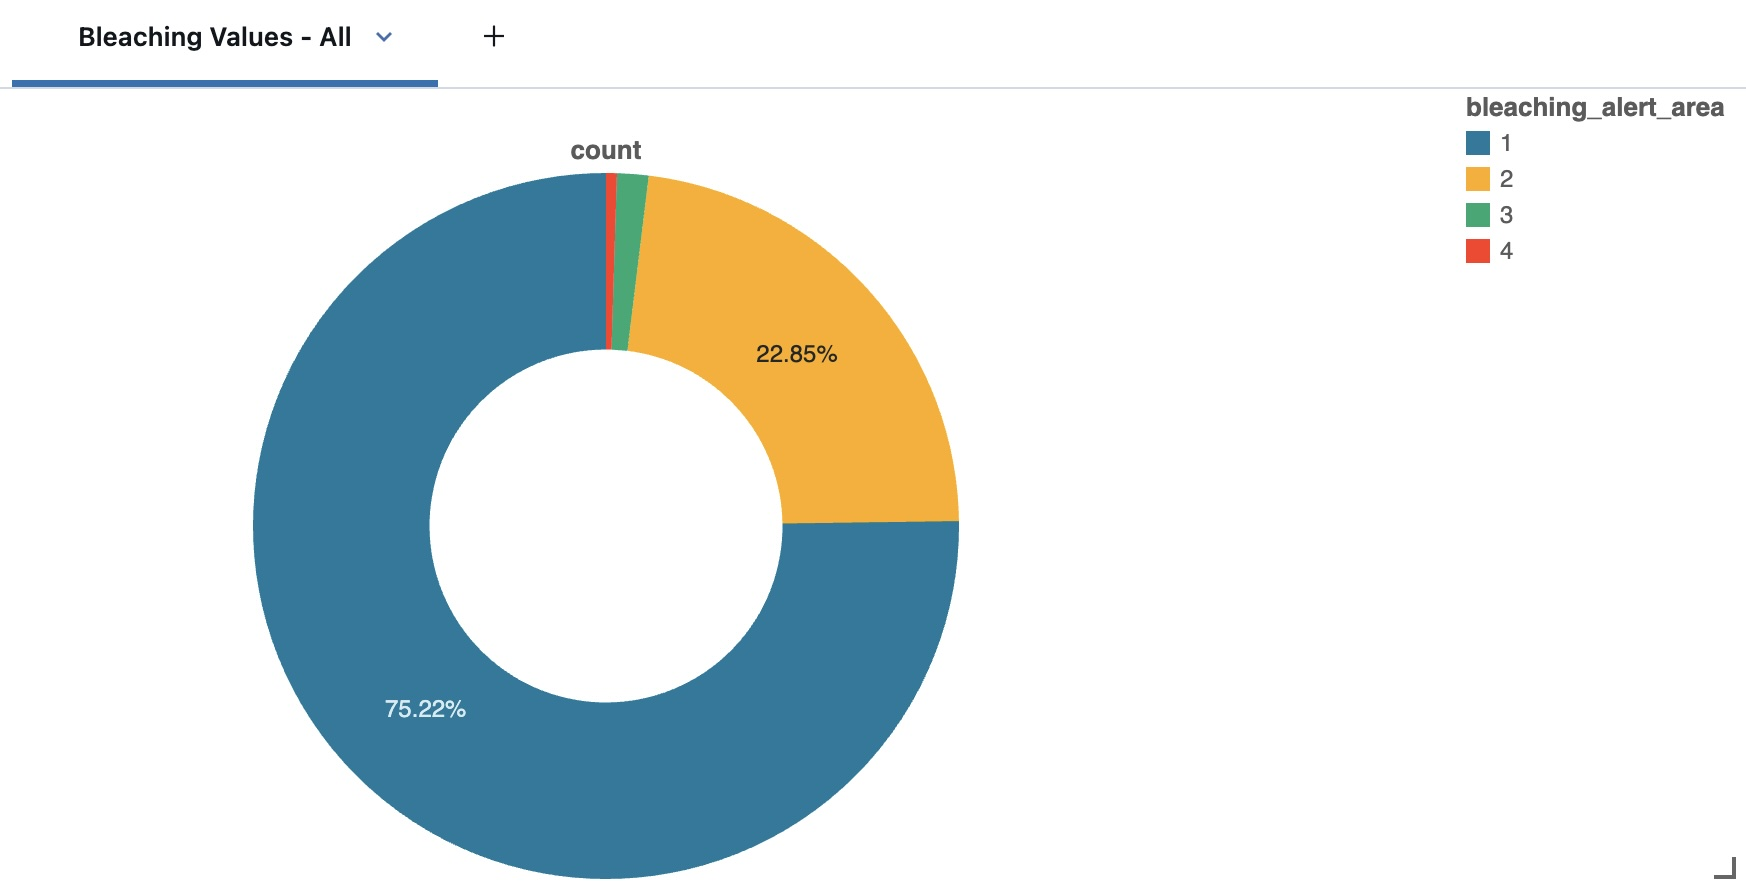

In [0]:
displayHTML("""<img src="data:image/jpg;base64,/9j/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABtKgAwAEAAAAAQAAA3qkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g/wSUNDX1BST0ZJTEUAAQEAAA/gYXBwbAIQAABtbnRyUkdCIFhZWiAH6QACAAsABgAqACJhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAABLxjcHJ0AAAGcAAAACN3dHB0AAAGlAAAABRyWFlaAAAGqAAAABRnWFlaAAAGvAAAABRiWFlaAAAG0AAAABRyVFJDAAAG5AAACAxhYXJnAAAO8AAAACB2Y2d0AAAPEAAAADBuZGluAAAPQAAAAD5tbW9kAAAPgAAAACh2Y2dwAAAPqAAAADhiVFJDAAAG5AAACAxnVFJDAAAG5AAACAxhYWJnAAAO8AAAACBhYWdnAAAO8AAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAnAAAADGhySFIAAAAUAAAB5GtvS1IAAAAMAAAB+G5iTk8AAAASAAACBGlkAAAAAAASAAACFmh1SFUAAAAUAAACKGNzQ1oAAAAWAAACPHNsU0kAAAAUAAACUmRhREsAAAAcAAACZm5sTkwAAAAWAAACgmZpRkkAAAAQAAACmGl0SVQAAAAYAAACqGVzRVMAAAAWAAACwHJvUk8AAAASAAAC1mZyQ0EAAAAWAAAC6GFyAAAAAAAUAAAC/nVrVUEAAAAcAAADEmhlSUwAAAAWAAADLnpoVFcAAAAKAAADRHZpVk4AAAAOAAADTnNrU0sAAAAWAAADXHpoQ04AAAAKAAADRHJ1UlUAAAAkAAADcmVuR0IAAAAUAAADlmZyRlIAAAAWAAADqm1zAAAAAAASAAADwGhpSU4AAAASAAAD0nRoVEgAAAAMAAAD5GNhRVMAAAAYAAAD8GVuQVUAAAAUAAADlmVzWEwAAAASAAAC1mRlREUAAAAQAAAECGVuVVMAAAASAAAEGHB0QlIAAAAYAAAEKnBsUEwAAAASAAAEQmVsR1IAAAAiAAAEVHN2U0UAAAAQAAAEdnRyVFIAAAAUAAAEhnB0UFQAAAAWAAAEmmphSlAAAAAMAAAEsABMAEMARAAgAHUAIABiAG8AagBpzuy37AAgAEwAQwBEAEYAYQByAGcAZQAtAEwAQwBEAEwAQwBEACAAVwBhAHIAbgBhAFMAegDtAG4AZQBzACAATABDAEQAQgBhAHIAZQB2AG4A/QAgAEwAQwBEAEIAYQByAHYAbgBpACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAYwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNQAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAg98AAD2/////u1hZWiAAAAAAAABKvwAAsTcAAAq5WFlaIAAAAAAAACg4AAARCwAAyLljdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuFAAAUewAAEPXAACwpAAAJmYAAA9cAABQDQAAVDkAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoFD9Ym1iAAAAAAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/bAIQAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLCwECAgIDAwMFAwMFCwgGCAsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsL/90ABABu/8AAEQgDegbSAwEiAAIRAQMRAf/EAaIAAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKCxAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6AQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgsRAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/Q/v4ooooAKKKKACiiigAooooAKKKKACiv4mP2T/8Ag4B/4LTftqat42vv2Yv2b/C3jrR/ClxbwzfYZp7SS087zdqySXF6FuHcREgQxqUA5HzLX6o/8EsP+C4/iL9tj9pfxL+w7+1J8K7z4RfFnw3ZyXn2GaVnhuFt/L82MxzRxSwyhZFkRcSLJFlg4wN1ODRKkj+haiv5z/2Ef+ClX7UPx+/4Lb/tBfsK/ES70+XwB8OtN1C60aGCzWK5SS2vLGBN8wOXGyd8gjrj0r+grxH408G+Dkhfxdq1lpS3DbIjeTpAHb0XeRk9OBSasNM6aimRSRzRrNCwZGAKleQQemK57VfGPhHQtSttF1vVbOzvLw4t4J50jklPoisQW/AUhnSUUVzM3jTwdbeIU8I3GrWUerSruSyadBcMvqI87iPwoA6aivxh/wCC8n7bnx3/AOCfv7A9z+0H+zpc2dr4ji17TdPV762W6i8i537x5bYGflGD2r7x/ZC+Oc/xa/ZU+D/xK+JmpWUfinx54O0TWriEMkBnur2yhnmMMWc7d7nCrnaOKdtLiv0Pq2ivzb/4Kq2H7f2pfspS23/BNrX9L8OfEX+1bMtdap9mUNpw3+ckLXiPbrKW8s5kU/uw4XDFSPsP4Paj480X4L+Dov2gdU02bxm2jWC63c2REVncaoIE+1Nbg4/dNLuKDA+UjgUW0Gew0VgHxV4XXXx4TbUrUaoU80WfnJ9o2f3vLzux74xW1NNDbQtcXDLHHGpZmY4VVHUk9gKQEtFc1YeM/B+q6Wdc0vVbO5sg/l/aIp0eLcP4dwO3PtXQwyxXESzwMHjcBlZTkEHoRjtQBJRX89/7WP8AwWN+Lf7H/wDwV8+HH7BPxL8H6Snw3+JX9mDTvEgecXinUi9ooYZ8nKXyBX4+WFgTjOa/Rz/gpt+2tY/8E9f2I/G/7VstnDqd74dt4I9NsJ2Kx3V9eTJbwRnb823c+59vIRSe1Pl2FdH3pRX5w/8ABKr9rr4y/tw/sQeGv2sPjz4d07wheeKpLu4s7GweQxLp0ErQxSuZiSDJ5bOO3llTX394e8WeFvFtvJd+FNStNTiiYxu9pMkyqw6qShIBHpStYZ0FFfzpfHD/AIKUftQeA/8Ag4L+GH/BOnw/eaevw08VaF9vv7d7NWuzN9j1Cb5Z87lG+3j4A6AjvX9DsWq6XNfPpcNzE9zGMtCrguo46r1HUU2rCTNCis99V0uK/XSpLmJbpxlYS4Dkey9e3pVTxB4l8OeE9NbWfFN/baZZoQGnupVhjBPbc5ApDNuiqGmappmt2EWq6NcRXdrMN0c0LiSNx6qy5BH0rN1/xb4V8KJDJ4o1O001bhxHEbqZIQ7noq7yMn2FAHQ0U1GV1DoQVIyCOmKdQAUUUUAFFflT/wAFjf8AgpHF/wAEuv2OLj9oTStMtNc8R32q2WjaJpl47Rw3FxOTJJvMfzhY7eKV+P4go715P/wQy/4KpeIv+Cqf7Met/ED4oaXpug+OvCOstpWsWGlCRLYxyRrLbzxxzSSyIsgLptZ2+aJu2KfLpcV1ex+11Ffzn/8ABT7/AIKVftQ/sq/8FUf2YP2S/hJd6fD4O+KmpaZa69Fc2azTvHdamlo/lSkgx/uicY6HmjxX/wAFKv2odI/4OJfDP/BNqzu9PHww1TQ5L6e3NmpvPOXSLm8BFxncB5sS8Y6cU+UXMj+jCiiipKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor8Y/8Agsd+0N8aP2fv+GZv+FNeILjQP+Ew+OPhTw7rP2cJ/pmlXnn+fbPuU/u5Nq7gMdKaXQD9nKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0f7+KKKKACiiigAooooAKKKKACiiigD/ADa/+Df34lf8FcPAfh/4yW3/AATQ+Hng3xrYT6rYtrUviq4MDwXCrcCBYQt9aZBXcWyD0HIr78/4JJ+Otd8Lf8F3/HOqf8FXtG1Tw1+1H4+sXg0GCOC3Hh9LdbSPCQy28s252tLbyoJAzRbI3RnaZgK86/4Jtfss/wDBx3/wSts/Hmg/s/fs6eGfEFr44voLyeTXtc0yRo2tBKsfl/Z9at/lIk5DDPHav0I/Yu/4Ja/8FM/2iv8AgqNov/BVD/gqy3h/wzfeELVU0fwxokiXADJDNFBEPJlmSKGB5mn3NcTSPJx93ptJrUyS2PEP+CY+uaf4Y/4OXv2yfEmrMUtdO8O67czFRkiOHUNMZsD6DpX4E/BL9pL9gn9v/wCO/wATf2n/APgs7r/j3WfEOsXCQ+HtM8LW5ez06ybftVWTOxYBtSKLYq8M7+YznH9aH7BX/BO39rD4R/8ABdD9pP8Aa7+L/g5bH4XfETSNUstG1Rr6ynF611e2EqobeKd7iMNHDIf3kSAYx1IB+Kfgv+xX/wAFpP8AgiL8Y/Hvw9/4J0eAdG+OHwZ8bXw1LTotUvILW6sJguxBKHurWQSKm2ORh5kUqxqw8piVBdBYx/8Ag2F/a38aX978eP2JtK8Y3958OvBUNzq3gDWfENrtbTrCO4lgd5kZlVEw1vO1t5gSNvMAIyTX5D/HP4Z/8EFND8O/E+6+N37RXjv4/fGnUxf3Np4o0rTZ4rf7dFCfJU+eXiul8xfml+0+U0WAjIBur+tL9lX9ln/grr+0L+yb8cvCv/BUH4h2Om6z8XNB1LQ/D3hnSLez+z+GU1CCaMvJcWibpcGVUWL7RPiKPLSu7/J+NP7FP7G//BwZ+yB+zj4u/wCCc3ws+EfgjQ9E8RS6gsvxHlvrV7hLe9QpI0flXQlmkKjFr51sGjyA4VQCpdXC2iRZ/wCCbH/BS39oX4P/APBs/wDF748z65cX3if4W67N4T8Mahdk3ctrFfDTY7X/AFu4EWr37eUrZRURUxtAWuV/YT/4Nvfg3+3h/wAE4LD9rL4w+OvEUvxp+J9nd69Y6xJeCS0tbh3kFt9oRo5JZxIVV7hy4k+YhCpXJ+9/+CSX/BHH496F/wAEdPjP/wAE9/25dDfwFqnxH8S313amO6s9TaGFrLTha3Q+yTzRHy7q1J8surHZ/CCrV8f/AAP+Ff8Awc//ALFn7Nuof8E4Pgl8OfDuteHbP7ZYaB45j1K1S5sLK8Z2d7aWS/gK7GkLwefa+bEcgKwCBS/YLbXOy/4LJfA79q39mz/g3g0v4HftjeMLPx74t8OeL9MtYtbtJZ5muNP3ytbiZ7iOORpYlJiyQcoikktmvjH9pD/ghj8J7L/giLpP/BR7xP428S6v8XrXwR4c8Sie7ukfT47B4bVINOjh8vckdrZskcTCXO+MH7h2D9av26P+CWn/AAUL8f8A/BDrR/2PZtfv/jn8a5PEdlresXl/q64I3yFooLnVJ4h5NtGUjUFlLkM4Rd20foD+0R+yN+0J45/4ILR/sW+FfD/2r4lr8MNA8OnR/tdsn/Eysra1jmh+0PKtt8jRuN/m7DjhiMUlKwcp/PV/wUR+Ovj79pL/AINT/gx8XvijfTapr15r2n2V3eXL+ZPcNplxqFkskjnlndYAzMeSTk5NcX/wcHwatc/8E1/2CLbQHEV9Jodits54CynS9NCH8DjtX2x8bf8AglT+3t4u/wCDcD4W/sFeHvAf2j4seHPEL32o6F/amnJ5NudQ1KcN9pa5Fo37ueJsJMT82MZBA7r/AIK3/wDBMH9uT9p39jz9jr4VfA7wR/bevfCuxsYfFFt/aWn232B4bKwhcb7i5jSXDwyD9yz/AHeOCM0mtAtofmf/AMFxf+CMXw4/4Jq/syeFP27/AIJfELxbqXxVtvFdnFruu6lfBpr69vY5p2vomRFkhmW4iBX943yscksNx+kv+C7X7Tnx7/at8K/sZfsK6B4hk8NWn7RFhoOo+JriJNsVxcaw9nb24k2lA0MEkssrwghWOwnG1cftb/wcP/sa/tI/t0f8E/ovgj+yx4c/4SjxOnijTdRNl9stbH/RreOdXfzLuWCL5S6/Lvyc8Cvzn/4LD/sKfCbx3+xB+zL4f+LPxZ0H4FfHX4a6Bp9n4bn8Q6iLOzubm0trJL23NzB5m17eeOF454i4jbttfcsp7XBq17H5jf8ABcj/AIIffCH/AIJh/sLWvxV/ZV8deKG0jVNZ07R/FOia3eRTWupkrJLbXapFFCqzwyRkY2t8jnbsAcP/AGl/8EzP+Ub37Pv/AGTXwp/6a7av4fP+C23wk/4Ko6f+xJovjP8A4KmfHPwrrqabqtlD4V8JeGxCJdTupkcS6jcmK3tQ3lW6uFKq6jzOPLyQ/wDcn/wTi0rUtC/4J5/AbQ9Zge2u7L4d+F4J4ZBho5I9Mt1ZSOxBGCKUvhQ47n4D/wDB2l+y/qfjP9kHwX+2f4EV4PEHwd12PzrqElXi07Vmjj35HVo7yO12Z+7vYjHf4H/4Loftnax/wUp/Z1/Y0/ZT+CkqNrnx5fTfE2oW0R4t7ufbp0EbhesaXUt4H/hU2+e3H9n/AO1V8APDX7VP7Nfjr9nDxfhbDxrol7pDyEZ8lrmIrHKo/vRPtkX0Kiv41f8AghN/wQ1/b6/Z+/b48OfHv9vPwkdD8MfC/Q9Qj8L+Zq1hqSG+upJAkUUVpcTNHGv2u6ucsqgSkEfMeCLVvQJLXQ/RT/gt/wDs9fsX+Bv2Yvgv+zh+0d+0XefBL4SeDraHTh4S0nT3v7/xPBp6W8cY2QOXxbpHhZGt5IY5ZQ75OwV/Mj4S+M37Bf7MP/BU/wDZ+8f/APBGzxP4wh0jVdc03SPFNrrm+GK5t7q9ggkhVmCPLFcRM/mI6lUdFZOcBf6Yv+C73/BNH9t348ftc/Bv9v8A/Yq8PaT8RdT+GUVvb3PhHWpoUt5Gsrt7yKby7mSCKVJC5jmUTJLhI9mTyvwt+1J+w1/wXg/b8/a1/Z5/ak/aI+F2gaDovgbxDaMfDeharYr/AGDp9re2k0tzcNNeHz5LlUJCWzSbEgVSisQGqLVhSWux7F+1H/yt6/A3/sVR/wCm3V6P2CP+Vsf9pb/sVbz+ejV9lfHr/gn5+1140/4OOPhT+3l4Z8JfafhP4b0D7FqOufb7JPIn+xajDs+ytOLpvnniXKQkfN1wDj5N/be/4J+/8FWf2Vv+Cw+sf8FR/wDgmj4R0r4jWPjOyig1HSL26htxCXtobW4hnjmurV3R2gS4jkik+R+GXanzpNWt5BYyP2o/+VvX4Gf9ir/7jdXr8i/21/2u/wBmD9tv/gsr8S9A/wCCnev+L5Pg/wDCu81Tw/4Y0Dwrbl1afTbkWrmQKd0YmZZJnlC+Y+ETciqq1+sP7Pn/AATx/wCCx/jj/guH8Lf+CkP7bHhHSE037FNLrMuh6hZix0BG068tILBIGunupShaMu8aypvlbDsqlq9V/aC/4J8f8FNv+CdP/BSfxn/wUH/4JSeGtL+Jvh74t/aJ/FPhXVLiG2eC6u5ftE5Hmz225WnzLDJE5dC7I0ZQZZpoLH52/wDBBH9qz4ffBP8A4LBa7+xh+xpr/ijVv2ffiHa3U+m6f4mtvLnsdStrE3wfA/1ZAhmg34j85Nm9WKI1fGXxnX9m3Qv+Co3xvb/g4M8P/EC5k1zU7mHwZqWmPILG009biYxvD86vJapA0IthB5iJ8wkjLH5f64P+CcWkf8FyPir+0frP7Qn/AAUc1PSfhv8AD4W8kOlfDfR47G6MkzKESWW6j+0zIiDLkfay7y/wRxjYfi/4s2//AAcW/BP4r+Ofhx4n+HnhL9rz4U+IJnXQm1pdH04WkDF/KS4gH2HcdjBZxJFJGSo2SKCcl9QtofYv/Bvv8PfgP8Nf2Xde8P8A7Lf7Qlx8dfh9/aaPpdvfWj2V14cZkPmWjRSyGSNZBscIYoU3B3VTvOP0s/by/bR+HH/BPn9l3xD+1f8AFjTdS1fQvDcllHcWukJE925vrmK1TYJpIkwHlBbLj5QcelfkN/wb1f8ABKf49/8ABO/wr8Tfir+0vFpmh+Kvire2U3/CNaNKJbPSLWwa5ZI9yFotxa5YKqPIscaqA5JYD+jeSKKZDFMoZT2IyKzla5cdj+ar9lX/AIOif2JP2uP2i/B/7NHgLwP440/WfGmpRaZZ3N/b2C2sUsvQyGO9dwvHO1Cfav6WaqR6fYROJIoI1YdCFAxU8rtHEzohcqMhVxk47DOB/IUnboNH8NH/AAXu/ab+CHx1/wCCzHwE/Yz+OHiay0H4YfCu5tdb8YXN6x+zC4vNt5JBKFB5azggjjODg3JGMdef/wCCY/7YP7OvwR/4OOPit8Ov2cPFdn4i+FP7QjyzWd3Zb1tV1maIami/Oqfcne7to1UFf3qgYwQPsj/gmb/wRh+Lfxe/bN+Pf7af/BYj4SaXNd+N73zfDmiaxdWGtwxpeTySysFtZriNPs0UdvbwliG2FgOOr/8Agsb/AMEMvFVp4l+Dv7Sn/BHD4V6No3jzwFrwur7T9IkstHilWBo7m0un+0zW0LG3mh2EK3mMJRwVX5dbr4TOz3OD/wCC5v8Aynp/YZ/7DWh/+nyKjx//AMrjngj/ALFeX/1Hr2vq3/gpf+wZ+2p+1Z/wVH/ZA/az+G/gFm8L+ALrRL7xa8mp6ejaQYdSiu54yj3KvOYow3NusgbHy54rf8X/APBPr9rvVP8Ag5U8Lft/2PhLf8I9N0GSyuNd+32Q2Tto11aBfspnF2f30iJkQ45znaCQk1b5Dsf0wUUUVkaBX4NeMfGPx9/4JZ/Hy/8AG/je/wBS8d/A/wAd6k1xdXVwxuL3R724PJJ/kOFlUYGHHP7y1zPjLwb4V+IXhW/8EeN7CHVNI1SFre6tbhd0csbdQR/LuDyK9DL8ZGhJxqw5qctJLy8n0a6HLisO6iThK0ls/wDNdj8QPBvjH4+/8FS/j5YeN/BF/qXgP4H+A9SW4tbq3Y297rF7bnggj+XKxKcHLnj95a5nwb4N8K/D3wrYeCPBFhDpekaXCtva2tuuyOKNOgA/ySeTXTUY/GRryjGlDlpx0ivLzfVvqGFw7pJucrye7/yXRLoFFFFeedQUUUUAFFFFABRRRQAUUUUAfn/+3R/w882+F/8Ah3B/wrrP+m/8JD/wn/2//pj9k+yfYf8Atv5u/wD2Nvev5if+Cs//AA/L/wCMdv8Ahqn/AIU1/wAll8M/8Ip/wjX9r/8AIx/vvsf277R/y5fe87yv3vTbX9u1fjH/AMFjv2efjR+0D/wzN/wprw/ca/8A8If8cfCniLWfs+z/AEPSrLz/AD7l9zL+7j3Luxnr0q4Mlo8aX/iJ5yN3/DOmPb+36/oBooqWygooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr4/8A20/2D/2Xv+CgnwpX4O/tS+Gk17S7eYXVnKkj293ZXAGPMt54yroSOGGdrDhlI4r7AooA/nr+BH/BsN/wSh+BnxCtPiNJ4c1jxlPYXIuraz8S6gLuwR1+6rW8cUKTID/BMJFP8QI4r+hGOOOGNYolCqoAAAwAB2FPopt3EklsFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1P70f+E28Gf9Bey/7/x/41/PX/wXi8GeMPi//wAKq/4VLpN54o/s7+3PtX9kQPe+R5v2Hy/M8kNs3bG25xnacdK/oU/4QnwZ/wBAiy/8B4//AImj/hCfBn/QIsv/AAHj/wDia9TKcx+oYuGKhG7jfT1TX6nn5lgfrmGlhpOydvwaf6H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE19r/xEWt/z4X3nyv+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H+ev8A8MxftJ/9E98S/wDgpuv/AI3R/wAMxftJ/wDRPfEv/gpuv/jdf6FH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0f8RFrf8APhfeH+o9L/n6/uR/nr/8MxftJ/8ARPfEv/gpuv8A43R/wzF+0n/0T3xL/wCCm6/+N1/oUf8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0f8RFrf8+F94f6j0v+fr+5H+ev/wAMxftJ/wDRPfEv/gpuv/jdH/DMX7Sf/RPfEv8A4Kbr/wCN1/oUf8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNH/ERa3/PhfeH+o9L/AJ+v7kf56/8AwzF+0n/0T3xL/wCCm6/+N0f8MxftJ/8ARPfEv/gpuv8A43X+hR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR/wARFrf8+F94f6j0v+fr+5H8cP8AwSq+C/xi+Hf7evgPxh4/8J6zoWkWf9qefe6hYT2ttF5mnXKLvkkRUXczKoyRkkAV/Y9/wm3gz/oL2X/f9P8AGj/hCfBn/QIsv/AeP/4mj/hCfBn/AECLL/wHj/8Aia+Tz3Ov7Trxrzhy2io2Xk2/1Po8oypZfRdGErpu/wCCX6B/wm3gz/oL2X/f9P8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE14vuHq6h/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gah/wm3gz/oL2X/f+P/Gj/hNvBn/QXsv+/wDH/jR/whPgz/oEWX/gPH/8TR/whPgz/oEWX/gPH/8AE0e4Gof8Jt4M/wCgvZf9/wCP/Gj/AITbwZ/0F7L/AL/x/wCNH/CE+DP+gRZf+A8f/wATR/whPgz/AKBFl/4Dx/8AxNHuBqH/AAm3gz/oL2X/AH/j/wAaP+E28Gf9Bey/7/x/40f8IT4M/wCgRZf+A8f/AMTR/wAIT4M/6BFl/wCA8f8A8TR7gah/wm3gz/oL2X/f+P8Axo/4TbwZ/wBBey/7/wAf+NH/AAhPgz/oEWX/AIDx/wDxNH/CE+DP+gRZf+A8f/xNHuBqH/CbeDP+gvZf9/4/8aP+E28Gf9Bey/7/AMf+NH/CE+DP+gRZf+A8f/xNH/CE+DP+gRZf+A8f/wATR7gah/wm3gz/AKC9l/3/AI/8aP8AhNvBn/QXsv8Av/H/AI0f8IT4M/6BFl/4Dx//ABNH/CE+DP8AoEWX/gPH/wDE0e4Gof8ACbeDP+gvZf8Af+P/ABo/4TbwZ/0F7L/v/H/jR/whPgz/AKBFl/4Dx/8AxNH/AAhPgz/oEWX/AIDx/wDxNHuBqH/CbeDP+gvZf9/4/wDGj/hNvBn/AEF7L/v/AB/40f8ACE+DP+gRZf8AgPH/APE0f8IT4M/6BFl/4Dx//E0e4Gof8Jt4M/6C9l/3/j/xo/4TbwZ/0F7L/v8Ax/40f8IT4M/6BFl/4Dx//E0f8IT4M/6BFl/4Dx//ABNHuBqH/CbeDP8AoL2X/f8Aj/xo/wCE28Gf9Bey/wC/8f8AjR/whPgz/oEWX/gPH/8AE0f8IT4M/wCgRZf+A8f/AMTR7gah/wAJt4M/6C9l/wB/4/8AGj/hNvBn/QXsv+/8f+NH/CE+DP8AoEWX/gPH/wDE0f8ACE+DP+gRZf8AgPH/APE0e4Gof8Jt4M/6C9l/3/j/AMaP+E28Gf8AQXsv+/8AH/jR/wAIT4M/6BFl/wCA8f8A8TR/whPgz/oEWX/gPH/8TR7gan//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5t/8Agr/+0L8WPg3+3B8GNJ8K+N9W8LeHLpLObVYLTUprKyliF/tka4VHSNl8sYYuMbeDxX9JFfybf8F9NM8O61+2L8JNG8XXJs9Ju9MihvZxwYrd71lkcf7qZP4UAfs34E/4K9f8E/viJ8SYPhd4d8dKt9eTLb2txdWdxbWc8rcBVmljVF54BfYpOApORX54/wDBaP44fGn4W/tO/BbQPhl4v1vw5YaoT9sttL1CezhuP9LhX96kTqr/ACkj5geOK8D/AOC6P7IP7K/7PXwS8A+Jfgx4bsPC2tPqjab5Vinl/a7JYGd3l/56PG6xje2WPmck9vIf+CkPiDxF4sb9jrxT4vlefVdS8K6PdXcsp3PJPKbRndif4mJyfegD+l39qD9uj9mH9juCzHx38Sx6be6ghktdPgje5vJUGRvEUSsVTIIDvtQkYBzxVL9l39vj9lf9sSW7034F+Jlv9TsIlnudOuYZLW7jjJxuEcqrvUHAZoy6qSASMiv5dP2orf4ufFv/AILP+J9L0XwTZfEnVtLu/KsPDGszpHZXFraWIKAiWSJNir/pHl7sM2cggsD6/wDBP9lP9tXwf/wUm8GftAD4V6J8MbRtXsxf6TpGqacltBZTqLa6aK1F2z4eFnbZGh+b7q9qAP3k/aH/AOCp37E/7Mfjef4a/EnxU0uv2e37TY6day3jW+7tI8a+WrAclC+8DGV5Fe9/s1ftdfs9ftdeGbrxT8AvEUWtw6e6R3kPlvBc2zuMqJIZVR1DYO1sbG2naTg4/l28Kaz4V+M/7X/xG1j9g34D2/xf1K4u7ua/1bx3cRX2nb7qdne4S2kFtDAJHDeVvmaRoxwF+ZR5v/wTB8QePPhRpv7Utxokn2HWNE8AavMPsLgJBd2ZcLJEV+X9ydzIRxgcUAf0WfFj/gsF+wL8HfHVz8O/EPjFr7UbCYwXZ0yzmu4IJF6qZY08tivQiMvtPBwQQOJ/4KC/tTaD46/4JceNf2h/2VfGU3lkaYLLWNHnltLmFjqVrHImR5c0L7GKujBW2nBGDX5hf8EV/wBkX9lH44/sg/Efxt8ddB03Vb6XVLnSpr2+RGk06whs4ZBLA7g/Z3DSyN5qYPyDnC10Hxg+C/7JHwQ/4JO/HTw3+yL8Rp/H2lXV5oFzfCW6t7lbO4OoWqDb5EUW0yKoznOdgxjFAHtn7EH/AAV2/Zr+D/7HXw+8PftQePdR1rxxcpqEmovIlzql3EjahdCE3M2HIPlBNqFi4j2HbtK19t/t2fGj4ffFj/gndq3xg+EnxQ/4RPQtUbT5LTxVp/2stCPtkSlNtov2lWYgxOm0FDlXAwRX5Sfs4/sffs6a5/wQ48R/GbXPCmn3nizUNG1/WP7Ymt0e+gn0y4njgEM5G+JAtsmUQhWy2R8xr5l+E13c3P8Awb+fE6Gdyy2/ji3jjBPCqZdMbA9BlifxoA/dn9nD9rH4Kfsvf8E8vh78Vvj78SbjxPpGoXNzp0XiaW1v7iW+uXuLuRVKSRvcjYkToDIoGIxjgrVnXv8AgtR/wTt8P+ILTQZPGst0tzDDM11a6fcy28InRXUORHncFYb1VWKHKsAwIH4cftK/8oAvgb/2N8n/AKFrNfQH7T37HP7OXgP/AIIh+GPix4b8Kadb+K/7H8N60+tJAov5LjVXgM6vPjzGjxcMFjLbFAXAG0YAP6P/ABV8ffgx4J+DrftAeKPEllaeDBZx366sZN1vJbzAGNo9uS5kyBGqAs5ICgkgV8DaJ/wWq/4J161b6pdHxrLZppSrIftOnXSNcIzrHmBREWcguCUwHCgtt2qxH88f7VfjLxh/w50/Zs8MJNI2l3+o69Jdc8GSxu547ZT7BJHwPb2Ffdn/AAUF/Y3/AGL/AIaf8EpPDnxS+Guj6bZ67bW+hy6ZrNvtW61WW+8vzhLIOZt8TSTbTkJs+UKoxQB/Rp8E/jR8Of2hvhhpfxi+Et8dS8PayJTaXLQyQFxBI0L/ACSqjrh0YcqOnHGK9Ur8xf8AgjX/AMo2Phn/ANctU/8ATldV+nVAHzD+0x+2R+zj+yDollrfx+8SRaL/AGmzJZWyxyXFzcGMfMUhhV32rwGcgIpIBIJFeNfs3/8ABT/9jH9qjxlF8OPhb4oK+ILhWa30/ULaW0lnEYy3lF18t2CgnYrbsAnGAcfkx/wV28X/AAJ1r9tXwL4F0/wHqnxR+J9taWcVto7Xvk6OiNM80MUtusTNcNLljMPMjQRBdzEZA/Oi48O/GbwP/wAFYvhC/wAYPAfh74X61qGueHpl0LwukMNnDayXfkgstvJKgkkCtv8AmyQRwOlAH6h+F/jj8arj/gv7qPwbn8X62/hBPN26G1/OdNGNDEoxbb/JGJPn+797nrX6dftH/wDBUH9i/wDZZ8ZN8Ofih4p36/CENxYadbyXktsH6ecY12Rtj5tjMH24O3BFfjn4S4/4ORNUx6Tf+o+K/Mj9hbRP2gvjL8bPH/xL8LfB/Q/jXr0jNLqtt4mmg8u0lv5ZGeURXE0QeRmVhuwxj/2dwoA/s1+DX7Xf7O37QPws1D4y/CHxLDrOg6Qkr30iRyRzW3kKXYSQOiyqdoJUFPmHK5FfI95/wWZ/4J523hSLxZaeNZLtJ7s2UdrFYXQumkVUYnynjQiMB1+dsKTwCSCB+PP/AAT/AP2Y/wBqr9nv4u/GHWfHfhe08KeF9e8Ia+lzpttq1leLayp+8t4xFDcyzfufmjVnXgEgnJrm/wDghl+w/wDs6/tJeHvGvxO+Omgp4jn0W9tbLT7e4kkWCHKGR3KRsodj8oG7IAHA5oA9ub/gtOkf/BSprd/iIv8Awzsvy7v7HOcjS/8Ar0+3/wDIQ46dP+mdf0/2tzBe20d5bHdHKodD0yrDI/Sv5Lz8GPg9J/wcMv8ACKTwnozeEzydFNhB/Z2f+Eb8/wD49tnlf6395937/wA3Wv61I444Y1iiUKqgAADAAHYUAPr85fj7/wAFXf2Hv2cPHN18M/H3ixrjXdPcR3lpptrLefZn6FZJEXyg6/xJv3r0Kiv0ZJVV3NwBX8aPwp1HQ/jd+0X8RNX/AGAvgHa/Fia6uZJL3W/iDPFqFqDdyyP9oWCUWsVuZ2DlVaV5WReMfMtAH9Qvwi/bX/Zl+Ovwi1v44fC3xPFqnh/w1BLcaqyxSpcWaQRmV/Mt2QSj5FYrhCHwdmcV81r/AMFiv+Cf1zounaxpHjOS+bVdROmW9rDYXIuTMojJZo3jQpH+9QB2wrHIXJVgPwA/4JDC/wBM+Ef7VWhTOAqeBbnzEjYNGXihvFBBHBxk4I7GvdP+CFn7D37Ovx7+H3if44fGbQk8QanpGtxWGnR3Ekiw23kRRzGQIjKGZmkH39wAUYA5yAful+0t/wAFMv2OP2T/ABX/AMIB8WfFH/E/RUeXTdPgkvJ4FcAr5vlgpESpDBXYMVIIGCK9w/Zy/as+AP7WXhOfxn8AvEUOu2lnIIbpAjwT28hGQJIZVSRM4O0ldrYO0nFfxpfsqaX+0B8Zf2vPiR8QvDXwk0X4y+IfPvZtR0zxLNAYbRrm5OZRHcTRK7KV8scMEB4A4r7i/YE+An7Rn7KH7UPxC+MHxo8OQfD7wDd+Htfl1y20rVbK6fS7RFNyqwQw3M0+6AoFiOxmUcHqaAP2J+JH/BZX/gn38MvGNx4H1LxjJqV1ZTGC4l0yynuraN164mRNkgHTMRcV94/BX45fCb9or4f2vxR+C2twa/od2zIlxBuUq6feR43CvG44yjqrAEHGCK/jS+Feg33xG+BfxNvP2NP2d9Lv/BSW97FqHi3xpcQajf6dDDblna1lk+ypDNHERMFhWVkcqSWAWv1m/wCDcy6uX/Zs8eWLOTDH4lV1TsGe1iBI+oVfyFAH9D9FFFABRRRQB//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/JH/goP/wAEq9N/b7+K3hf4haz43k8NWegWQsZ7OHTxcyXERmMjFJjOgiYg7RmKQA84PSv1uooA/nR0/wD4ILa/4r+IOiXf7Q3xq1fxx4R8O7Y7TTZ4JVn+yr/y7JLLdTLbx8KD5S8qOAhwR9u/twf8EybH9sX4mfD3x9pvi5PCNt4AQRxWMemC6SZFljkVVYXEIiACbQArcfTFfqjRQB+Pv7dX/BJrQ/2pfizaftHfCDxhdfDr4g2yxLLf2sZZLg267YpMxvFLFMq7U81XPyKBt4zXKfsc/wDBH+H4IfHZP2o/2jfHt58S/G9sfMtJblXEcM+wx+bJJNJLLcOqYEZbYE67SQpX9raKAP55Lf8A4Ie/Ej4e/F3xB4g/Zw+N+qeAPCniV2+02enwSpeJbl94t/MiuIlkVckI5AKg4w3Ofor9iX/gkTov7GHxY8W+LLLxqPFXhbxZpl1o8+h6hpSpJ9kmkVkWS5W4KyFUGx/3CrJknavAH7I0UAfzX+Iv+CBvjzw14i1zSv2d/jTqHhfwZ4mPlX2mSRTb2tRnEMxgniju1XcdokRODj1J+6bL/gk18NfC37AfiH9h/wCH/iCXT7jxXNaXmqeI7i1FzLNd21xBOW+ziSMCPEAjjjEmEBySzbi36z0UAfn58Lv2FP8AhWv/AAT1uf2Dv+Ep+2/aNI1jSv7c+w+Xt/tWa4l3/ZvOb/V+fjb53zbeq5wPmHwf/wAEhR4U/YA8VfsMf8LC8/8A4SbXY9b/ALb/ALJ2eR5ZtT5X2b7Ud2fs33vOX73Tjn9oaKAPxw+JX/BJb/hYf7APgb9hn/hP/sf/AAhertqv9t/2V5n2ncbw+X9m+1Ls/wCPv73mt9zpzx9H/Gj9hf8A4W/+wFpv7DX/AAlH9nf2do+h6T/bf2Hzd/8AYxg/efZvOTHm+R93zfk3dWxz+gFFAH4BftdfAD9mH9j7/gmJ4S/Zj/aquNc8T6LpupTQWHiDQLCKO5tNRuJLm6il8ma4Koux3iILsHGfukjH8/vxq+Fv7Hng/wDZsj8QeA/jlqfxA1q4MA0Lww+mSacNLaV1e5e6V5p4wVjDJiIqGkIZS6iv72fGHgzwh8QvDV34M8e6Xaa1pF+nl3NlfQpcW8qgggPG4KkAgEZHBFfJfhH/AIJvfsKeBfESeK/DXwu0KO/ikWaN5bf7QsciHKsiSl0Qg8jaoxQB8U/sI/tBeGf2Qv2HfhR8L/it4f8AFE2qXeiy6wo0rQrzUYkt9QvLmaIPJbxuquUIOwkMFIJAyK+qP+HlHwP/AOhZ8ef+Elqf/wAYr9CKKAPwq/ac/wCCdSft8fETwz+3J+zn401T4beJDDHGf7R06e1ud1jI0ccwRmhnglULtwQVdAhG0ctyGlf8EPPF2n/HXwn+0jqfxv1DXvF2gahZarfXetaWb77ddWMwkjAJvUeOLy0SLYWkI2khgCFX+gSigD8uNI/4JrDSv+CkV1/wUH/4TTf9p3/8SD+zsbd+nix/4+vtHbHmf6j/AGfevlr48/8ABFbWL744at8ef2OfifqHwt1DX3le+tLUSxopuGDTCCa2lhdInYbvJIZQ3QqoVV/eyigD8kf2M/8Agk14C/ZO8JeMri/8S3Hifxv430y60q712eDy1gt7rJZYofMdjufa0jPKS5RcbORXqP8AwTi/4J+/8O/PA/iPwZ/wlv8Awlv/AAkF9Fe+d9g+weT5cfl7dvnz7s9c5H0r9HaKAPxO/a//AOCRfiT49/tUS/tb/BT4pXvw78S3cUCTyW1u7ypJBbi18yGeK4gePdAoRl7jPODivrK8/wCChfwd8L3kvhnVNA8cXVzpztayzReFdSkjkeE7GZWWEhlJGQQcEV9/0UAfBOi/8FDvgp4l1i08OW/hvxsr380dspn8K6jHEDKQo3s0AVV55J4Ar8zvDv8AwQy+JHwx+IWvp8CPjnq/gvwR4kYLeWNhDKl69qrEpbvJHcRpJtVmVZWXgMfkIJB/onooA/FH9lb/AII9N+ysnxQ0Tw78Rjqmi/Efw9e6CLefSAk9mJwywymZbrbKYkdgyiOMSE5GzGK+p/8AgnR+wj/wwF8Kda+GP/CU/wDCWf2xqzap9p+w/YPLzDFFs2edPn/V53bh1xjiv0HooA/CX9pD/gjJqfij48ap+0b+yJ8S7/4W67rryTX8FqJUQyzkGZoZraWGSJJGG94yHUseCq4Uen/sj/8ABHX4Ufs++HPG0vxQ8Q3njnxP8QNKvdF1PVJE+zeXZagP34hUvK3myHlpndmJAwF+bd+xdFAH85Xw8/4IVfFPwdZav8Kn+PesWfw11edp7vRtLt3tje7l2YmX7QYQdoQMdjhwoBUYXH6G/wDBOD/gn7q3/BP3wr4m8GSeNU8X2Ov3UF7GBpn9nvbyxoY3yftM+8OuzAwu3b3zx+lFFABRRRQAUUUUAf/X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor4T+LH/AAUK+CPwb/at8MfseeKbDWJfE/ixbM2dxbQQtYp9tkeKMSO0yyDDRnO2NsDH4AH3ZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX85P7eX/BXv9pT9l39q7xV8CvAGh+GbzSND+w+RLqFtdSXDfabOC4be0d3Ehw0hAwg+UD61/RtX8Ov/AAWD/wCUi/xE/wC4R/6bLSvouGcLRr4qUK0brl/VHyfGONr4XBQqYefK+ZLTtaX+R9L/APD/AJ/bF/6Frwb/AOAd7/8AJ1H/AA/5/bF/6Frwb/4B3v8A8nV+HVFfc/2HgP8Anyj82/1jzP8A5/s/v7/YN+P3jH9qL9lHwr8dfH9tZWer659u8+HT0eO2X7LeT267FkeRhlIlJy55zjA4H17X5o/8EfP+UdHw7/7i3/pzu6+3vjP8NJ/jD8MtU+G9t4i1fwm+prGo1XQLj7JqNv5civ8AuZdrbCwXY3H3SRxX5fmEIwxVWEFZKTS9Ln7NldSVTBUKk3duEW/uRmaJ8f8A4QeJPjTrP7O+h6ylx4x8PWUOoajpyxS5t7efb5bNJs8rJDqdgcsAQcYr2Ov53/8AgnX8DdK/Zw/4Kw/G74Q6NrGp6/Dp3hywmOoaxMJ76eS8FncO0siqgY75CAdvTGeea/ogrkO8KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/n8/wCC3f7Zvxt+D8vgv9mb9nrU7jRNb8abp7y+sn8q78kyCCCGGQfNF5km4s6FWGwAHBYV/QHX89f/AAXA/Y7+OHxR1TwP+1D+z3pNzrureDgba9s7GPzrtYklE1vNFEvzyBJN4dUBYbgcbQxAB4Bqn7CH/BWj9jX4g+E/iL+zt471P4qPcH7RrdhJe+RZrJGULQTR3t1tnjmBIWVQsgwThDtJ2f2+fj7+07+1t/wUO0n/AIJ0fs/+KLrwNpNt5KahcWszQvLMbT7bcSSvAyu6QQHYsAcI0qnJ5UrRuP2wf+Cr37eXxO8J+APgP4O1b4OWNlui1zVGt3a0LMU8yWSS6t0CCIKTFboTIdxGW4K637fH7Ov7Un7Kv/BQrSv+Civ7N/ha68c6bc+Q1/aWkDXEkUy2n2K4jljhUyCOaBd4nClUkY5AwoYA+ePijcftZ/8ABFT9pHwNc6l8StQ8f+APEoZrm1uvMSKeCCSMXcYtpZp1imjWRGimR8knB+Xcp+ovj58Z/i5pv/Bdbwb8M9I8V6vb+GLl9L8zSob6ZLCQSWrM2YFcREMeT8vNfM/xQ0T9sL/gtB+0p4Ij8S/DLUfh38P/AA1lLi4vFl8qCCaRDdutxNDAJppFjRI4o04wM/LuYe4f8FQ/gl+018G/+Chfg/8Abp+Cfgu+8ZaTYxWE0kWn28lyI57DMckMywq7RJJFt2SFduSQOVxQB2H/AAVX+Mnxe8C/8FK/gd4N8E+KtY0fR9SXRvtdjY301vbT+ZqkiN5kUbqj7kAU7gcqMdK8L/bo8eftdeK/+Cvh/Z0+AHxE1rwuNdj0+xgjhvp1srVLqwH2iUW6ts3LGXkBVQwcBlKsAw8k+Nlr+3j+2T+3P8Kv2lPH3wU8ReF9Dtr/AEa2s4IbG5uVtLGzv/MkkupPKUxnc7tukjiHlhSAVG4/cnxE+Bvxrvf+C9mg/GGy8H63L4RhFtv1tNPnbTU26U0ZzchPKGH+T733uOtAHx39n/aq/wCCZn/BTD4b/BfUfinqnjjR/GNzpL3n2t5hBc2mqXbWcoktpZ5lEsZRmjcOT905GStea/tx/s2/E+y/4K3+G/hhN8TtXn1XxrqFpfaZrjeb9p0OHUbyfybe3/0jdstcfu9kkQ9FWvv/AP4Kb/Ar42+Pv+CqPwQ+IfgXwdretaBpMfh4Xup2Gnz3FnbeRq88knmzRoY49kZDtuI2qQTxXJ/8FV/hv+0R4B/4KPfDf9rz4bfD/VvHGiaBZ6ZKU0u3lmVp7C6mkeCR4Y5TCWRl2syEc8A4IoA/o7+F/hPV/AXw08O+BfEGrz+IL/RdMtLC51S6z599NbRLG9xJuZzvlZS7ZZjk9T1ruq4L4V+MNT+Ifww8OeP9a0mbQbzXNLs9Qn0y5z51lJcxLI0Em5UO+ItsbKqcjoOld7QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8Ov/AAWD/wCUi/xE/wC4R/6bLSv7iq/Kv9pH/gkJ+zX+1F8aNZ+Ovj/W/Etnq+ufZvPh0+5tY7ZfssEduuxZLSRhlIlJy55zjA4Hu8P4+jg8RKpW25baeq/yPmuKcrr4/CRo4dK6kn20s1+p/E3RX9ef/DgX9jr/AKGXxl/4GWP/AMg0f8OBf2Ov+hl8Zf8AgZY//INfYf604Du/uPgf9Ssz7R+8+l/+CPn/ACjo+Hf/AHFv/Tnd1+l1eHfs3fAHwd+y78FtG+BXgC5vLzSND+0eRLqDpJcN9pnkuG3tHHEhw0hAwg+UD617jX53jasauIqVIbNtr0ufq+XUJUcJRoz3jGKfySR+QnwH+GnxH0f/AILDfHD4m6t4f1K18Nat4c0iCx1aW0lSxuZY7exV0inKiN2UowIViQVPpX690UVzHYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorz/xJ8WPhZ4MVn8YeJdK0lUJVjeXkMABUgEfOw6EgV87+I/+Chf7D/hVJJNT+KXh2URdfsd4l4fu7uBb+Znj078deK2p4arP4IN+iOapjKFP+JUivVpH2RRX5qa3/wAFfP8AgnpokZz4/F3IACI7bTb6QkE46/Zwgx6Fhx+FeZa5/wAFvP2ENJQtYajrGpkKDi20116nGP3xiHHX0x09K6o5TjXtRl9zOOeeZdHfEQ/8CX6H68UV+Ln/AA/f/Yn/AOfLxP8A+AEP/wAkVm23/Ben9j281D+zrXw94vckkK/2OzCkL3Gb0HHHHAqcRlmKoUp161NxhFNt9Ekrt/JG2AzTCY3E0sFhKilVqSjCMVu5SaUUvV2SP21or8cbb/gt9+yXPMsUuh+KoVP8b2lptH/fN2T+Qr0LTP8Agr9+yXqIV3i122RkDhpLJMc44+SVj+mK+fwub4LEtqhVTsfR8T5JjuHKdOrnlF0IzdouWibXRfI/Uyivzv07/gqb+xfetGtz4iurMOMky6fckJx0Plxv9OMj8K9A0X/god+xlr0iRWPju0jL9PtENxbDrjkyxIB+OOOeldyqw6SR8rDPctl8OJh/4FH/ADPtCivDdE/ab/Zx8RoraJ488P3BYhQi6jbh8k4A2lwwzjjjntXtNpeWd9CJ7GVJo/70bBh+lXzI9GlXpVVelJP0af5FmiiimahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVxOr/Ev4ceH9Qk0jXtf02xu4cb4J7qKKRdwBGVZgRkEEcdK7avxP/a4/5OF8Qf8Abp/6TRV8N4gcWVeHsup42jTU3KahZ6KzjJ9P8J9JwtkdPNcVLD1J8qUb6eTS/U/Wj/hcnwh/6GrR/wDwOh/+Lo/4XJ8If+hq0f8A8Dof/i6/Aeivx/8A4jtj/wDoDh97Pvf+IaYX/n/L7kf0XaRrOj+INOj1fQbqG9tJc+XNbuskbbTtOGXIOCCOO4rSr5v/AGRv+TevD/8A29/+lMteN/8ABR39rfXP2Nf2bZviP4M05NU8SavqFvoeiwS5MX227V2VnAwWCJG7BRjcQFyAcj+hskx8sbl2GxslZ1IQlZbLminb5H5VmOGWGxVXDxd1CTj9zsfelFfz5/Hz4hf8FV/2Dfh1pf7Uvxf+I2h/ELQba8tYvEPhpNLgs0gS6YJi3uYoo5H2sdob5cMVYo67hX76eHtbsfE2gWPiTS8m21C3iuYdwwfLlUMuR24NemcZsUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorhfH/xP+G/wp0b/AISH4m69p/h+x+YLNqFxHbIxRSxClyNxCjOBzinGLbtFEylGK5pOyO6or8efjV/wW4/Y1+GUdxY+BZdQ8b6jHuVE02DybXeACN08+z5DnG6NJMY6YxX5BfGb/gu1+1j45vHh+EtjpfgawDZj2RDUbzG3GHluF8lgDyNtunTuOK9rC8PY6t9jlXnp+G/4Hz2N4ry3Dae05n2jr+O34n9f088FrA9zcusccalmZjhVUdST0AAr48+Lf/BQX9jL4I/aYPHnxC0kXdo/lS2djL9vukk5+RobYSOh+XB3BQvGcZFfxBfFL9pv9oX42TPL8VvGer64kjFvJubpzACd33YQRGo+dgAqgAHA44rwyvfw/B0f+X9X5Jf1+R8viuPp7Yail/if6K35n9c/xM/4L3/sveGXltPhr4e1zxRMmNsrpHYWr8jozs8o4yeYR2HfI+CviF/wcA/tBazI0fwy8F6FoMJx/wAfrzahKMEnhla3TptHMfY+o2/gbRXs0eHMBT/5d39f6t+B89iOLczq/wDL3lX91Jf8H8T9HfHX/BWj9vvx4j29x48l0uBwy+Xplrb2hUMc8SJGJRjgA78gfjn458dfHj43/E93f4j+MNa17eSxW/v5rhcsNpwruQBjjAGMcdK8oor1KWEoUv4dNL0SR4tfHYmt/FqSl6tsKKKK6TlCiiigAroPC3/Idg/4F/6Ca5+ug8Lf8h2D/gX/AKCa+e4u/wCRFj/+vNT/ANIZ934W/wDJZ5H/ANhWH/8AT0D2Cvc5USKRoogFVTgAcAAV4ZXvd+qpfTIvADsB+dfydwYvfrPyX6n9d/TaqJZXk8O9Sp+EY/5lSiiivvj/ADxHIjyuIogWZjgAdSa/YnSp7jRFj/shzaGJAieSxTaoGMAjnGOK/KHwDaLfeOdGtHjEySXsAZCOCu8ZBx2x19q/VuvwjxnxTUsFRi9ud/8ApKX6n9WfRpwS5MyxUlv7OK+XO3/7aeqaP8cfjDoTA6b4l1EAdFknaVB3+65YfpXsGhftqfHDSXU6lPaamo6i4t1TI/7Y+X07V8l0V+UYLinOMJb6tjKkV2U3b7r2/A/pTEZJl9f+Lh4P/t1fmfpH4f8A2/YyRF4p8OEDvJaT59ONjqO3+3+Fe9+Gv2w/gZ4hIjuL+bS5COFvIWX1/iTegxjuR2xX4w0V9pl3jDxHhre1nGqv70V+cOU+exXAOU1fgi4f4X/nc/of0DxZ4W8VW4uvDOo22oRld2beVZOOn8J49K6Gv5x7S7u7CdbqxlaGVPuvGdrDIxwR7V7z4T/ai+N/hJgINblvou8d9/pAP/An+cdezD9BX6FlfjrhpWjmOEcfODUl9z5bfez5bG+GtaOuErJ+Ulb8Vf8AJH7f0V+c3gz9ve3dkt/iDoZjH8U9g2R0/wCeUmO//TTp245+tvBvx/8AhB47McOga5b/AGiQDFvOfIlz/dCvtyR/s5H4V+nZPx3kWZ2WFxUeb+WXuy+Sla/yufG4/hrMsH/GoO3dar71t+B7HRRRX1x4YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+J/wC1x/ycL4g/7dP/AEmir9sK/IX9qH4afEbxB8dNc1fQfD+pXtpL9m8ua3tJZI2228SnDKpBwQRx3Ffj/jVhqtbI6MKMHJ+2jolfTkqdj7zw7qwp5jUdSSS9m99PtRPjmivSP+FN/F7/AKFXWP8AwBm/+Io/4U38Xv8AoVdY/wDAGb/4iv5g/sfH/wDQPP8A8Bf+R+y/XsN/z9j96P1o/ZG/5N68P/8Ab3/6Uy079qz9oz4VfsqfBbUfjT8Xw0um6a0aw20SLJPc3UhxFFCrYG9j3yAqgkkAGtD9l7RtX8P/AAL0PSNetJrG7h+074J4zFIu64kIyrAEZBBHHSuC/bI/Yz+HX7bngDS/hx8TtY1nSLDSdTj1aJtFmhgla4ijeNNzSwzDCiRsbQDnvX9v8JwlDI8BCSs1RpK3b3In85Z5JPMcS47c8/8A0pn5wW/7Nn7YH/BTbU9H8a/trKnw4+E1rcxalY+A7EltRvtvKG/mIUpkHBGAwGQIom+ev3Ut7eC0gS1tUWOKNQiIowqqOAAB0AFfkd/w588Bf9Fs+Lv/AIUkf/yJX6x6JpaaHotnosc0twtnBHAJZ23yuI1C7nbAyxxknA5r6A8s1KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK5Pxt478FfDXw3ceMfiDq1pomlWgzNd3sywQp6ZZyBk9h1PQV+F/wC0f/wXn+Evgm+uPDf7OPh6TxhOisg1S9drKxWT+EpFsM0y+oPk+xxXbg8uxGKdqEL/AJffsedj82wmCjfEVEvLr9yP33nngtYHubl1jjjUszMcKqjqSegAFfl58fv+CwP7F3wNmn0fTtbl8ZavbSiKS00KPzkX1P2ltluQPRJGOeMCv5Sv2hP27P2p/wBpu8uv+Fo+Lr1tMuuDpFnI1rpqqDlV+zxkI+3s0m9/evkSvrsFwjBe9ip38lt9/wDwx8HmPHc37uCp2XeX6LZfj6H7YfHj/guf+1X8Q7i4074PW2n+BNML/uniiW9v/Lxja8s4MXPX5IEZezV+PvjXx944+JGvT+KPiBq95reo3LmSW5vZnnkZjgZ3OSegA+gA6CuRor6rC4HD4dWoQSPisZmWKxbviKjl+XyWy+QUUUV1nCFFFFABRRRQAUUUUAFFFFABRRRQAV0Hhb/kOwf8C/8AQTXP10Hhb/kOwf8AAv8A0E189xd/yIsf/wBean/pDPu/C3/ks8j/AOwrD/8Ap6B7BXvF4SbuUn++f514PXuJJY7m5Jr+UuC/+X//AG7/AO3H9U/TfqWp5DDu8R+HsP8AMSiiivuj+Az1v4FWf234qaSm3csbSSHjgbI2I/XFfpbXwH+zFYpc/EKa6kVj9ms5GUjgBmZF5/Anj/Cvvyv5q8YMRz5xTpJ6Rpr725P8rH9rfR0wfsuG61drWdaX3KMEvxuFFFFflB+/BRRRQAUUUUAFFFFAHr/gH48fFX4bEReGtWl+zBdgtp/30AHbajZC4/2cdMdOK+2PAP7eOj3ZFp8SdKazbb/x8WJ8yMt7xt8yj0wzf1r8yKK+vyLjvO8ptHCYh8i+xL3o+iT2/wC3bHg5lwzluOu61Jc3daP8N/nc/oN8H/EPwP4/slv/AAdqdvfoy7tsbfvFAx95Dh1xkcMB1FdnX85mnalqOj30Wp6RPJa3MB3RywsUdD6qy4I/CvsT4efttfEjw3NFaeNYo9cslUIWIENwAO4dRtPHXcvOByOTX7Zw943YKtalm9H2Uv5o+9H5r4l8uY/Os18OsRT9/Az512ej/wAn+B+t9FeK/Dr9oL4V/E5Y4fD2oiK8cZNpcjypl5Axj7pOSMbWPtXtVftGAzHC42kq+DqxnDvFpr8NvQ/PsThK2Hn7OvBxl2asFFFFdpzhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRX4a/th/wDBTL47/s+ftG+IvhD4M0nQbnTdI+yeTJewXDznz7WGZtxjuI14ZyBhRxis6lWNNXkeXm2b4fLqKr4n4W7aLrZv9D9yqK/md/4fMftP/wDQB8Lf+At3/wDJdH/D5j9p/wD6APhb/wABbv8A+S6w+u0j5/8A1+ynvL/wE/pior5m/Y8+M3ij9oP9nLw78XvGcFra6lq/2vzorJXSBfs9zLAu1Xd2HyxjOWPPoOK9s8d+O/Bvwx8Iah4/+IWpW+j6LpUJnu7y6cRxRRjuSfU4AA5JwAM4FdUWmk0fW4avCvRhXp/DJJr0aujraK+CvhL/AMFPf2Efjj4/t/hf8NviFaXeuXknk21vcW11ZCeQ4ASKS5hijd2PCqrFm/hBr71pm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqKeeC1ge5uXWOONSzMxwqqOpJ6AAV+Lv7Zv/AAWf+CnwEml8FfApLfx94kCsHnhm/wCJXaOOAHlTPnN/sRHHYup4rqwmCrYmfJQjd/l/kcWOzHD4On7TETUV/WyP178beO/BXw18N3HjH4g6taaJpVoMzXd7MsEKemWcgZPYdT0Ffgv+1Z/wXe8A+FPtPhP9lLSf+Ejvlyn9s6kjw2KH1ih+WWX6t5Q/3hX8+v7Sv7YH7QH7WniRdf8AjTr0t7DAc2unQ/ubC16/6qBflDYOC5zIwwCxwK+Za+4y7hSlTtPFPmfZbf8ABPzfNuNq9W9PBLkj3+1/kj3T46/tLfHP9pbxJ/wlPxr8SXeuTqSYYpG2W1uD2hgTbHGP91RnvXhdFFfVwpxhFRgrJdEfD1KkqknObuwoooqyAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6Dwt/yHYP+Bf+gmufroPC3/Idg/4F/wCgmvnuLv8AkRY//rzU/wDSGfd+Fv8AyWeR/wDYVh//AE9A9y0dEl1e1ikAZWmQEHoRkV69XlHhxVfxDYI3Q3EQ/wDHhXq9fyrwWvcrP/D+p/Tn03qi9vkUO0cR+Lo/5BRRRX25/CB9d/spWQN3rOotG/ypDGsnROSxYY7nhfoPrX2bXzF+yxawp4M1C9VT5kl6UJzxtSNCBjtjcf8AIr6dr+TvErEe14ixNnpHlivlFX/G5/f/AIK4L6vwfgrqzlzy++crf+S2CiiivhD9VCiiigAooooAKKKKACiiigAooooAkhllt5VngYo6EMrKcEEdCMdMV9OfC39rP4ofDny9P1Cb+3NMTA+z3bHzFUdo5eWXjgA7lA6LXy/RXp5VnOOy2sq+ArOnLy/VbNeTVjixuX4bF0/ZYmmpR8/07fI/db4UfHr4e/Fy2CaBdCC/AG+ynIWYfKCdo/jVem5fTtxXtVfzhwyy28qzwMUdCGVlOCCOhGOmK+y/hD+2V438HTQ6T8QWfXNMBAMjYN3GuP4WJG/n++c+4r+gOFfGqjV5cPncOSW3tI/D/wBvR3Xqr+iR+XZ14eVIXq5dLmX8r3+T2f4H640Vwfw++Jfgz4oaL/bvgu8F1ChCSLgo8bYztZTgj+R7E13lfu2FxVHE0o18PNSg9mndNeTR+a1qM6U3Tqx5ZLo9LBRRRW5mFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8kf8AwU4/5Ph8b/8AcN/9N9tX9blfyR/8FOP+T4fG/wD3Df8A0321cWP/AIa9T4DxG/5FtP8A6+L/ANJkfBdFFFeQfix/W5/wTG/5Me8Ef9xL/wBL7muy/bX/AGR9O/bR+GGlfCXXtcl0TSbXW7PVb9YYRKb2C1Dg2x+dNiuWB384KjiuN/4Jjf8AJj3gj/uJf+l9zWJ/wUZl/az8NfDbw38Vv2Sfteo6h4R1y31HWNBsseZq+lpzLAF2sznIUbEG4qzbQSAD9BR/hx9Ef0nkX/Itwv8A17h/6Sj8df8AgpJ8YfgZ8U/ip4A/ZP8ABPgWT4Waj4b8Zx2q+Mtb0+HR9Pt7TTmeIiylTJkt3bbIhOxPlQ7eQV/qZr+cL9sz9orx9/wU1+Etj+yZ8Bvgx4w07VtW1Szlv9V8UaaLCx0dbdstJ5waQbsZU52sYyQqszBa/on0HTH0XQ7LR5J3uWtII4TNIcvIY1C7m9zjJrQ9U1qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKinngtYHubl1jjjUszMcKqjqSegAFAEtfJ/wC1X+2j8B/2PPCZ1/4s6oBfzxM9hpNth768K8fu4+MLngu5VB654r8s/wBvv/gtD4Y+F0t18J/2S5LfXfEMRMd3rrBZtPtCONtuOlxIO7f6peMeZyF/lx8dePvGvxO8VXfjf4h6pc6zq9+5knuruQySOT7noB0CjAA4AAr6vKeGala1XE+7Dt1f+SPh884xpYe9HB2lPv8AZX+f5fkfoj+2r/wVT+P37XX2nwfp7f8ACI+CpMp/ZFjITJcpx/x9zfKZeR9xVSMDAKkjcfzAoor77DYWlh4KnRjZH5hi8ZWxNR1a8uaX9fd6IKKKK3OYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6Dwt/yHYP8AgX/oJrn66Dwt/wAh2D/gX/oJr57i7/kRY/8A681P/SGfd+Fv/JZ5H/2FYf8A9PQPd9AJGu2RHGJ4/wD0IV6zXj2lErqdsy8ESpj8xXsNfyzwZ/Bq+q/I/or6bNT/AIV8oh2pVPxkv8gooor7M/iI/Rz9nm1ht/hVYSxKQZ3md8nOSJGXj0GFHFe2VwPwstFs/hxokK97OJ/++1Df1rvq/jHijEe3zjGVU9HUnb0TaX4WP9KeBcH9U4dy7D2s1Rp39eVN/iFFFFeCfVhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBteH/ABHr/hTVI9a8NXk1hdxfdlgco2PTjse46Gv0z+C37aOi+IfL8P8AxWEenXpOEvYxttWAH8eSSjH2+X/d6V+WVFfVcMcY5lkVbnwU/ce8H8L+XT1VmeJnPD+DzKny4iPvLaS3X9dtj+juCeG5hS5tnWSORQyspypU9CCO1S1+I3wY/aR8c/CCdLCJ/wC0NHLAyWUx4Uf9Mm/gP/jvtX63fDL4t+CPi1o39r+EboMyj97bSYW4h7DegJxnHBGQexr+qODvEPLs/iqcP3ddbwf/ALa/tL7muqsfiuf8K4vK3zS96l0kv1XT8ux6XRRRX3x8wFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfnZ8df+CZvwH/aD+KmqfF7xnq2vWupav5HnRWU9ukC/Z4UgXar2zsPljGcsefQcV+ideNeK/2jP2e/Aevz+FPHHjvw7o2qWmzzrO+1S2t7iPeodd0ckisuVIYZHIIPSsazpKP71pLz0M6mSxzNfV5UPa21sk3a2l7L1sfnt/w5m/Zg/wCg74o/8CrT/wCQ6P8AhzN+zB/0HfFH/gVaf/Idfc//AA13+yf/ANFP8Jf+Dqz/APjtH/DXf7J//RT/AAl/4OrP/wCO1y+0wX80fvRh/wAQ5p/9C2X/AIBL/I6v4FfBnwv+z58KtK+EPgye6udN0jz/ACZL1kec+fM8zbjGka8M5Awo4xXrlc74U8X+E/HmgW/ivwNqlprOl3W7yLyxmS4t5PLYo2ySMlTtZSpweCCO1dFXdDl5Vy7dDqjhlh0sOo8vJ7ttrW0tby2CiiiqGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivhv9uL9u/wCFf7EfgBdZ8Uf8TPxHqSONJ0aFgJbh1H35D/yzgU4DPg+ignitaFCdaap0ldswxOJpYem61aVoo+jvjR8bvhd+z14Au/ib8X9Xh0bR7PCmWXlpJCCVjiQfNJI2DtRQTwewOP5Af2/P+CqvxR/a3vbnwH8PDc+Ffh+N0f2EPtutQQkYa8KErjjiFSUXPJfAI+Nf2pP2tvjN+138QpvHvxY1AugOLPTYCy2VlH0CQxknH+0xyzHqa+Za/Rcn4dp4W1Wt71T8F6f5/cfk2f8AFdXGXoYf3aX4v17LyCiiivpj48KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAroPC3/Idg/4F/6Ca5+ug8Lf8h2D/gX/AKCa+e4u/wCRFj/+vNT/ANIZ934W/wDJZ5H/ANhWH/8AT0D6A8LokmtwrIARhzg+oQkflXqFebeDlVvEEQb/AJ5zfpG1ek1/LnBq/wBmqP8Avfoj99+mtUX+sWWQ7UH+NSX+QUUV0PhC1jvvFml2UxZUmu4EJQbmAZwOB3PoK+tqTjCDnLZL8j+M6NKVWpGlBatpL56H6tabZJpunW+nRsWW3jSMFgASEAHIHHartFFfw1WqyqTlUlu3c/1Kw9CFGlCjT+GKSXolZBRRRWZsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0fhPxd4k8Da5D4k8J3b2V7B9yRMHg9QQQQQfQgiucorSlVnSnGpSlyyWqa0aa2tbYidOM4uE1dPS3Q/X79n79qvQ/iabbwh4tUWGvldqtwILkjH3P7rn+5jHoew+wq/m/r9A/wBnz9sCbQ47bwR8VWee2zsh1ItueIHoJR1ZR/fzkDse39F8BeLiqcuAz2VntGr0fZT7f4tu9tz8n4m4EcL4nLFp1h2/w/5fd2P09oqKCeG5hS5tnWSORQyspypU9CCO1S1/QCaauj8usFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/jV/wCCrX/J/Pj3/uF/+m61r+yqv41f+CrX/J/Pj3/uF/8Aputa+F8Qf+RdT/xr/wBJkfvf0dv+SjxH/XiX/pykfnjRRRX46f2af2Vf8Epf+TBvAX/cU/8ATjdV+hpIUZPAFfnl/wAEpf8AkwbwF/3FP/TjdV51/wAFbPG37Rukfs+Wfw2/Z18N67rEvjO8/s7Wr3w/YyX95YaVtzP5ccYwHmU+WpZlGNwBBIZf6JyT/kXYb/r3D/0lH+cHHP8AyUeZ/wDX+t/6ckfK0P8AwUp+Kfxp/wCCmfgD4TfBa6Nt8ILm/wBT0d7xYYpI9evLC2aS4eOVlLCGFzEsZiIDfeyQwVf38r+Sjxl+0DpXw1/ad/ZpsPh38CfiB4Z0n4b2+sW1joV9pJi1PVPtEADvbR5/fSBsyztxyxY9a/q38J67L4o8K6Z4mnsbjTH1G0huWs7xPLuLcyoG8qVf4XTO1h2IxXpnyx0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor8PP+Cnf/BVbTf2dIb74DfAKeK98dSxGO8v1IeHR93bGCHucdFPyx8Fs/crqwWCq4qqqVFa/kcOYZjQwVF1q7sl+Pkj2P8A4KKf8FPfAf7IGhTeA/h5Ja698RLpB5VmT5lvp6tkebdbSOePlhyGPBOFwT/HH8TPif8AED4yeNb34i/FDVrjW9b1Bg093ctl22gKoGMBVVQAqqAqgYAArkdT1PUta1K41nWbiS7vLuRpp55mMkkskhyzMxyWZicknkmqNfqGVZRRwULQ1l1f9bI/GM6z2vmNS89ILaPRf8EKKKK9Y8QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6Dwt/wAh2D/gX/oJrn66Dwt/yHYP+Bf+gmvnuLv+RFj/APrzU/8ASGfd+Fv/ACWeR/8AYVh//T0D6F8IkjXosf3Jf/RbV6XXlvhlmTW4SvHDj81Ir1Kv5g4O/wBzn/if5RP2z6aNT/jMcDDthYfjVrf5BXqvwRtEvfino8LsyBZHfKjJ/dozAfQ4wfavKq+g/wBmiwgvPiT9olzutLSWVMAHklU/Dhj0+lehxLiPq+UYusulOdvXldvxP5o4Iwf1riHL8PbSVanf05lf8D9BaKKK/i8/0sCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+qf2e/2l9f+E+oQ6B4hkkvfDrnDQn5mts/xReg7lOh7YNfsFoeuaP4l0mDXdAuY7uzuV3xSxHcrDp+nQjseK/nUr3P4H/HbxP8ABfXPNsibnSrhwbuyJ+Vx03J/dcDuOuADxjH7F4eeJ9XKeXL8yblhtk93T9O8fLp9nsfAcVcGwxt8Vg0o1eq6S/yfn169z9zaK5XwX408OfEDw5b+KfC1wLi0uBwRwVI6qw7MO4rqq/qmhXp1qcatGSlBq6a2a6WPxWpTlTk4TVmtLdgooorUgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/k6/4KXfs5/tCePP22vGvivwN4D8Q6zpd1/ZvkXljpdzcW8nl2FsjbJI4yp2spU4PBBHav6xaK8bPMmhmdCNCcuVJp6eSa/U+24D41rcL4+ePoUlUcoOFndKzlF30/wn8J3/DIn7WH/RMPFv8A4JLz/wCNUf8ADIn7WH/RMPFv/gkvP/jVf3Y0V8p/xDvDf8/5fcj9Z/4mPzL/AKAaf/gUj4T/AOCaHhDxZ4D/AGJfBXhTxxpd3o2qWn9o+dZ30D29xHvv7h13RyBWXKkMMjkEHpX3ZRRX3mDw6w9CnQi9IxUfuVj8CznMpZhj8Rj5x5XVnKdlsuaTdl6XPmv4nfstfD/4r/Hj4f8A7Q3iK81CHWvhub46ZDbSRray/wBoRiOTz1aJnbAHy7HTB65r6UooroPNCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor8OP+Cqn/BT9P2dbO4/Z9+A90knjm8h/wBPv4yGXSIpBwBj/l5ZeVB/1akN1K11YLBVcVVVGktfyRw5jmFHBUHXrvRfj5Iq/wDBUv8A4Kl2fwCs7z9n39n28SfxxOhi1DUIiGTSEYfdXsbkjoOkQ5PzYA/khvLy81G8l1DUJXnuJ3aSSSRizu7HJZieSSepovLy81G8l1DUJXnuJ3aSSSRizu7HJZieSSepqtX6plmWUsFS9nT36vv/AF0R+J5xnFbMK3tauiWy6JBRRRXpHkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0Hhb/kOwf8AAv8A0E1z9dB4W/5DsH/Av/QTXz3F3/Iix/8A15qf+kM+78Lf+SzyP/sKw/8A6egfR3g1EbUJmYAlYSV9juUcfhXoVcJ4HVWvLsn+G34/77Su7r+ZOEVbAv8AxP8AJH699Mmopcc0EumFpr/ypVf6hX1j+ynYpJrGsakR80MMUQPtISf/AGQV8nV9xfsraeIvDGp6rlf310sWMfN+6QHr6fPwO1ef4j4j2PDuKa3fKvvlFflc/IPBfB/WOMMCmtI88v8AwGErfjY+pqKKK/ks/wBAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD274H/HDxH8F/Ef22xzcabcEC7sycK6j+JfRx2P4Hiv2o8F+NPDnxA8OW/inwtcC4tLgcEcFSOqsOzDuK/npr274H/HDxH8F/Ef22xzcabcEC7sycK6j+JfRx2P4Hiv1jw58RqmSVFgca+bCv76b7r+73j81ro/huLOEoZhB4nDK1ZfdJdvXs/k9Nv3SornfCnivQPG+gW3ifwxcrdWV0u5HX9QR2I6EHkGuir+tKNWFWEalKScWrprZrpbyPw6dOUJOE1ZrS3YKKKK0JCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiviD9vD9tvwP+xD8JR4x1uNdR1/VjJb6Jpe7abmZACzv3EMWVMjD+8qjlhWtChOtNUqau3sYYnE08PSlWqu0Ynz9/wU9/4KKaF+yB4Dk+HngOZLr4ia9ak2cWNy6fbyZX7VLgjng+SvdhkjaCD/Frqep6lrWpXGs6zcSXd5dyNNPPMxkklkkOWZmOSzMTkk8k113xP+JnjX4yfEDVvih8Rb1tQ1vW7hrm7nYBdznjAVQFVVACqoACqABwK4Ov1XKMqhgqPIvie7/roj8Rz3OqmY1+d6QXwrsv8wooor1jxAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACug8Lf8AIdg/4F/6Ca5+ug8Lf8h2D/gX/oJr57i7/kRY/wD681P/AEhn3fhb/wAlnkf/AGFYf/09A+k/BJIvbkD/AJ9//Z0rva878Hsy6jKB/FEQfzWvRK/mjhT/AHBerP036XdTm4/ku1Ckv/Sn+oV+iH7ONlHa/DCCdGRjczzSMFGCpB2Yb3woP0xX531+onwksF074a6LbqVO61SX5BtH735/zGefU18d4v4jkyWFNfaqRXySk/0R819HbB+14lq1ntToyfzcoR/Js9Eooor+aD+2QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+jv2cvjxe/BnxOYtR3zaHfEC7hHJQ9BKg6bh39V49MftFpOq6brumW+s6PMtxa3UayxSJ91kYZBH4V/OfX2j+yr+0aPhzep4B8Yyf8SO7k/cynA+ySOeSf+mbfxf3evrX7V4WeIX9nVI5TmMv9nl8Mn9hvp/hf/kr12ufnfGnCv1qDx2Ej+9W6X2kv1X4r5H630UUV/Ux+LhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiqt7e2WmWUuo6jKlvb26NJLLIwRERBksxOAAAMkngCgDzj4z/ABk+HvwA+GmqfFr4o3w0/RdIi8yaTG5mJIVI0Ufed2IVVHUn0r+DL9rb9qT4hftd/GbUPix49mIRyYNNsx/q7KyViY4UA9M5ZurMSa+z/wDgqt+3/f8A7WfxQl+GngC8D/Drwxd5sNi7ft12iGN7puuV+Z1g6fuzuIBYgfktX6Vw7k/1Wn7aqvfl+C7f5/cfj/Fef/XKv1eg/wB1H8X39F0Ciiivpj48KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6Dwt/yHYP8AgX/oJrn66Dwt/wAh2D/gX/oJr57i7/kRY/8A681P/SGfd+Fv/JZ5H/2FYf8A9PQPpzwWiGK6kIG4GMA9wDu/wFdpXJeCVX7Bev3Dwj9Hrra/mvhdWy+Hq/zP0D6WFRS8RMUl0p0V/wCSJ/qFfrjoGmpo2hWWjxMGW0gjhBXOCI1C8Z5xx3r8pvDunpquv2OluPlubiKI/R2A9q/XCvy7xpxFoYKgv77+7lS/NnpfRowl6mZYp9FTivnzt/kgooor8FP6vCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/T/9jz9oA63ax/CfxlcFryBcadK//LSJB/qif7ygfL6rx2Gf0Br+cezu7nT7uK/snMU0DrJG68FWU5BH0r9sf2cfjZD8ZPBnn6iY01mwxHeRJwD/AHZAPRgPwII6Yr+nfCPjv65SWSY6X72C/dv+aK+z6xW3eP8Ah1/GuOeGfq8/7Qwy9yXxLs+/o/wfqfQ9FFFfuZ+cBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Cf+C2P7ckvww8FD9k74bXbw694mthLrc0YUrFpM4kjNvnqsk5HzDAxF7OK/UL9tv9qnQv2Of2e9V+MuqQJe3qPHZaXYu+wXV7P9xMgdFVXlfHOyNsc4r+Cnx9468VfE7xrqnxC8b3b3+razcyXd1PIcl5JDk/QDooHAAAHAr6vhnKfbVPrNRe5Hbzf/AAD4fjHPPq9L6nRfvyWvlH/g/l8jkaKKK/RT8nCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAroPC3/Idg/4F/wCgmufroPC3/Idg/wCBf+gmvnuLv+RFj/8ArzU/9IZ934W/8lnkf/YVh/8A09A+oPBRP2S8HbfF/J67CuJ8GMwS5TsfLP5bq7av5v4Z/wCRbS+f/pTPrvpR1ObxKzNdlQX/AJQpP9T0v4Oaauq/E7RrVsfJOJuuP9SDJ7f3f89K/T2vzx/Zv043vxNhuQAfsdvLLycYyPL4Hf7/AE9PpX6HV+G+MeI5s1oUf5aaf3yl/kj9N+jhhOTIMTiP5qzXyjCH+b+4KKKK/Ij+hgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvTfhH8UNb+EfjW28WaP86L+7uYM4WaA43J7Hup7EA47V5lRXTg8XWwteGJw8uWcGmmujRjXw9OtTlRqxvFqzXkf0P8AhTxPo3jTw5Z+KvD8nm2d9GJIm6HB7EdiDwR2Iroa/KD9jf42jwh4g/4Vr4jmC6bqkmbZ3PENyeAvssnT/ex6mv1fr+2eCeKqWfZZDFxsqi92ce0l+j3XlpumfztxDks8sxkqD+HeL7r/AIGzCiiivrjwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK/F7/gtB+2JN8BvgTH8FvAt7NZ+K/G+EM0O+NrbS0P791kHAaQgQ7c52Mx4wtdWCwk8TWjQhu/w/4Y4swx1PB4eeIqbRX/AAyPwn/4KoftrSftbfH6bTfBl68ngfwtmy0tEc+RdSqT5t5t4GZM7UP/ADzVehJr8wKKK/X8NhoUKUaNNaI/BcZi6mJrSr1X7z/r8Aooorc5gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAor07wj8E/jN8QIhP4C8I61rcZZUDWFhPcjc/wB0fu0bk9h3r6W8O/8ABNP9u/xPDJPpvwx1iJYiFIu0SzP4CdoyR7gYrCpiaNP45pfNI6KWDr1P4dNv0TPhuug8Lf8AIdg/4F/6Ca/SOx/4I1/8FC7uEyT+CoLUg42SarYE49fknYY/GvRPDv8AwRT/AG7LS9t9Qu9K0mIBcsh1GIsuV6cZHHscV81xRjsNVyfG0aVSLlKlUSSa1bg0kj77w4wGJwvFeUYrE0pQpU8TQlKTTSjGNWDbba0SSu+yPkHwiiDSGkAG4zMCe+Aq4rp6/QGz/wCCT/7aGgaMIF0Gyu5fMkcrBqEA42oAP3jIOcGuO1X/AIJ4/tm6N5n2vwJdv5eM+RNbz9cdPKlbP4dPwr8GyPBV6OBpU6kGmr6W82ez9IJTzPj7NMwwEHUoSdPlnFNxfLRpxdmtLXTXyOY/ZW0tZ/EOqauyKfs0CRhifmUynPA+icnt0719v15h8Av2Y/jr8PtM1fVvGXg/VbAySJEDLaPwsIOTkLwpLDnODjjpXrN5Y3unTfZtQheCQDOyRSpx9DX81eKftXxBW54NRSglpv7qf5tr5H9AeB+EWH4Sw0ZaTk5ya6r32lp6JFWiiivzk/XQooooAKKKKACiiigAooooAKKKKACiiigAor45/bw+KXxm+En7N+q6/wDs+6Rc6v4tvJYLCwW1tWu3gM7Yaby1B/1aA7Sw2Btu4EcH82P2nfg1+05+xJ8DB+1Vovx08S6/4j0KexbU9N1e4M+k332iVIXjhtmOEAL57nYCRtOCPqcl4ZWPhSviYU5VZ+zpxak3KXu78qfLG8kk316WTPEzHOfqsppUXKMI80mrJJa7Xtd2Tdl0+R+9tFfkz8c/Ev7T/wC018Zfh/8ABD4V3us/DzwbrPhyLxLrviHToXWZXnDbbKO5wFSRfl4BDfNkghcHg/h5qPxn/Y//AG+vB/7L9/8AEDV/iJ4Q+IOl3VwkWvz/AGrUNOmtY5ZA4kPzFD5OBjapBb5coCdKXCcp4dy+sQ9t7OVT2et+SF73klyqVotqN9uzaRE89UaqXsn7PmUObS3NK1rLe12le35H7RUV518YPGGq/Dz4S+KPH+hWf9oXuh6Re6hb2oBPny20LSJHgc/MVA4r+efTZvjD4w/Yzuv27dS/aR1nT/GcUVzfjSIb5F0pZYZGEdj9jUqokkCgBSm3JHyFfmOWQ8MyzGm60qypx5401dSlec78qtFOy01f3JmmZ5ysHNU1TcnyuT1StGNr72110X5H9LtFfiv+0j+0X8XfFP7E3wP16TX5fA3iX4m63oVnqGp2cv2T7PbXUbtNcBsgJGQEkwTgKcHpXpn7N3wXttU+Jdl4n8F/tR6x8R4tCmE15pEeqQXkMqD5dsyxSuQmT6YrWfCro4SWKxNdRs5xSUZyvyPl+KK5Um9FdozjniqV40aNK+kXvFW5lfZu+i3sj9XKK/DD4l/GH9oP4pfED41+J9D+MEPwwtvhFPLb6ZoRtoHF2LaLzBcXJl+Zo7kjamFYDIwuRh/ofUP2hviX+0J8B/hT8OPCE0ugeOPi3p8N9qV3YM0UmlaPAFa+vImGTGZMrFbEnO6UYOVp1eD8RTjSnKpGztzW5v3d4e0u7xSaUNXyOW1u11T4gozc4qD0+Hb3rS5LKz097RcyX52/Uiiq9pbR2VpFZxFmWFFQGRi7EKMcs2ST6knJqxXyJ74UUUUAFFFFABRRRQA5GaNg6HaV5BHGMV+1/wCzL8ZU+LfgKMarKra1pgEN4o4L/wByXH+2BzjjcDwBivxOr2H4F/FS6+EPxCtfE6gvZv8AuL2NeS1u5G7A4+ZcBl6cjHSvvvDri2WRZpGdR/uKlozXl0l/27+V11Pl+LMiWZYJxgv3kNY/5fP87H7v0VVsry01Gzh1CwkWWCdFkjdeVZGGQR7EVar+0YyTScdj+fGraMKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMLxP4l0HwX4a1Hxj4puksdL0m1lvLu4k+5DBAheR2x2VQSfYV/n4/tZ/tDa9+1N+0H4l+NuuB4k1a5Isrdz/wAe1lENlvFxxlY1XeRgM+5u9f0A/wDBdj9ry58MaBpX7JXga7Md1rEY1LXnhdlZbTJWC3O04IlYM8iN/CqcYav5ca/QuFcu9lSeKmtZben/AAf0R+U8bZt7ausFT+GG/r/wEFFFFfXHwoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfp/+zL/AMEkP2uv2i/seu6hpH/CGeG7r5v7R1oeVI0fHMVr/r3yDlCVSNh0ev6FP2eP+CNX7HvwRnttc8V2EvjzVoogrPrYSSy8znLLaAeXg5xtl83AAxzzXiY7P8HhvdcuaXZf1ZH0WW8L4/GWkocse8tPuW/6H8jfwo/Zq/aA+OciL8IvB2ra/G7+X59pau1urAqpDTYEa43LnLAKDk4Ffrp8FP8Aggj+0H4vSPUPjX4j07wbbkvut7df7SuxtI28I0cIDDPIlYrx8vYf1g6Lomi+G9Jt9B8O2cFhY2iCOC2to1iiiReioigKoHYAYrUr5XFcW4melCKivvf+X4H22C4FwdOzxEnN9tl+Gv4n44fCn/ghz+xZ4D8u68bpq3jK5XBYX92be33D+7HaiFsezO/5cV+hHw1/ZK/Zi+D8aD4a+AtD0mREEfnxWUTXBUALhpmUyNwOcscnnqTX0PRXgV8xxVb+JUb+en3bH0+GynBYf+DRivkr/fuFFFFcZ6IUUUUAFFFFABWZqmiaNrkIttatIbyMdFmjWReeOjA1p0VE6cZx5Zq67DjJxd46HgniT9mL4G+Jw5udAgtZG6PZ5ttvGOFjITt/dxXzn4v/AGCNBuS9x4G1uW1JOVhvEEq89g67SAB0+VvT3r9B6K+UzPgLh/Hp+3wcL94rkf3xt+J7mD4mzTC29liJW7PVfc7n4l+Mf2Uvjb4Pck6SdUhHSXTz54P0TAk/8cr53lhlt5WgnUo6EqysMEEcYI7Yr+jyuB8Z/C34efEKMJ4y0i3vmUYEjLtlAIxgOuHH4H09BX5dnXgZQknPKsS4v+Weq/8AAoq6/wDAWfZ5d4k1I2jjaKa7x0/B6fij+f2iv0b+If7B8oeS++GGpgpgsLS+654wqyKMeuNyjHGT3r4Q8YeBPGHw/wBUOjeMtPm0+452iRflcDjKMPlYe6kivxTP+D82yZ/7fQcY7KS1i/mtPk7PyP0PK8/wOYL/AGaom+2z+7/LQ5OiiivmT2QooooAKKKKACiiigD5u/ay/aR8Pfso/A7VfjJ4gtH1FrPy4LSyibY1zdTnbFHuwdozyxwcKCQCcCvz58H/ALL/AMQP2rdf0v4v/wDBQvxdYzWVrIt7pvgHTZ0j0yzbHyi7bcTM4Bwy5PcbyhKV+lnx3/Z2+D37THg+DwF8bdIOtaRbXaX0duLme1AnjR0Vi1vJExwrsME7eemQMfJH/Dov/gnn/wBE+/8AKtqX/wAlV9zkGb5XgsE489SliW3epClCbULJKMHKrDke92lzO6SaS1+azTAY3EYhPlhOikrQc5RV+8koS5ulk3ZW27L+19+1h8SfBfxD8P8A7LP7MFlp9x478T2J1D+0NTcJp2k6cGKCd+zElW2LyBgfK+Qp0/2U/wBkTwP8I/Hd18afiR4xb4i/FLWYjDc6zdypiKM8tFaQAkRoAMeu0YUIpK12XxN/4JzfsbfGPWrPxD8SPB51K7sLC20y3c6jfRCO1tF2RRhYrhFwo74yepJNM+FH/BOH9jH4IfEDTvil8L/Bv9ma7pLO1pc/2hfTeWZEaNvkluHjOUYjlTjt2q/7WyinlX1PCVKlObi+e1KD9pLonU9rzKnsuWMbaXakyfqGOljfrFeEJRTXL78vcXdQ9nZy31b8k0jrv2lvj3beE/2bviV46+DWq2Oq694Q0y73raTRXLWV3GpH75AWCtFgsUcfwEEV+O/gP/gnh+xt8Q/2Cv8Aho3xdrUreJ9V0WbWrzxD9t8uK21FkMrwmEEQ4jlzGybd5wcEHGP3Q+HH7PHwb+EuoeKdT8A6KlnL41vZNR1rfLLcLd3ExYuxSZ3VQd7fIgVOcYxXyJf/APBJT9hPUPE58SP4Rkijab7Q1hFfXMdkZP8ArksgAHbauFxxjHFdHD/EmCy2lOhh69aj78J88Ix5pJR1pyXPGy5rtayT+1ExzXKMTi5xqVaVOfuuPLJvli29JL3Xrayeia6M+NvA/jP4CftN/s6fs8aT+3z9tl1rX7i/GkPzb2N5JZT/AGdPtTLtx5kYiAHG8txw1Xv22fgt8F/2dv2g/gZ4k/Zg0q08LePb/wAUWtkbDSFEAutLchJmmhj42jOxn2jcrtknb8v6z/FX9mP4D/Gr4ZWvwe+Ivhq0vPDunrGtlaRqYBaeSuxPIaIo0W1flGwgbeOnFeVfAj/gn/8Asqfs5eKx49+GvhvGupGYo9QvriW8mhQjbiLzmZY/l+XKANt4zjiujD8XYGnOWIhKrBfvrUFZ0WqjlZfEuWKUkpLklfl0tf3cauQYmUVRcab/AIf73VVFyKN+ju9NHzK19dtdf46fsmfsg/ETWZvjZ8dvCWl3l1o9ubi51G53RjyLZckz7GVZVRB/y0DAKMdBX5oeOPiJ8U/B/gTS/wBpPw5Pb+C9e+OfiPTPC+jalfQK8Xhnwook+xhYm/dq8qg3DA4T95zt2Aj9n/ix8LPCfxp8B3vw18dLNLo+omMXUMMphM0cbq/lsy4OxioDqPvLlTwak+Ivwo+G/wAWvA9x8NfiPo1rq+hXSqj2c6fu8J93bjBQrj5SuCvbFeFlHEccPClDFuVSKdnF6xjTVnaMZPl1laTjZL3EtpM9TH5Q6spyw6UHbRrRuW121rpHRPf3m+iPgD9lr4mfGnwf+1v4m/ZG+JXjdPiZYWXh6HxDbaz9mit7iykaZYWtJxDlSWDCRcndtx2OB+oNeC/An9mD4CfszaVd6P8AA3w1baBFfsr3Lxs800xTO0PLMzyMq5O1S2FycAZr3qvKz/G4bFYv2uEhaNor4Yw5mlZy5Ie7G/aOh3ZXhq1ChyV3d3fVysui5nq7d2FFFFeKeiFFFFABRRRQAUUUUAfqf+xP8YJPEWgS/C3XJN11pSeZZsT9624BT/tmen+yQP4a+8a/n2+HHjjUfhx4307xnpfL2MoZk6b4zw6f8CUke1fvpoetad4j0a01/R5BLa3sSTROO6OMj9O1f1l4P8UvMcreAryvVoWXrD7P/gPw+ij3Pw3jzJVhMZ9ZpK0Kn4S6/fv9/Y1aKKK/Xj4UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9b+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK4/4geO/DXww8Ear8QvGNwlppejWsl1cSO6RgJGM4BcquT0XJAJIFdhX4J/8F1P2q/8AhXvwh039mDwpc7NW8Z4vNT2HDRaVbv8AKvYj7RMuARwUikUjDV2Zfg3icRCjHr+XX8Dzs1x8cFhKmIl0Wnr0R/NP+0v8cdf/AGkPjn4k+M/iInzdbu2kijO7EUC4SKMBnk2hYwo2hiB24rwuiiv2GnCMIqEVotD8DqVJTk5y3YUUUVZAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXXeBfAPjX4neKrPwP8PNLudZ1e/cRwWlpGZJHJ9h0A7k4AHJwK/qc/Ye/wCCKHw5+G1nZfEX9q+OHxP4i/dXEei53abZsAG2TAcXTg8MD+57bXHNebmGaUMHC9V69Etz1sqyXE5hPloR0W76L+uyPxE/Y5/4Jn/tF/ti7fEHh62Tw94VVwr61qSssT+ot4wN05H+zhAeC4Nf1K/sjf8ABMX9mT9ku2tNa0zS08SeLbfDNr2pxiSZHHINvEcx2+OgKDzMcF2r9D4IILWBLa2RY441CoijCqo4AAHAAFS1+e5ln+JxV4p8sOy/V/0vI/Vco4WweBtNrnn3f6LZfmFFFFeGfShRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFYfiHw14e8W6W+ieJ7KG/tJOsUyB1z2Iz0I7EcjtW5RUVKUKkHTqRTi9LPa3oVCcoNSi7Ndj85vi7+w9a/Z5tc+EEziUcjTZ2BU+0crEYwOz5z/AHhX55eIPDev+FNUfRfEtnNYXcX3op0KNjscHsexHB7V/RNXmPxM+EHgX4s6SdM8W2gaQDEV1EFW4h5z8jkHA9iCp9K/FuL/AAcwWMUsTk1qVX+T7D9P5X6e75Lc/Qsh4+xGHtRx/vw7/aX+f5+Z+BtFfSHxq/Zn8b/CGV9URf7S0Usdl3CpPlLnC+cMYQnIGfun17V831/NmaZTi8uxEsLjabhNdH+nRrs1ofruCx1DF0lWw01KL7f1p6BRRRXnHWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+oX7DfxS/tTQrr4WapJmbTs3NnnvA5+dR/uMc/RvQV+Xtd38MfHF38OPHul+M7TcfsM6tIicF4TxInp8yEj2r6zgniKWSZvRxt/c+Ga/uPf7tGvNI8LiPKVmOAqYe3vbx9Vt9+3oz+gWiqtleWmo2cOoWEiywToskbryrIwyCPYirVf3HGSaTjsfzi1bRhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAq3t7ZaZZS6jqMqW9vbo0kssjBEREGSzE4AAAySeAK/gN/br/AGkf+Grf2ofE/wAYLJfL0ueYWmlJt2MLC1Hlwsw6h5FHmMDnazFRwBX9Yf8AwVv/AGjLz9nr9jnWU8OXaWuu+LnGhWR3YlVLhT9odABnKwBwGyoRmU5ztU/xAV93wjgrRnipLfRenX9PuPzLjvMbzp4KL0XvP9Pw/NBRRRX2p+eBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfW/7In7Fvxr/bO8ct4U+FlmsdhZFDqerXPy2ljG/QserO2DsjQFmxnAUMy+n/ALA3/BPz4j/tsfEBIo1m0jwXpzq2q6yU42/88bfI2vO2PdYx8zfwq39rnwU+Cnw3/Z6+G+nfCn4U6cmm6PpqbUReXkc/ekkbq8jnlmP6AAD5vO8/jhF7KjrU/Bf12PruHOGJ45qtX92l+L9PLz+S8vEv2QP2H/gh+xf4PfQPhjaG41S9Vf7Q1i7CteXTADjcANkQIysS/KOvJyT9h0UV+b1q06s3UqO7Z+uYfD06FNUqMUorZIKKKKzNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIp4IbmF7a5RZI5FKsjDKlTwQR6V+bv7QX7HRgDeLPg1all5a400NkgAZ3Q7jk/wDXPJP93+7X6T0V83xNwpl+e4b6vjYar4ZK3NH0f5rZ9tj1snzrFZbW9rhpeq6P1X5dj+cOWGW3laCdSjoSrKwwQRxgjtio6/Wj9pb9lu2+IKz+OvAaLBrarumtwAqXePyCyY79G6HHWvyivrC+0u9l03U4XtriBikkUqlHRl4IKnBBHpX8f8W8H43IMX7DEq8H8E1tJfo11j09LM/esiz7D5pQ9pR0kt49V/wOz/4YqUUUV8me4FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+uP7E/xFn8VfDmbwhqTh7jQXEceT8xt5MlP++SGUegAFfZ9fiJ+y/wDEGP4efF7T7y9YrZ6h/oM+OgWbAUn2VwpPtX7d1/YXhNn/APaORQo1H+8oe4/T7D+73f8At0/A+N8r+qZlKcV7lT3l69V9+vzCiiiv04+PCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorhfid8QNB+E/wAONe+J/idtmneHtPuNRuD38u2jLkDg8kDAAGSeAKcYttRRMpKMXKWyP5Lf+C5nx6X4l/tUWfwm0qaKbTvANiLdvLYt/p18FlnycBQQghQqM4KnJz8q/inXZ/Ebx74j+Knj/W/iZ4wkWbVfEF9PqF26DapmuXLttX+FQThV6AYFcZX7JgMKsPh4UV0X/Dn8/wCZYx4rFVMQ/tP8Oi+SsFFFFdZwhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+hf8AwTv/AGD/ABb+2v8AFZLW5SSz8E6JJG+uagpCMEbkQQEhgZpAPTCL8x/hDeTfsX/sn+M/2w/jlpnwt8NxzQ6bvWbV9QjTcljZL99yT8u5sbY1P3nI7Zx/dh8FPgp8N/2evhvp3wp+FOnJpuj6am1EXl5HP3pJG6vI55Zj+gAA+bz/ADpYSHsaX8R/gv62PruF+HXjp+3rfwo/i+3p3+706b4f/D/wX8K/Bem/Dv4d6bDpGi6RCtvaWluuEjQfqSTksxJZmJJJJJrsKKK/NG23dn7BGKilGKskFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvkL9p/8AZ0tvihpLeLfCUCr4itVHAIUXUaj7jdt4H3Dx/dPGMfXtFeRnmSYTNsHPA4yN4S+9Po12a6fdtod2W5jXwOIjicO7SX3Ndn5H84tzbXFlcSWd5G0UsTFHRxtZWXggg9COmKhr9Sv2tv2dIfENhN8UPA9tjUbcF76CMf6+MDmQD++oHOB8w9xz+WtfxbxZwtishx8sHiNY7xl0lHv69Guj8rM/oXIs6o5nhlXpaPZrs/8ALsFFFFfMHshRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5GaNg6HaV5BHGMV+9PwR8bH4h/CrRPFUzF55rcR3BOMmeH93IcDpllJHsRX4KV+j37BfjvDav8Nrnv8A6fAd3+7HIuM/7pGB657V+t+DeefUs7+qTfuV48v/AG8tY/qvmfC8f5b9Yy728V71N3+T0f6P5H6RUUUV/Wp+GhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Hr/gtx8a3+GP7Gs3gXTm23vjnUINM6HK2sP+kTMCPlGfLSMg9VkOBxkfsLX8fn/Bdr4xXXjb9rGw+FETD7H4I0uJNgdm/0rUAs8hK8KuYvJGAMkAEnoF9vh7C+2x0L7R1+7b8bHznFeM+r5bUtvL3V89/wufiVRRRX6qfiQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdn8Ovh/4s+K3jzSPhr4EtDfaxrl3FZWcCkDdLMwVck8Ko6sxwqqCTgCuMr+sL/gid+w3L8MPBR/aw+JNo8OveJrYxaJBJtKxaTOI5BcAdVknI+XpiLHZyK83NMwhg6DqvfZLzPWyXKp4/ExoR26vsv62P0z/Ye/ZC8J/sY/Aux+F+jNFeatMTdaxqSJsa8u3785ISNcRxrx8q5xuZifsOiivyWtWnVm6lR3bP3TD4enQpRo0laMVZIKKKKzNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8l/2vvgQngXXP8AhYnhiPGlapKfPjUfLb3Dc8YGAj9vQ5HTAr9aKxfEXh7R/Feh3XhzX4FuLO8jMcsbDIIP8iOoPYgEV8jxrwnRz/LpYWdlUWsJfyy/yez8vNI93h7O6mV4tV4/DtJd1/wOh/OzRXpvxf8AhpqXwm8e3ng6/wBzxxkSW0zDHmwP9xh2/wBk44DAjtXmVfxNjMJVwteeGrx5ZwbTXZrQ/onD16dalGtSd4yV16BRRRXMbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXr3wF8YDwL8XdC8QSELCLgQyk4AEc/7tjzwMBs9uleQ0V1YHGTwmJpYql8UJKS9Yu6/IwxOHjXozoT2kmvk1Y/pAorzD4M+Mx4/wDhfoviln8yae2VZzkE+dH8j5xj+IE9K9Pr+/MFi6eKw9PE0fgnFSXo1dH8wYihKjVlRnvFtfdoFFFFdRiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/zu/wBpz4qr8cf2hvGnxbhAWDX9Xurq3C5wLdnIhHKqeIwoyVUn0HSv7gf+CgPxQm+Df7GHxF8e2kiw3EOkSWlu7LvCz35W1iOMEHDyrjI2+vGa/gKr7rg7D+7Vr+iX5v8AQ/NOPsV71HDLonL9F+TCiiivtj86CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD9Gv+CYv7Heo/tb/tIadBrFl9o8G+F5ob/xBI2PLMQ3NDbEHGftLx7CByI95H3a/uUsbGy0yyh03TYUt7e3RYooolCIiIMKqqMAAAYAHAFfn/8A8EyP2U/+GT/2V9H8N67beR4n1/Gsa3uGHS4nUbID3H2eILGVyV8wOw+9X6FV+V5/mX1rEvl+COi/z/rpY/a+F8oWBwacl789X5dl8vzuFFFFeGfShRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfLv7VfwdT4n+AG1TTF/4m2iK89uFGTImPnj/EDK+4A71+MNf0gV+Lv7WHwqT4afE2S80qERaVrQN1bBRhEfP72MdANrHIAGArKK/nbxr4US5M9w8e0an5Rl/7a/8At0/VvDvO98sqvzh+q/VfM+YaKKK/ng/VgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/VT9g/xV/aHgPVPCMz5fTboSopPSOcdAM9AynoAOa+7K/H/wDYm8V/2D8Yv7CmkKxazayQBf4TLH+8Unp0CsB9cd6/YCv7G8Jcz+ucOUYt60m4P5ar/wAlaPwHjjBfV82qNbTSkvno/wAUwooor9KPkQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Kf8Agvl8Q28P/sw+Gvh3b48zxFryyOTj/UWMTswA6/fePkdAMdxX8jtfvb/wX9+I0Ou/tC+D/hlbTGRfDuiPdSJn5Y5tQlORjs3lwRk+xWvwSr9U4co+zwFPz1/r5WPxPizEe1zOrbaNo/cv8wooor3D5sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/U3/gkP8AstQftIftX2OteJIVl8OeBlTWr5H5WadGxaw47hpRvYEbWjjZT1FfllX9qn/BG39nGz+B/wCyBp3jW9U/218QCutXLMpXZbEbbSMZAyvlfvQccmU4JXaa8TiDHfVsHLl+KWi/r0Po+Fst+t4+Ckvdj7z+Wy++3yP1kooor8qP20KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+dv2ofhr/AMLI+E17BZQ+bqOmf6ZaY+9mP76j13JkAd22+lfRNFedm2WUcwwVbA1/gqRcfS/Vea3XodWBxc8LiKeIpbxaf3dP0P5v6K9z/aO+Hsnw3+Lep6SiKlpeOb20CjCiGckhQOwQgp/wGvDK/g3MsBVwOKq4OurTptxfy0+7t5H9M4PEwxFCFen8MkmgoooriOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7/wCFPiH/AIRP4l6D4iZzGlrfQNIRkfu9wDj5eeVyP6dq/oBr+b+v6Dfh1r7eKvAGi+JJDl76xgmfqPndAW6571/RHgPj/wDfcE/7s1+MX/7aflHiXhf93xC84/k1+p2dFFFf0QflQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4YP+CsvjO48bft++P7mTeIdOntdOhRyDsW0too2xjs0gZwP9qvzmr1j48eNZviR8b/ABh8QJ7hbttb1q/vfOX7rieZ3BUdlwRtHYYFeT1+0YSl7KhTp9kl9yP55x1b22JqVf5pN/ewoooroOUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9w/Zr+C2rftE/Hnwr8FdG3iTxBqEdvI8Yy0VuPnnkHB/1cKu/TAC+lf6HOl6ZYaJplto2lRLBa2kSQwxr91I4wFVR7AACv5Ov+CB3wbbxV+0N4k+M97EWtfCWli2gbAwLvUmKgg5zxDHKMBT94ZI4Df1qV+dcW4rnxMaK2ivxf/AsfrPAuC9ng5YhrWb/AAjp+dwooor5Q+3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4K/bs8Bf2n4S074g2aIJNLk+z3B6MYZiNn4K/bH8VflpX9AXxS8HDx/8O9Y8HDG++tXSLJ2gSj5oycdg4XPtX8/7I0bFHG0rwQeMYr+UvGrJVhc5hjYK0a0f/Jo6P8ADlP23w8zD22Xyw0nrTf/AJK9V+NxtFFFfjh9+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFftP+yHra6z8B9Ji3BnsXntn5zjbIWUe3ystfixX6l/sD6zJceCNc0Bs7bS9SZfT9+mMD/v3X6x4M4z2PESpf8APyEo/daX/tp8P4g4f2mVc/8AJKL/APbf1PvWiiiv64PwsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/+LHimbwN8LPEvja2dYpNH0q8vUdl3Kpt4WcEqOoG3pXoFfGX/AAUR8Sv4U/Yd+KOqIyqZfD93Z5YgDF4v2fHIPUSYA79Bg1thqfPVhDu0jmxlX2WHqVO0W/uR/ApRRRX7UfzwFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9lP/BDn4U/8IH+xYnje6j23PjLVru/DEYb7PbkWsa/TdC7D/f9MV+x9fOn7Ifw8T4UfsufD/4ejPmaZoNik27IzO0SvLweQPMLYHYcV9F1+OZjX9tiqlTu393T8D9/yjDfV8FRo9or77a/iFFFFcR6IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfhB8f/C3/AAh3xk8QaIi7I/tTTxAdBHcYlUD2AbH4V+79fk9+3b4cXTviXp3iOJVVdSsQrYABMkDEEnH+yUH4V+OeNmXe2ySniktaU1/4DJcr/HlPvvDvF+zzGVF7Ti/vWv5XPiCiiiv5SP24KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+/v2A9U8rxX4g0XB/0i0im6/L+5cr0/7acV8A19gfsQ6itj8azalsfbNPnhA45wUkx/452/lX2nh3iPYcSYGf8Af5f/AAJOP6nz3FdL2mUYmP8Adv8AdZ/ofsBRRRX9uH86BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Nn/grxqo0n/gnl8QpAyB5002BA/wDF5l/bKQOnIXJH09BX6TV+Qf8AwXA1j+zP2Er2y8zZ/aOtadb7cZ37WaXHTj/V57dMe1ehlMebG0V/eX5nlZ5Ply7EP+5L8rH8YdFFFfsB+CBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXp3wS8GP8RvjN4R+HkSh217WrDTgrYAJup0iwcgjHzdxivMa+6f8Agmb4cfxT+3l8MtMjj8wxauLzHPAs43nJ+X+6I8+nHPFYYmp7OjOfZP8ABHTg6Xta9Ol3aX3ux/efRRRX4sf0OFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8Dft9aMJ/Bmg+If+fW9kt+3/LePd9f+WX+eK++a+S/21NOS9+Bs9yzbTZ3lvKAO+SY8fk/6V8X4iYZV+G8dBraF/wDwFqX6H0HCtb2WbYaS/mt9+n6n450UUV/EZ/RgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9I/skXi2fx/0LfgLL9pj6esEmP1xXzdXtn7ONybT44+GpVYJm8VMnH8YK4/HOK93her7LOcFU7Vab+6SPMzqHPl+Ih3hL/0ln7qUUUV/eZ/MwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxc/4Lv/8AJk9l/wBjPYf+ibiv2jr8Ov8Agvz/AMmdeGv+xys//SG+r1Mk/wB+o+p4vEf/ACLK/wDhP5DKKKK/XD8JCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv1I/wCCNGlHUP8AgoT4Nuwrn7BbarP8o4GbGaL5uOnz47c4r8t6/Xf/AIIh/wDJ9+nf9gfUf/QBXn5q7YKt/hf5HqZGr5hh1/fj+aP7QaKKK/Hz98CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+eP2rYVn/Z/wDEKPwAlu3H+zPGR/Kvoevkr9u3xhcfD/8AZD8eeNLSCO5l03TTOkUn3GZXXGcV5ed5fVx2XYnA4dXnUpzhFbayi4r01Z1YHGU8HiKWLrO0KclJ+kXd/gj8dKK/JT/h4j49/wChf0//AL7k/wAaguP+Ch/xGZALXQtNRs9WMrDH0DLX83x+j3xu3b6pFf8AcSn/APJH6O/G7hNLSvL/AMFy/wAj9cqK/IH/AIeGfFb/AKA+k/8AfE3/AMdprf8ABQv4sbSE0fSAccZSbH/o2tl9HbjT/nxD/wAGRMv+I5cKf8/Z/wDgDP2Aor8dP+HhHxn/AOgZov8A35n/APj9H/Dwj4z/APQM0X/vzP8A/H62/wCJceMv+fdP/wAGL/Ij/iOnCv8APP8A8AZ+xdFfi9J+3v8AHN5GdY9MQE5Ci3bA9hmTNM/4b1+Ov93Tf/Ac/wDxdaf8S3cY/wAtL/wZ/wAAy/4jxwv/ANPP/AP+CftJRX4oXX7dnx6uNvlS2MGP7lsOf++if0qp/wANx/tAf8/tp/4CpWsfo1cXtXbor/t9/wDyBlLx84ZTso1f/AI//JH7dUV+H1x+29+0JMgWPUreE56paxZ+nKkVT/4bU/aL/wCg1H/4CQf/AButofRl4ta1qUF/2/L9KZlL6QHDa0VKt/4BD/5M/c2ivwy/4bU/aL/6DUf/AICQf/G6pf8ADZX7SX/Qx/8Akna//Ga2h9GHit718Ov+36n6UiH9IPhxbUK//gMP/lh+7VFfhL/w2V+0l/0Mf/kna/8Axmsy4/a0/aIuZjPJ4mmBPZIoUHHssYA/KtY/Re4o64rD/wDgVT/5UZy+kLw9b3cPX/8AAaf/AMsP3tor8DP+Grf2hP8AoZ7j/viL/wCIqvc/tR/tAXcYjl8UXYAOfk2IfzVRVx+i7xLfXF4e3rU/+Vmb+kNkVtMLW+6H/wAmfv3RX8+3/DSfx4/6Gq//AO/lRTftG/HaeMxP4q1EA/3Zip/MYNbL6LfEF9cbQ/8AJ/8A5Ayf0h8ntphKv/kn/wAkf0HV6r8DGVPjL4WLkAf2naj83AFfzHf8L9+N3/Q2at/4Fyf419F/se/G34war+1t8LdL1PxPqc9tc+LtEilikuZGR0e8iDKRnBBHBFd2E+jLnOFrU8VLHUmoNStaf2Xft5HNU8f8sxMHh44Ooudcu8euh/ejRRRX7OfPBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/E//gvTYw3f7F2kzyEg2viuxkTHTJtrtOfbDGv2wr8Zv+C69lc3X7EUM0C5W28R2Ekh4G1THOn82A4r1Ml/36j6o8XiJf8ACbX/AMJ/HBRRRX64fhIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+r3/AARW1Cay/b88O20QUrd6fqcT57KLZ34/FB+FflDX6Pf8EkNYl0X/AIKFfDuaMFlmlv7dlDbQRNY3Cc+oBIbHtXBmkb4Osv7r/I9LJpcuPw7/AL8fzR/c1RRRX48fvwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXwX/wAFPtQh0z9gj4mXM4JVtMWIbfWWaOMenGWGfavvSvzB/wCCxuuwaN/wT18b2zyGOXUZdLtYtpxlvt0EjDqOCiNwO3bFduWxvi6K/vR/NHnZxLlwGIf9yX5H8QtFFFfsZ+ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX1R+w1Yf2l+2d8Kbfds2+LNHlzjP+quo3x267ce1fK9fYf8AwT6srm+/bd+FkFou5l8R2MhHA+WOQM35KDXPi9KE/R/kdWBX+00l/eX5o/v1ooor8XP6GCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/K7/gs9pj3/APwT78WXSxLILK70uYscfuwbuKPIz/v7eOx9K/VGvgL/AIKk6FP4i/YD+JWn28YlaPT4bnBGQFtbiKYngH7oTI9Mdq7ssly4ui/70fzR5ucw5sBiI/3JfkfwiUUUV+xH4CFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfT37FPif/AIQ79r34ZeIiHKQeJtMVxGdrbJJ0Rsf8BY8dD0r5hrS0fVbzQtXtdb05tlxZzJPEeRh4yGXpg9R2xWdWHPCUO6sa0ans6kZro0/uP9Kaiuc8H+JbDxn4S0vxhpTK1rq1pBeQlTuUxzoHXBwMjBHYV0dfijVnZn9FRaaTWwUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+I3/BejxfDon7H2j+F0kUT634ktU8vuYbeGeRmHHRXEY4x1Hbiv25r+Y3/AIOE/Hol1z4a/C6Dj7PBf6pN83Xzmjhi+X28uTkjvx0Nezw/S58fSXbX7kfPcU1vZZXWfdJfe0vyP5uaKKK/Vz8QCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv0L/wCCUuhL4i/4KCfDbT2CkR3d1c/MSB/otnPMOn+5wOnY8V+elfq1/wAEWdJOo/t/+GrwBD9gsNTn+bqM2rxfLx1+f24z9K4czly4Os/7r/I9LJ4c2Pw8f78fzR/a9RRRX46fvwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvnn9rjwt/wmv7K/wAR/Cirue+8M6rFH2xIbaTYeq9GweoHrxX0NVDVdOg1fS7nSbklY7qJ4WK8EK42nHbp7VdKfJOMu1jKvT9pTlT7qx/mrUVpaxpV5oWr3Wiaguy4s5ngkXBGHjO0jBAPUegrNr9sP50CiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/dl/wAEsfiSvxO/YO+H2pSSK9xpVk2jzKM/J/Z0jQRqck/8skjbrjB4AHA/Qav51P8Ag32+LkN94B8efAq9nUTabewa3aRMfmaO6TyJio/uo0MWewMg9a/orr8iznD+xxtWHnf5PU/d+HsV9Yy6hU8rfdp+gUUUV5h7IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfxO/8FnfiND4//bx1/TrSYzQeGbKx0hDnKgpH58ir6BZJnBH94HtX9p2t6zpvhzRrvxBrMnk2dhDJcTyYLbIolLMcKCTgDoBn0r/Og+L/AMQr/wCLfxX8S/FLVARceI9Uu9SdT/CbqVpNv0XOABwAOK+v4Qw969St2Vvv/wCGPguPcVy4alh19p3+SX/B/A86ooor9BPywKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/db/ggN4W/tL9qjxR4rlXKaX4ZliXtiS5uYMHqP4UcdCPpxX4U1/TJ/wAG83hELa/FHx5cQod7aVYW8ufnXaLiSZcdgcxH8PavG4gqcmX1X5Jfe0j6Dhalz5pQXZ3+5Nn9KlFFFflB+4BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+AH9vnwP/AMK7/bR+JnhdV2IviC8uo13b8RXj/aEGfZJB7jpXyLX7C/8ABcXwK/hT9uS48SBCE8TaLp9/u2gAtErWhAI64FuOvI+mK/Hqv2PLavtMLSn/AHV+R/P+bUPY42tS7Sf3X0/AKKKK7TzwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD9If+CUHx0l+Bv7bHhWa5neLTPEznQb1Q6ojLe4WEvu42pOI26g4HHof7l6/zWdG1jVPDur2mv6HO9re2M0dxbzRna8csRDIynsVIBFf6Df7JXxysP2kf2cfCHxltZYpbjWNOha+EQwsd9GNlzGB2CTKwHtg9K+D4vwlpU8Sl5P8AT+vI/TOAsdeFXCN7e8vTZ/ofRdFFFfFn6IFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH5n/8FcPjbZ/Bn9h/xVbLN5eo+LUXw/ZoCAX+2cT987RbCXoDzgdDX8O9fvJ/wXp+O7eMfj/oPwF01z9k8GWP2m6UONrXuohXwUU/wQLGVLYP7xsAA5b8G6/UOGsJ7HBRk95a/wCX4H4xxfjvrGYyitoe792/46fIKKKK+gPlgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+xL/ghL4FsPDf7Gl34ujjP2rxFr13M8jLjMduscCKPVVKOfqxHav47a/vY/wCCbPgGf4a/sLfDPwzcxmGSTSF1BkY5IOpO93z0x/rvu/w9O1fLcW1eXBxh3a/Bf8MfacC0ObHyn/LF/ovyufcFFFFfnB+uBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5rv+DhL4chrD4b/Fu1hUGOS+0i5lwgJ3hJoFzw5A2zEdVGexPzfzMV/bP/AMFl/hpN8RP2D/EN9ZWpurnwxd2WsxKgyyLE/kyuAB0SGaQt0woJ7Yr+Jiv07hevz4FR/lbX6/qfjfGeG9lmUpdJJP8AT9Aooor6I+TCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv6T/APggj+09ZWdx4g/ZM8Rukb3bvrmjMcAySBVS5i9zsVJFHor9gK/mwr174B/GbxV+zx8ZfDnxq8Fn/iYeHbxLlY87Vmj+7LCxHISWItG2OdrHFefmmCWKw06PXp6rY9TJsweCxlPEdFv6dT/Raorhvhl8RfCvxd+HmifFDwPP9p0jX7KG+tX4DeXMoYBgM7XX7rL1VgQeldzX5BKLi+V9D96hJSipR2CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVwPxU+I/hv4P/AA1134peL5Vh0zw/Yz31wxOMpAhbaPVmxtUAEkkADPFd9X84/wDwXm/as/srw7o37IvhK5xNqnl6xr2w9LeNv9FgbHHzyKZmU4K+XEejV35ZgnisRCituvoeZnGYxwOEniHulp69P67H83fxR+IviT4u/EjXfij4wmM+p6/fT31wxOfnmYttHQBVztUAABQAAAMVwdFFfr8YqKUVsj8ElJyfM9woooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDpPBvhm88a+L9K8G6cdtxq15BZRHBbDzuEXgcnk9BX+j34d0Kw8L+H7HwzpQItdOt4rWEMckRwqEXJ+gFfw1/wDBKz4ZN8Uf28PAGnyIDb6PdvrMzEAhBp0bTRnG5esyxqMZ25zggGv7ra+B4wrXq0qPZX+//hj9Q4Bw1qNav3aX3L/ghRRRXxp+gBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDzv4ufDzS/i38K/Enwt1sZtPEWmXWmy84IW5iaPIODgrnIODgjOK/zodf0PUvDOu3vhvWYmhvNPnktp42UqySRMVZSCAQQRjBAIr/Sir+FH/gqf8JIPg9+3P450bT4mjsdXuI9Ztsx+WpXUEEsm0BVXasxkQEZ+7zzmvs+D8RapUod0n92n+R+e8fYS9KjiV0fL9+q/I/PWiiivvT8xCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+mP8A4IQftc3NwmpfsfeNLvKQJJqfhwPgbV3F7q3X8W85R/10Nf0q1/m6+AfHXir4YeNdL+IXgi7ew1bRrmO7tJ4zgpJEcj6jsR0I4PFf34/shftM+Ff2uPgJovxq8Lx/ZXvUMN/ZlgxtL6HAmiz3APzISAWjKtgZwPzvinLPZVfrUF7st/J/8E/VuCs49tQ+pVH70NvOP/A/K3Y+maKKK+TPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPM/jH8XfAfwF+GOsfF34mXf2HRNDhE1zKF3N8zBERVHVndlRB3YgV/n4/Hz4zeKv2hvjL4j+NXjQ/wDEw8Q3j3LRg7lhj4WKFSedkMSrGmedqiv2U/4LYftxxfFHxuP2UPhtdpNoHhi5EutTIGVpdWgMkZt88Ax24PIxgy5/uKa/A2v0jhjLPq9H29Re9L8F/wAH/I/IuMc5WKxCw1J+5D8Zf8DZfMKKKK+oPjAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/ow/4N9PhNBf+NfH/wAb76Jd2mWlro1m555u2M0+Pm+XaIYhkpyGwCMMD/URX5Zf8Ebfhf8A8K1/YR8O30uz7R4purvW5Qg6ea/kx5OTk+VDGegx93HGT+ptfk2e4j22OqS6LT7tD9y4Zwn1fLaMerV/v1/KyCiiivIPeCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5uP8Ag4G+BqXGjeB/2kNMiXzLaSTw7qD5JYpIGuLXjoFQrcZPq6iv6R6+Mf8AgoT8GT8eP2OPHfgG2QyXg05r+zVdxJubAi4jUBASSxj2AYPXpXpZPivq+Mp1Ol7P0eh4+f4L61l9WlbW116rVflY/gVooor9ePwcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv0w/4Jkft2an+xp8YxY+I2M/gjxPJFb6xDkn7OQcJdRjOA0efnGDujyOoUj8z6KwxOHp16UqNRe6zpwmKqYatGvRdpR2P9K6xvbLUrKHUdNlS4t7hFkiliYMjowyrKRwQRyCOMVar+Zz/gjB/wUNWF7D9jP4x3Z/eMy+GNQuJSQDjIsGLcAcH7PyBn90OqCv6Y6/JMxwFTB1nRn8vNH7plOaUsfh416fo12fb+ugUUUVwnphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5g/8ABUn9uGw/ZC+Bsui+FrhT438WxTWWlRxvtltI2Qq99wDgQkgRg43SEYyFbH1x+1H+0p4A/ZN+DOp/Gb4iF3tbLbFb2sOPNurqTiOGPPGWxknoqgt0FfwhftKftBeOf2ovjPrXxr+ILKL7VpR5cEf+qtreMBIoYxx8saADPVjlj8xJr6Th7J3iqntqi/dx/F9v8/uPkOK8+WCo/V6L/eyX/gK7/wCX39DxO8vLzUbyXUNQlee4ndpJJJGLO7sclmJ5JJ6mq1FFfph+PBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV3nws+H+r/Ff4l+H/AIYeHwTe+IdRtdOg2gHD3Mixg4JUYGc8sowOSBXB1+x//BD/AOCzfEj9sZfiDfWyzaf4H06e/LOAyC7uB9ngXB/iw8kinHBjzwQK5MdiFh8POt2X/DHbluEeJxVPDr7TS+XX8D+wLwV4S0bwB4N0jwJ4dTy9P0Syt7C1TCjbDbIsaDChVGFUfdAHoAK6eiivxtu7uz+goxUUorZBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+Bj/goR+z2n7Mv7W/i74Zacsn9lG4XUNMeQH5rS9USqATywiYtCW7tGa+Lq/qN/4L7/s8w6v4M8LftOaNbyvd6RIND1J0GUFnMXkt2bn5QkxdRxgmUA44z/LlX65k2M+s4SnUe9rP1R+EZ/gPqeOqUUrR3Xo9vu2+QUUUV6h4wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASQzS28qT27FHQhlZTggjoRjpiv69v+CVX/AAU6s/2itHtvgH8d79IvH1km2xu5cIurwRr69PtKAHeuBvUblzh8fyC1paNrGqeHdXtNf0Od7W9sZo7i3mjO145YiGRlPYqQCK83M8sp42l7OejWz7f8A9fJs4q5dX9rT+HqujX9bH+lNRX46f8ABNz/AIKneEP2qdN0/wCEPxeli0r4kRRMo4EdtqqxAfvIegWYjJeEccFk+XKp+xdflWLwdXDVHSqqzX9aeR+24DH0MZRVahK8fy8n2CiiiuY7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK83+Lfxb+HvwL+HupfFL4palFpOiaTF5k88n5KiKOXdzhURRljgAUfFv4t/D34F/D3Uvil8UtSi0nRNJi8yeeT8lRFHLu5wqIoyxwAK/i6/wCChf8AwUd8eftueJ4tF0yKbQfAmluHsdJLgvLKBj7RclflaTqEUfLGvC5JZm9jJ8nqY2p2gt3+i8/yPn8+z6ll1LvUfwx/V+X9Ly8+/bs/bs+JH7bfxIOt62X03wvprsuj6OrZSBDx5kmOHmcfebt91cAV8K0UV+pUKFOjTVKkrRR+LYjEVK9R1arvJhRRRWxgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX9l3/BEr4Aw/Cb9kNPiPqMES6t4+u21F5FOX+xQZhto2xxgYklUDp5uDzwP5Jfgd8Jtd+O3xg8N/Bzw1IkF74j1CCxSWT7kQlYBpGHGQi5YgckDA5wK/0QvCHhXRPAvhPS/BPhmEW2m6PaQWNpEoAEcFugjjUAYGAqgcCvj+LsXy0YYaP2tX6L/g/kfe8CYDnrzxclpFWXq/8AJfmdFRRRX5+fqYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPDP2l/gdoX7SfwH8T/A/wARP5UHiCyMKS/88Z0IkgkwOvlyoj474xX+e/4z8I698P8Axhq3gPxTD9m1PRLyewu4s58ue2cxyLx6MpFf6Sdfx9/8Fw/2ZbD4Q/tF2Hxp8NRrFpvxDilnnjQYEeo2mxZzxwBKrxv6l95r7DhLHclWWFltLVeq/wCB+R8Dx1lvPRhjIrWOj9Ht9z/M/Euiiiv0A/LQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALNleXmm3kWoadK8FxA6yRSRsVdHU5VlI5BBHBHSv6r/wDgnJ/wWD8LfEHStK+B/wC1RffYPFO9LOx1yQAWt+DwguGHEU3bcQEfqSp4P8o9FefmOW0cZT5Kq22fb+ux6mU5vXy+r7Sg9Oq6P+uh/pcUV/In+wF/wWQ8cfAv7N8L/wBpuW88UeEI0WCzvkCyahpyrnAJO03EXQYdt6KPkJAEdf1Z/Dn4m/Dz4u+FYPHHwu1qy1/SLniO6sZlmj3ADKkqfldc/MhwynggV+ZZllNfBTtUXu9Gtv8Ageh+x5RnmGzCnek7SW8Xuv8Agea/DY7miiivMPZCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8D/aK/aa+DP7K3gCX4i/GfV0060GVtoFHmXV3KBxFBEOXY8eiqOXKqCR8eft2/wDBUT4Ofsbwv4N0tF8U+OJYi0el28gEVrnIVruQZ2cj/Vj94R2UENX8ff7Qf7SPxi/ag8ezfEP4yaxLqd2xcW8OSttaROc+Vbx5xGg9OpxliTzX0mT8PVcVapV92n+L9P8AP7j5DPuK6OCTo0LSq/hH1/y/I91/bk/b0+Kv7bfjv+1PERfSfDFg/wDxK9DilLwwYBHmSHCiSYgnLlRgHaoAr4Voor9GoUKdGCp0laK6H5LiMRUr1HVrSvJhRRRWxgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVmysrzUbyLTtOiee4ndY4oo1LO7scKqqOSSeABQB/QN/wQP/Z1/wCEl+J3iP8AaX1+w32fhuH+ytKuH+6L+6XM5QY+9HbkK3Iws/Q5yv8AVTXyp+xJ+z//AMMxfsu+EPg9dwwxalYWYl1Mwfda/uD5s/zZO/a7FA2eVUYCrhR9V1+R5zjfrWLnUW2y9F/Vz924fy76lgadFr3t36v/AC2+QUUUV5Z7QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+Ff+Ci/7LMP7Wn7LmueAtOhEniDTR/amiN3+22ynEY9pkLReg3A9hX3VRWtCtKjUjVhujDFYaFejKhUXuyVj/NLmhlt5Wt50KOhKsrDBBHGCO2Kjr9dv+CyX7Kf/DP/AO07L8RPDVt5Xhv4geZqUGwYSK+BH2uL2yzCUdsSYH3a/Imv2LCYmGIowrQ2a/pfI/Acdg54WvPD1N4u3+X4BRRRXScgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX1B+zD+2F8ef2RfF8fir4P6w8VuX33WlXLPJpt58u39/AroGIHRwVdf4WFfL9FZ1KUKkXCauuxrRrTpTVSk7NbWP7bP2Lv+Cr37Pn7V8umeAdYkfwt46ukVDpl2v+j3U4XL/ZJxlWHHypJskPQK2M1+plf5o9fql+yn/wV5/ao/Zs+zeHfEl5/wAJ54Yhwv8AZ+sSMbiKMdoLvDSJwAqrIJY1XhUFfF5lwn9vBv8A7df6P/P7z9CyjjiyVPHx/wC3l+q/y+4/tmor88P2Wv8Agp9+yh+1NBDpeia0vhvxG6/No2tFbact38mTPlTjrgI2/aMsi1+h9fG18NVoS5KsbM/QcLi6OIh7ShNSj5BRRRWJ0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV5l8V/jN8KfgX4Vk8bfF7X7Lw/pkeR513IE3sB92NfvSN6IgLHsK/BT9qz/gvN4d0r7T4S/ZF0b+1JhlP7e1iNo7cdt0Fr8sj8cq0xj2kcxMK78FlmJxTtRhp36feeXmGc4PBRviJpPt1+7+kfvX8V/jN8KfgX4Vk8bfF7X7Lw/pkeR513IE3sB92NfvSN6IgLHsK/mF/bT/AOC3fxF+JP2jwB+ylFN4S0UO6S61Jj+0rpBwPKHK2yHrkbpfu4aPBU/jF8Yfjd8WPj/4zn+IPxj12517Vp+DNcEBUX+7HGgWOJB2SNVUeleV19zlnDFDD2nX9+X4L5dfn9x+a5xxjicVelhv3cP/ACZ/5fL7yzeXl5qN5LqGoSvPcTu0kkkjFnd2OSzE8kk9TVaiivqD40KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Yr/gi3+zDP8AGb9qK2+LGv2Pn+H/AAFi+LSK4jbUMH7MFYIULxPibbvUjap5GRX461/d5/wTU/ZfH7LP7KmgeFtas1tfEmsRrqms5RVlW4uBuELkKpPkIRHhi2GDYOMV4HEeO+r4Rxj8UtF+p9Pwlln1vHRlJe5DV/ov66I+/KKKK/Lj9pCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Ff+Ci/7LMP7Wn7LmueAtOhEniDTR/amiN3+22ynEY9pkLReg3A9hX8HV5ZXmm3kunahE8FxA7RyRSKVdHU4Ksp5BBGCO1f6V9fyC/8ABbv9k2H4P/Ha2+P3g+zEGhePS73YiXakWrR8y5xwPtC4l9WfzDX2fCeY8sng57PVf5H57xxlPNBY+mtVpL06P5bfd2PxBooor70/MQooooAKKKKACiiigAooooAKK/RH4Qfscfs9fEX4b6V408W/HXQvC+o38RefS7qCNpbZgxXaxa6jPQA/cHWug/aC/YA8CfBj9nxv2gvC/wAU7DxVYS3EdrYx29mIkvJGk8t1ilFzIGMYV2ICnhD0xXF/aFBTVO+t7bPf7rHoLK8R7P2qS5Ur/FHb0vf8D8zqK/XDX/8Agmr8HPAP2HS/it8dNH8Naxc2cN3JYXdkqyRiVenN2pIBBAO0Zx0Ffm78ZfA/hb4b/ErVPBXgvxFb+LNMsWjWDVrVPLhuA8audqhnxtYlPvHlauhjKVZ2pv8ABpflYzxOArUFeqkvmvyTPMaK+tf2Uv2S/EP7T2p6zetq9r4Z8M+Gbb7Vq+s3uDFbIwYqAm5NxIRicsqqqkkj5QfafiJ+wV4XT4Naz8a/2c/iPY/EWw8M/Nq1tDaNZ3FvEOsgUySZUAFvmCDYpKlsYpTxtGE/Zylrp0dtdtbWQ6eX150/axj7uvVdN7Ld28kfnDRX6P8AgL9grwrF8IND+Mf7SHxIsPh1Z+J183SLWW1N7cXEDAFZdqyxkKQytwGCqV3FScDI+I//AATp+Kvhf40+E/hT4B1Ox8UWHjqFrrQ9ahbyrWWCFBJK8mDJsEaFX+QyBkZdhLHaEsww/Ny821/TTfXbTyKeWYlRUuTt2vrtpur9ND896K+7fjn+w1qfwr+GNx8X/AXjPQ/HmhaVcx2erS6PMGaxmlIVd4BYFCxVc5Byw+XHI8Q8X/AxvAnwI8M/FzxNqf2fU/Ft1P8A2do3kfO2m242m7eTf8gaX5I0Mfzr84bAxWlPFUppOL8v6+RjUwdam2pxtZX6bbf8A8BoooroOYKKKKACiiigAooooAK++P2cf+CmH7X/AOzHZrofgrxKdV0VCpXS9aU3tsm0g7Y9xEsSnkFYpEU7icbsEfA9FY1sPTrR5KsU15m+HxNWhPnoycX5aH9XvwD/AOC+HwZ8WTRaP+0H4au/CMzEKb+wY6hZ44+Z0CrMgHPCrKcD3wP1++EP7U37Ofx6jX/hUHjTSddmb/l2guFF0PlLcwNtlX5VJ5QcKfQ1/niVJDNLbypPbsUdCGVlOCCOhGOmK+cxXCeFqa0W4fiv6+Z9dguOMbStGvFTX3P8NPwP9LSiv4FPhT/wUM/bT+DHlxeCPiJqxtosBbW/kGo26r/dWO6EqoP90D2wa/QT4ef8F8P2o/DyfZviD4d0HxHHnIkRJbKfGeRuR2jxjgfuxjvnpXg1+EsXD+G1Jfd/wPxPpsNxzgZ/xYyi/S6/D/I/rnor+fHwZ/wcG/Bm+dR8Qvh9rWlrj5jp1zBfkHAwAJPsuRnI7cduw+m/Dn/Bbn9g3XHjTU9U1fRw/U3mmyME5xz9n87tzwDx78V5dTI8dDei/lr+R7VLiTLKnw14/PT87H650V+delf8FZP+Ce2sFRafEe2Tc4jHn2N7Bzx/z0t1wPfp+Vdf/wAPLf2EP+inaP8A99P/APEVzPLsUt6Mv/AX/kdazbAvavD/AMCj/mfctFfAOof8FSv2AtMmEFz8StPYld37qG4lXHTrHCw7dK8/1j/gsb/wT10qUQQeNpb05ZW+z6XfELt92gUEHttyOPpTjlmLe1GX/gL/AMiZZxgI74iH/gSP0+or8QfE/wDwXs/ZB0nCeHdD8Tas28qSttbwptH8WXnzz2G3p1x0r5Q8df8ABwrq0iPB8M/hnDC2GCT6nqJkGc/LmKKJOMdR5nf257KXD+PntSt62RwVuKcrp71k/RN/kj+m2svWtb0Xw3pNxr3iK7gsLG0QyT3FxIsUUSL1ZnYhVA9ScV/Fj8Sf+Czv7ePxBWS303X7LwvbyrtaLR7GNOMk/LJP58q9QMq44Ue+fzu+IXxf+K/xbvxqnxS8S6p4juAcq+pXct0V/wB3zGO0dgBgAcV62H4Qrv8AjVEl5a/5Hh4rj3DR0w9Jy9bJfr+h/Zx8dP8Agrv+xP8ABGWfS4fED+LdTgd4mtdBj+0qroueZ2KQbScLlHbB7cHH4y/tF/8ABeD47eN5r3QP2etHtPB+lSjy4r66X7XqeP7wyfs8eR/D5chXs9fg5RX0OE4awVGzceZ+f+Wx8pjuL8xxF4xlyR/u6fjv91j0D4j/ABX+Jvxg10eJ/irr+oeItQVBGtxqFw9w6ovRVLk4HsMCvP6KK96MVFWirI+ZlJyd5PUKKKKokKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK3PDHhrXfGfiTT/B/ha1e91PVbmKzs7aIZeaedgkaL7sxAFJtJXY0r6I/Wn/gjf8AscWv7R3x8l+J/jaAv4X8AmC7KlVaO61FmzbwsHBDIAjSSY6YQHAcGv7M6+Qf2F/2XdH/AGQ/2btE+Ell+81A7r/VrgqqtNf3OC5IVmX92oSFcMRsjXrX19X5PneYfW8S5L4FovT/AIJ+4cN5SsBg4wkvfesvXt8loFFFFeQe+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwL9p74AeFf2nfgZ4g+C/ixEEer2zLbTsu42t2gzDMvoY3weMZXK9DXvtFXTqSpyU4aNbGdWlCpB05q8WrW8j/OI+K3wv8ZfBX4j6z8KfiDa/Y9Z0K5e1uos5XcnRlPdGXDIe6kGvPq/qz/4Lg/sWTfEHwXb/ALWXw8s1bVfDNv8AZ9eROGm05TmObb0LW7EhjjPltydsYA/lMr9byrMI4zDxqrfZrs/62PwnOsrlgMVKg9vsvuun+QUUUV6R5IUUUUAFFFFABRRRQB7/APsvfAzU/wBo345+H/hNYb0gv5w17MnWCzi+eZ84IBCAhMjBcqO9fQf7bfxp8I/E79oCw+GWg/8AEt+HXgCRNB06C3yyJBA4S5nUAncX2/Kc5ZETPOa579iv9pbwJ+y8/jjxhq1rfzeJ9U0KXTNBltI43ghmly5affIhVRIkOCiscBuPX5K8B+L7/wCH3jnRvHulxRT3OiX1vfxRzDdE72zrIquBjKkrgj0rh9nOWIc2tIq0fV7v8l956KqQhhY04vWT97yS2X5v7j9mPjn+1X/wTW+Mnx3Gq+OPBWp+I7fUVgt7rxF9qubRbdFVVXyrVZEJSP8Aj+VWznCvxn89P23P2a7b9lb49Xnw10i7kvdKmt4r/T5Zsed9nmyAsm0AbkdGXIABABwM4H2T4r+NP/BMX4q/EGL9ojx3oviiw1xmgmvvDtmlu1hczxAAk5wChwA2JIt+MlAS2fnzxF+1L8IPj/8AtaXfxs/an8OXuoeEpbY2tvpGnS/voUiXbAN4lticNl3O8fMxwMYFcODhOk1yRkoqOqeuullH8drLY9HHTp1k+ecOdyVnFW01vzWXpvdnmf7Omo/tMfEXw/rX7K/wHha8svFpS41K3jijGI4CvzyTsAYoxhQfmAOdvJbB+5tZn+En/BPT9njx58FB4kt/F/xN+IFkNM1K1075rLTISkkTBn4+dFlkODh2JT92q5Y+a/sjfta/sx/APwH8QPB/iOy8UWkvjG/KQ3OiCATwaXGD5MYlknVkl+eQMVBwCCGz0838beIv+CZNz4O1aLwFoXjuHXns5xp0l49obdbsofJMu2cnyw+N2ATt6CqqqU6rhKDULrZL3npu+y/Qmg4UqEZwqRdSzWr+Fa6RXn92ux1nw++DH7TH7dPhnQvFPxS1iz8N/DzwRYjToNc1GOO1tYLWDajCJR5fnMoQAsSqDbguCMV7X8Tv2/fht8Ivit8MfDv7PMEviLwn8LbGfTZri6PlHU1uokhk2EpkBFQMr7QrSHhNgXJ42/a8/YE+KHwk8H/CDx3pnjwaT4QsYbWG2sBZ28EssUaoZpEFz878HDHpubGNxz+f/wC0Nqn7Imo2ulD9mDTfElhMjTf2h/bzQlWUhfL8rypH5Hzbs47VFKl7aaVem1HWytaKv382vuKrVlQp3w9ROXu3d7ydrWSVrJJ/l20PvrwL4z/Zl+L+ial+y7+y94Z1Pwx4d8VTxaz401rWplJsdH0hxcMItskwCrjajueC2CG3ZWh8Qv2WPG37XOu6f8YNT8TeHvAOmeI4o9N8A+H9WuDBPLplpiO1jjiGdoYFWwm/LScKAy5+JtD+Lvg34c/ssaj8OfAkkr+LvHF7t165MZQW2lWhzDaxt38+T55CuAVGxgeK+qfh/wDtk/su674O+Hdx+0X4T1q88V/C2KK20mfR5IhaXcNptNsLgSSIy7Cq5ChskZ6MUBOhWpNzop727vbfXu0l6LTcdPEUKsVTrtbLRe7HfbRdE2/V26H5peOvBHib4beMtT8A+MrY2eqaRcPa3MJwdskZwcEcEHqpHBGCOK5OvVvjl8WNX+Ofxc1/4ta5Atrca5dtceQh3LEnCxxg4GdiBVzgZxnArymvap83Kufex8/UUVNqHw9PToFFFFWQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX9EP8AwQ6/Yoj8V+JJf2w/iFbOLLQ5mtvDkbbfLnutjxzzspHIhDBYz08zJ4MYr8a/2S/2ede/am/aD8NfBLQy8Satcg3twg/49rKIb7iXnjKxqdgOAz7V7iv78vhl8OfCvwh+HmifC7wPB9m0jQLKGxtY+C3lwqFBYgDc7YyzdWYknrXynE+Z+xpfVqfxS/CP/B2PtuDMm+sV/rdVe5Dbzl/wN/uO5ooor86P1oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCre2NlqVlLpuowpcW9wjRSxSKGR0YYKsp4II4IPGK/hu/4KZfsT3/7HHx4mtvD8EjeC/EZe80S4YfLGM5ktSf70BIA9Yyp65x/c3XzX+1p+zL4H/a2+B+q/BzxvGo+0L5+n3WMvZ30akQzp/u5KsB95GZehr2ckzR4Kvd/A9H/AJ/I+e4jyVZhhrR/iR1j/l6P/I/z26K9B+K3wv8AGXwV+I+s/Cn4g2v2PWdCuXtbqLOV3J0ZT3RlwyHupBrz6v1WMlJJx2PxKUXFuMlZoKKKKokKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKs2VleajeRadp0Tz3E7rHFFGpZ3djhVVRySTwAKrV/QB/wRZ/YJuviF4wtv2ufipp4PhzRZSfD0cu5Tc6nbyLi5UdGit2VlHYzD/pmRXHj8bTwtGVap0/HsjvyzL6mNxEcPS6/gu5+uv/AAS0/Yas/wBkH4Jpr/iqLd428XQW93qhkjCvZIUDJZDv+6JPmdmk9lWv1Door8ixWJniKsq1Tdn7vgsHSwtCOHoq0YhRRRWB1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/HD/AIK2/wDBP3/hqL4cD4wfCux8zx/4XhOIoly+p2C5ZrfA5MqH5oMdfmTB3KV/jamhlt5Wt50KOhKsrDBBHGCO2K/0tK/le/4LI/8ABOyTwPrNz+1j8D9Lxod+5fxHZ24J+y3UjEm7VAMLDJ0kxwj84wx2/a8MZxy2wdZ6fZ/y/wAvu7H51xjw/wAyePw61+0v1/z+8/noooor7s/NAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivWfgf8EviL+0P8TdL+EnwtsTfatqsoRRyI4Y/4pZWAOyKMcs2OB0BOBUylGMXKTskVCEpyUIK7eiR9Sf8ABPH9iLxV+2h8arbR3heHwdok0Nx4gvR8oW3zkQRnj97OFKLj7gy+MLg/3KeDPBnhT4d+FLDwN4HsIdL0jS4Vt7S0t12RxRp0AH8z1J5PNeG/smfsr/Df9kD4PWPwm+HcfmbMTahfOu2W+vCoDzOMnGcAKgJCKAo6ZP0zX5ZnebPG1vd/hrZfr/XQ/a+G8jjl2H99fvJb/wCS8l+fyCiiivEPowooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqt7Y2WpWUum6jClxb3CNFLFIoZHRhgqynggjgg8Yq1RQFj+LT/AIKjf8E6tZ/ZL8fzfEr4bWTzfDjXJs27RgsNLnc/8eshJY7f+eTt1Hy/eXJ/JKv9IP4jfDvwd8WfAuqfDb4gWMWpaNrNu1tdW8qhlZG6EZHDKcMjDlWAIwQK/h5/b+/YJ8efsQfEhdOuXfVfCOsO7aLquAC6ryYZgOFmjBGcAK4+Zccqv6Pw9naxEVh6z/eLbzX+Z+R8VcOfVJvFYdfunuv5X/l27bdj4Cooor6k+LCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirNlZXmo3kWnadE89xO6xxRRqWd3Y4VVUckk8ACgDc8G+DfFPxC8U2HgjwRYTapq2qTLb2lpbrvklkfgAAf/AKgPav7dv+Cbn7B2hfsV/CMDW0huvHGvokutXqDPl45W1iOSPLiJOWXHmN8x4Chfnr/glL/wTYj/AGXfD8fxx+MEKS+PdZtQIbV0BGj28o5jBIz9ocHErDAUfuxxuLftFX53xFnft39WoP3Fv5/8BH6vwnw59WisZiV+8ey/lX+f5IKKKK+TPuQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8p+NfwU+G/7Qnw31H4U/FbTk1LR9STa6Hh43H3ZIm6pIh5Vh0+nFerUVUJuDUouzRFSnGcXCaunpY/gx/bs/YS+JH7EnxIOia2H1LwvqTs2j6wqYSdB/wAs5McJMg+8vf7y8dPhWv8ARi+NfwU+G/7Qnw31H4U/FbTk1LR9STa6Hh43H3ZIm6pIh5Vh0+nFfxD/ALdn7CXxI/Yk+JB0TWw+peF9Sdm0fWFTCToP+WcmOEmQfeXv95eOn6TkWexxUfY1tKi/H+u33eX5BxLw1LAy9vQV6L/8l8vTs/l6/CtFFFfSnyIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFWbKyvNRvItO06J57id1jiijUs7uxwqqo5JJ4AFABZWV5qN5Fp2nRPPcTuscUUalnd2OFVVHJJPAAr+t7/AIJaf8EtLP4BWdl+0D+0DZJP44nQSadp0gDJpCMOGYdDckfhEOB82SD/AIJaf8EtLP4BWdl+0D+0DZJP44nQSadp0gDJpCMOGYdDckfhEOB82SP3Rr4DP8/9pfDYZ+71ffyXl+fofp/C3C3suXGYyPvfZj28359l09diiiivjj9BCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvMvi/8Hfhv8efh/f8Awx+K+lQ6vo2ooVkhlHKtjCvG3WOROqOuGU9K9NoqoycWpRdmiZwjOLhJXT6H8Of7ff8AwTW+KP7FWsnxLaM+v+BL2YpZ6si/PAWJ2QXSj7km0DDgCN/4cHKj806/0lvFnhHwv488N3ng7xrp9vqulajEYbm0uoxLDLGf4WVhgiv5Iv8AgpP/AMEmtZ/ZsS4+M/7PsVzq/gXl7yzIM11pIAyWZuTJb8E+YRmMcPkfMf0LJOIo17UMTpPo+j/yZ+U8R8Jyw18Tg1en1XWP/A/I/EaiiivrD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor1n4JfA/4m/tD/EWx+Fvwk0uXVdWvjwiD93DGCA0srdI4kyNzHgcDqQKmUoxi5SdkioQlOShBXb2SOL8G+DfFPxC8U2HgjwRYTapq2qTLb2lpbrvklkfgAAf/qA9q/r2/wCCaX/BKzRf2VRD8ZPjULfVvH80Q+zRJiS30hXUbljPR5+SryjgD5U4JZvoD9g7/gm58I/2K9CTWwE1/wAcXUIS91qVMeXnOY7VTkxR4O1jndJjLYGFX9Ha/PM74ide9DDaQ6vv/kj9W4b4TjhrYnFq9Toukf8Ag/ggooor5Q+4CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP57P+ChP/BGXRPHn9qfGn9k2FNO1x/39x4aRUis7o/xG1PyrDIevln92x6bO/8ALt4l8MeJPBmu3Xhbxhp9zpOp2L+VcWd5E0E8Lj+F43AZT7ECv9Jyvzn/AG6P+CbnwX/bQ0S4165hXRPHUFuI7HW4cjd5YOyK5jHyyxZOM48xABtYDKn67JuJZUrUcVrHo+q/zX4nwef8HwrXr4FWn1j0fp2f4eh/C/RX1B+09+x58ef2RfF7+FfjBo7xW5fZa6rbK8mm3ny7v3E7IgYgdUIV17qK+X6++pVYVIqdN3XkfmFajOlN06kbNdAooorQyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKkhhluJUt7dC7uQqqoySTwAAK/oF/YV/wCCJvin4gw2XxP/AGuRcaBo0g8yHw8mYdRnHG37Qetup7x/63sfLNceNx9DCQ560rfr6I78vyzEY2p7LDxv+S9f69D86f2I/wDgnz8av21PFSf8I3bvpHhK1mVNR164jP2eMDBaOEcedOF/5ZqcLkbygINf2T/ss/sjfBj9kL4fQ+BPhRp6rKV/0zUp1Vr29k/vSyADIH8KDCqOgr3zwl4R8L+A/Ddl4O8Fafb6VpWnRCG1tLWMRQxRr0VVUAAV0Vfm2bZ5Wxr5fhh2/wA/6sfr2R8N4fL483xVO/byXb+vQKKKK8Q+jCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4b4i/DL4efF3wrP4H+KGiWWv6Rc/ftb6FZo9wGAwDD5XXPysuGU8giv5Vv24/wDgi18TvhHeSeOv2V7e88ZeG38ySbTVCvqViAeFRQQ10nOF8tTIMcqfvV/XFRXpZdmtfBSvSenboePm2R4XMIWrK0ls1uv+B5H+aheWV5pt5Lp2oRPBcQO0ckUilXR1OCrKeQQRgjtVav7kv2yf+CXf7Ov7Xdvca+bZPCXjCTLLrenQLuldsc3UIKLcfUssnYOBxX8nf7Vf7BX7SH7IesXI+JGhTTeH1mMdrrtovm2E65whZ1z5LP2jl2v6Ajmv0TLM8w+MSinyz7P9O/8AWh+UZxw1i8A+Zrmp/wAy/VdPyPjGiiivaPngooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiitLR9G1fxDqlvofh+0mvr26cRwW9vGZZZHPRURQSSewApAl0Rm19Gfs2/spfHH9q/wAZjwV8GNGe+dObm8k/dWdqn96aYjavsoyzfwqa/ZT9jH/ght4s8S3Fl4+/a+n/ALJ0pkEqeH7OT/TZMjIFxKvywj1RCX7ZQiv6Y/h78OPAXwn8JWngP4Z6PaaFo9iu2G0solhiXPJOFAyzHlmPLHkkmvlc04npUf3eG96Xfov8/kfbZNwZXxFquL9yHb7T/wAv60Pzn/Yf/wCCVHwO/ZIS18aeIlTxb44j2yDU7mPENm+ORaRHITH/AD0bMh7bR8tfqbRRXwWJxVXET9pWld/19x+oYPBUMLTVLDwUYhRRRXOdQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArL1nRNG8RabJo3iC0hvrObHmQXEayxNtIIyrAg4IBHHBFalFC02E0mrM/BP8Aar/4IV/CH4hfafFX7MGpf8IZqz5f+y7wvPpUreit801vk8kjzUAwFjUV/M98dv2d/jF+zX40k8CfGXQ7jR7wGTyHkU+RcxxsU8yCTG2RCRwV9ulf6JtcN8Rfhl8PPi74Vn8D/FDRLLX9Iufv2t9Cs0e4DAYBh8rrn5WXDKeQRX02XcT4ihaFf34/ivn/AJnx2bcG4XE+/hv3c/L4fu6fL7j/ADgKK/qg/as/4IS+A/EkN14r/ZV1I6FfBXkGj37mW1kb96+2OU5ePJMcahsqqgknNfz2ftDfsl/tB/ssa8ND+Nvhq50lJXKW16AJbK5xz+6uEzGx28lMh1H3lXpX2+BzfC4r+FLXs9H93+R+cZlkWMwP8aHu91qv+B87HzlRRRXpnkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVJDDLcSpb26F3chVVRkkngAAUAR1JDDLcSpb26F3chVVRkkngAAV+uX7Kf/BGz9p39oD7N4k+IkP8Awr/w3LhvO1KMm+lT/plaZVh9ZTGMcjdX9LH7LP8AwTo/Zc/ZLhh1HwFoY1HxBGPm1vVNtxe5/wCmZwEhHbESrx1JrwMw4iwuG92L5pdl/nsfUZXwnjcZaUlyQ7v9F/wyP5rP2TP+CN37S/x+ms/E3xNtz4C8LyFXaXUEI1CaLv5Nrwy5HRpdg7gN0r+oz9mX9iX9nH9krRY7D4QaBFFqHlCOfV7vE+o3HGCXmIG0N1KRhI89FFfWNFfC5jneJxeknaPZbf8ABP0nKeHMHgPehG8/5nv8u3yCiiivIPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArC8S+F/DXjTQbrwr4x0611bS71PLuLO8hSeCVP7rxuCrD2IxW7RQnbVCaTVnsfir+09/wRE/Zr+Ldk+s/A13+HuuomFSANc6bMVHHmQO26MnAG6J1A5Yo5r8FP2jP+CU37Y37PF5d3T+HX8V6FbI0w1TQgbpPKXGS8IAnjKggtmPaBkhmVSR/crRXv4LiTGYe0ZPmj2f+Z8vmPCGAxN5QjyS/u7fdt91j/NHor/QI+PX7Dv7K/wC0os1x8WfB1jd6hNE0f9pW6/Zb5ckEHz4trsVIyofcvUYwzA/iZ8fv+Df64E0+sfsyeMlMe0GPTPEK4YEfexdwJgg/wqYBjABbuPq8JxThKulX3H+H3r/JHxGP4Kx1DWjacfLR/d/k2fzVUV9r/Gv/AIJ2ftlfAN2l8deBdQmsVwft2mL/AGha4Y7QWe33+Xk8ASBD045FfFFfQ0q1OrHmpSTXkfK1sPVoy5KsHF9mrBRRRWpiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV3nw9+FnxL+Let/8I18LfD+o+ItQC7zb6bayXUip03Msanao9TgCv1S+DP8AwRA/bH+IxS88fLp3gizJ+b7fOLi52hgp2xW+8ZxkgM6ZwOmc1yYjHYfDr99NL+ux24TLcViXbD0nL0Wn37H4416x8KfgT8ZfjlrCaF8IfDOo+IbhpFhP2KBpI42cEjzJMeXGMAnLsowPQV/Wr+z3/wAETP2SPhGi6l8TI7j4g6qkgkSTUC1vaR7T8oFtE+1hjhhK0in0HSv1k8IeCvBvw90GHwt4B0iy0PS7fPlWen26W0CZ67Y41VR+Ar5rGcXUY+7hoc3m9F/n+R9hgOBMRO0sXNRXZav/ACX4n8vn7MH/AAQZ+JHiopr/AO1XrP8Awi1n/wBArSpIrm/b/en/AHlvH7bRNn2r9/v2a/2KP2bv2T9LFp8HfDsNtfMmybVLn9/qEw77pmGQD/cTYnoor6sor5PG5xisVpUl7vZaL+vU+5y3h/A4Kzow95dXq/8AgfJIKKKK8s9oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK/nn/4Ly/Gr4yfB/wD4VV/wqTxbrPhb+0f7c+1f2Rfz2Pn+T9h8vzPJdN2zc23PTccda/oYoAKKKKAP/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr5Y+MX7Ef7J3x8um1H4reA9L1K8cOGu0jNrdN5jbmzNbmOQ/Nk5LcEnGMnP1PRWlKrOm+anKz8tDKtQpVY8lWKkuzSaPwX+Kv/BAf9njxKon+EnivV/Cs+MFbpI9Tt+CvITMEg43Z/ekZIxgDB/Mj4of8EMf2z/Bc0j+ATpHjG3CqY/sl2tpOc4BBS68pBjk8SEFR6/LX9j9Fe1h+JMdS05+Zea/4ZnzuK4QyyttDkf8Addvw1X4H+eb8Q/2Sf2nvhO3/ABcTwBr2lx4yJpLGUwEAZOJVUxnA6gNx3r55r/S4rxD4jfs0/s9fF2GaL4m+CdE1tpyWaW6sYnm3HgsJdu9WwMZVga9qjxj0q0vuf6f8E+exHAHWhX+TX6r/ACP87aiv7dfGf/BHH9gLxfcfbLbwjPosrOXc6df3MatkdPLeR41A9EVa+PfGv/Bvt8ENRmuJPh9481rSFdf3KXsEF8I299n2csvoOD7mvUpcVYGXxXj6r/K54tbgnMofAoy9H/nY/lMor+hzxT/wb2/FO0mdfBPxH0rUIwq7De2UtmSe4Ije4wB25OfQV85eJf8Aghh+3FoTsuljw/rIVSQbPUGQHABwPtEUPXoOg47DFd1PPMBPasvy/Ox5lXhvM6fxUH8tfyPxwor9NtV/4I8f8FDdMDPH4DS7RE3loNUsD07BTcKxPHQA+1eU6x/wTY/bs0LzPtvww1p/Kxn7PGtx1xjHlM+evbOPwrqjmGFl8NWP3o455VjYfFQkv+3X/kfD9FfXP/DA37a//RK/E/8A4LZv/ia53/hi79sX/ok3jL/wQ3v/AMZrT61Q/nX3oy+pYj/n2/uZ80UV9WWP7Cv7aOoQma3+FPitQDtxJpNzEfyeNTj8MVr2f/BPr9t2+uVtIPhZ4jVm6GSxkjXgf3mAUfnR9boL/l4vvQLA4npSl9z/AMj48or9C9M/4JS/8FBNXeKO1+G12hmXcvnXVnAAMZ58ydQv0OPTrXqmhf8ABFX9vzVp44b/AMO6fpauAS9zqdsypnHB8l5Tx7AjjjtWMszwcd60fvR0QyfHy+HDz/8AAX/kflBRX7reFv8AggN+1RqW2XxX4o8M6Wh/hilubmQYz1HkIvYdHPB9sV9EeGf+DeVBKJfGPxTJjDf6qy0jBK8fxvcnB6jGw44PtXJPiDL4b1V8k3+SO2lwtmk9qD+dl+bP5oaK/sW8D/8ABCb9i7w1tl8UXPiDxE43blurxIIjnpgW8UTDH+/19sAfZfgX/gnJ+w38OXSTw38MtFd4yrK1/EdRYFRgEG7aU/8A1+etefV4twcfgi38kv6+49WhwLj5fxJRj87/AJK34n8IXhfwb4v8b6kujeC9KvNXu26QWUD3EhwCeFjBPRSenQe1fc/w0/4JWft4fE+a1+weALvR7a4IDXGsvHp6wrwNzxzMs2BnosZb0HFf3KaD4d8P+FdMj0TwxY2+m2cKhY4LWJYYkVQFACIAAAAAMDgACtmvKr8YVX/BpJeuv+R7mG4Bor+PWb9El/mfy7fCH/g338b3yw33x28d2enDIL2miQNdNsyvHnTeUqtjcOImCnBG4cV+m/wk/wCCNf7C/wAMIIpdY8P3Hi2+jaN/tGs3TuuU28eTD5UJUkZIdG64zt4r9UqK8TEZ7jq3xVLLy0/I+iwnDOW4f4aKb89fz0/A5jwh4K8G/D3QYfC3gHSLLQ9Lt8+VZ6fbpbQJnrtjjVVH4CunooryW23dnuxioqyWgUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV+Gn7Yn7cP/AAUs+D/7RviL4dfs/wDwg/4Snwjp32T7Bqf/AAj+qXvn+bawyy/vraZIm2Ss6fKoxtweQa+Zv+Hln/BZD/ogH/lqa3/8kUAH/BxV/wA0e/7mD/3H1/TJX8Wv7aHiz/gpZ+3R/wAI1/wtr4Jazp3/AAi32z7J/ZHhvVId/wBt8nf5nnGbOPIXbt245znjH9pVABRRRQB//9b+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9k=" width="50%">""")

In [0]:
display(
  df_delta
    .groupBy("bleaching_alert_area")
    .count()
  .orderBy(F.desc("count"))
)

bleaching_alert_area,count
1.0,23844243
2.0,7243293
3.0,455132
4.0,157252


Databricks visualization. Run in Databricks to view.

Some options from this point...

Bronze Layer (Near Raw)
* In the previous cell we wrote the netcdf table data (csvs) to delta lake

Silver Layer (Refined)
* Tessellate the data into h3, e.g. with k-rings and inverse distance weighting
* Write the tessellation to delta lake (liquid cluster by h3 cellids) 

Gold Level (Enriched)
* Aggregate per source at the h3 level, e.g. at various time intervals such as weekly, monthly, annual
* Combine with other spatial and non-spatial data sources

__Wash, rinse and repeat for any / all other netcdfs!__